In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from scipy.stats import randint, weibull_min
import matplotlib as mpl
import matplotlib.pyplot as plt
import shap
import scipy.stats as stats
from scipy.stats import skew

import matplotlib.pyplot as plt
import seaborn as sns

# Configuración general
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "text.usetex": False,              # Usa True si tienes LaTeX instalado
    "font.family": "serif",            # Usa tipografía tipo LaTeX
    "font.serif": ["Times New Roman"], # O usa "Computer Modern Roman", "Palatino", etc.
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 150,
    "figure.figsize": (6, 2.5),        # En la misma línea
    "savefig.bbox": "tight"
})

# --- 1. Tamaño y resolución de figuras ---
plt.rcParams['figure.figsize'] = (6, 4)  # Tamaño base de figuras
plt.rcParams['figure.dpi'] = 300         # Alta resolución para publicaciones

# --- 2. Fuente tipo LaTeX ---
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# --- 3. Estilo elegante y minimalista ---
sns.set_theme(style="white", palette="viridis", font_scale=1.2)


# Dark green to black:
DG_to_Bl = sns.color_palette("dark:#5A9_r") #, as_cmap=True)
# Grey blue to bone:
GB_to_Bo = sns.color_palette("blend:#7AB,#EDA") #, as_cmap=True)


# Elegante y visible
sns.set_palette(DG_to_Bl)



# Alternativas:
# sns.set_palette("Set2")
# sns.set_palette("coolwarm")
# sns.set_palette("crest")  # para categorías suaves

In [2]:
def plot_graphs(n=1, plot_type='curve'):
    """
    Dibuja n gráficas en fila horizontal, con aspect ratio cuadrado y fuentes estilo LaTeX.
    
    Parámetros:
    - n: int, número de gráficas
    - plot_type: 'curve' o 'image'
    """
    # Estilo LaTeX y fuente legible
    plt.rcParams.update({
        "text.usetex": False,
        "font.size": 14,
        "font.family": "serif",
        "axes.titlesize": 16,
        "axes.labelsize": 14
    })

    fig, axs = plt.subplots(1, n, figsize=(5 * n, 5), constrained_layout=True)

    if n == 1:
        axs = [axs]  # convierte en lista para tratamiento uniforme

    for i, ax in enumerate(axs):
        if plot_type == 'curve':
            x = np.linspace(0, 2 * np.pi, 100)
            y = np.sin(x + i)
            ax.plot(x, y, label=fr"$\sin(x + {i})$")
            ax.set_title(fr"Curva {i+1}")
            ax.set_xlabel(r"$x$")
            ax.set_ylabel(r"$y$")
            ax.legend()
        elif plot_type == 'image':
            data = np.random.rand(10, 10)
            im = ax.imshow(data, cmap='viridis', origin='lower')
            ax.set_title(fr"Imagen {i+1}")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        ax.set_aspect('equal')  # aspect ratio cuadrado

    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   M_s                1000 non-null   float64
 1   A_ex               1000 non-null   float64
 2   K_u                1000 non-null   int64  
 3   alpha              1000 non-null   float64
 4   angle_theta        1000 non-null   float64
 5   angle_phi          1000 non-null   float64
 6   Transmission       1000 non-null   float64
 7   Phase Shift (deg)  1000 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 62.6 KB
None
                 M_s          A_ex     K_u        alpha  angle_theta  \
count    1000.000000  1.000000e+03  1000.0  1000.000000  1000.000000   
mean    72646.444567  4.000000e-12     0.0     0.015490    45.009230   
std     28001.224414  8.081978e-28     0.0     0.003178    26.008575   
min     24250.156001  4.000000e-12     0.0     0.010000     0.010314   

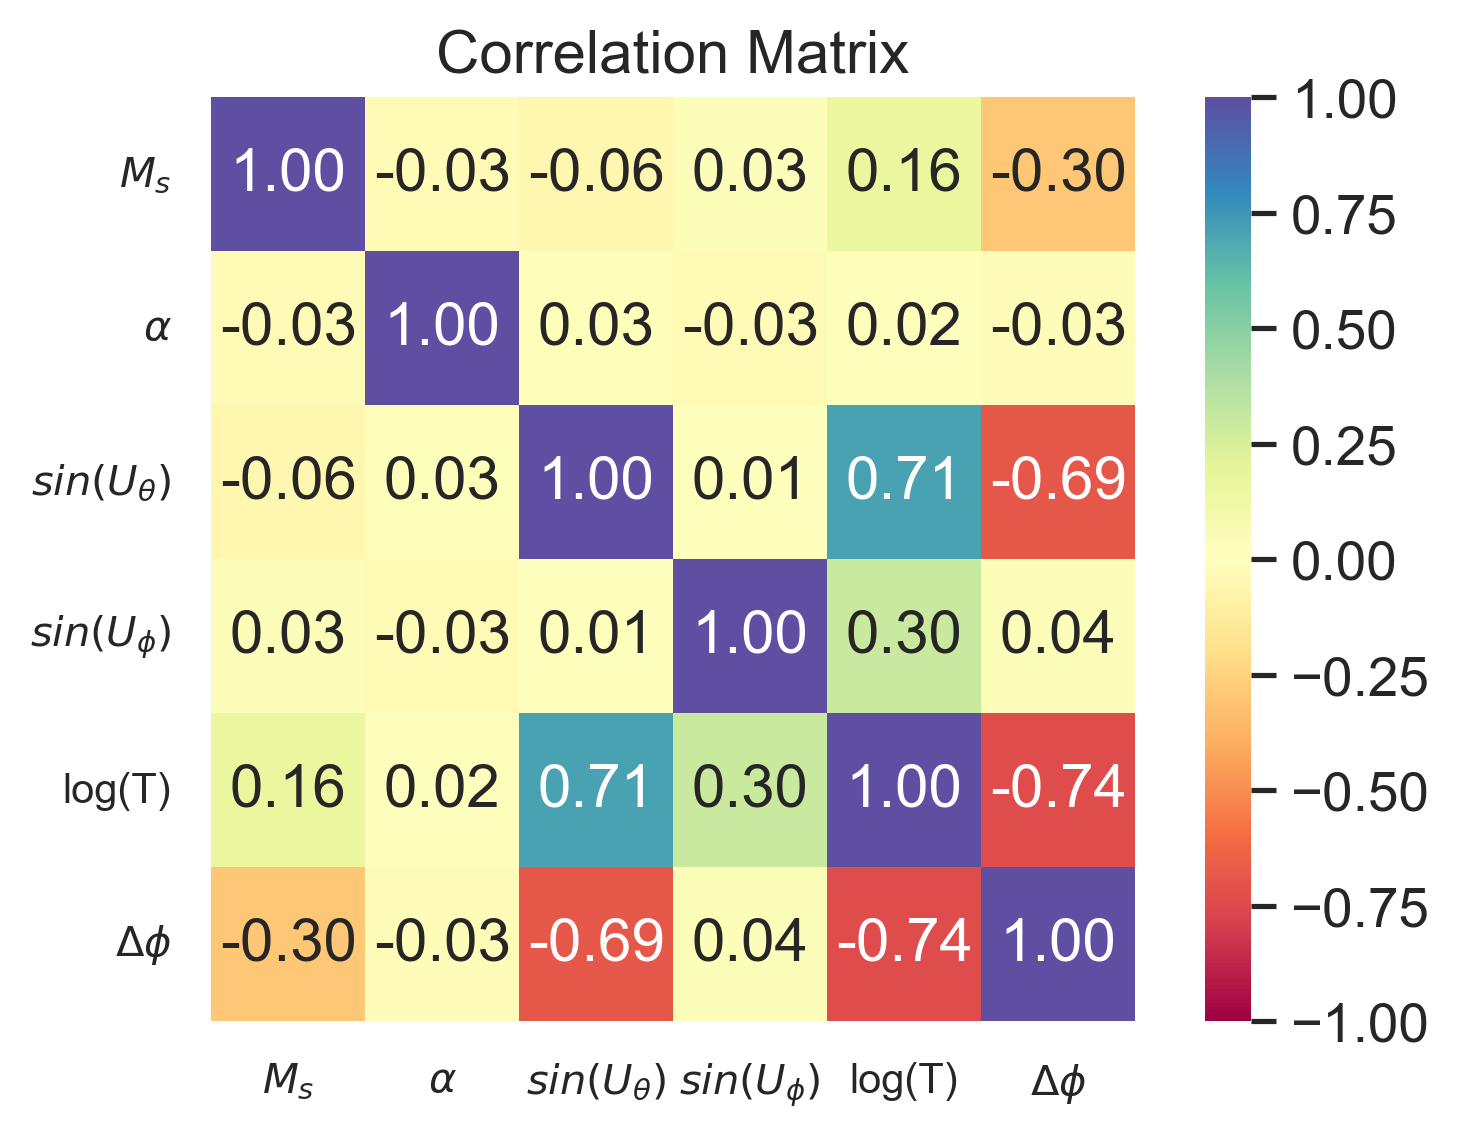

In [3]:
# Load dataset
#df = pd.read_csv("D:\\UBERMAG_RESULTS\\spin_wave_results-two-bounds-lhs-1000.csv")  # Update with the actual filename
df = pd.read_csv("D:\\UBERMAG_RESULTS\\spin_wave_results_LHS_1000_LG2um.csv")  # Update with the actual filename 

# Check basic stats
print(df.info())
print(df.describe())


# Discard raow where T > 1 and TRANSFORM DATA: normalised to the maximum T (i.e. max Ms and lowest alpha)

df = df[df["Transmission"] <= 1.0]
print(np.max(df["Transmission"]))
#df["Transmission"] = df["Transmission"] / np.max(df["Transmission"])

# Transform Phase Shift.


phases_rad = np.deg2rad(df["Phase Shift (deg)"])
mean_phase = np.angle(np.mean(np.exp(1j * phases_rad)))
centered_phases_rad = np.angle(np.exp(1j * (phases_rad - mean_phase)))
df["Phase Shift (deg)"] = np.rad2deg(centered_phases_rad) + 180


# TRANSFORM angle_u to sin(angle_u)


df["angle_theta"] = np.sin(df["angle_theta"] * np.pi / 180)
df.rename(columns={"angle_theta": r"$sin(U_\theta)$"}, inplace=True)

df["angle_phi"] = np.sin(df["angle_phi"] * np.pi / 180)
df.rename(columns={"angle_phi": r"$sin(U_\phi)$"}, inplace=True)

df["Transmission"] = np.log(df["Transmission"])
df.rename(columns={"Transmission": "log(T)"}, inplace=True)

df.rename(columns={"Phase Shift (deg)": r"$\Delta \phi$"}, inplace=True)
df.rename(columns={"M_s": r"$M_s$"}, inplace=True)
df.rename(columns={"alpha": r"$\alpha$"}, inplace=True)

df = df.drop(columns=['A_ex', 'K_u'])
df = df.drop_duplicates()

# df["Phase Shift (deg)"] = np.log(df["Phase Shift (deg)"])
# df.rename(columns={"Phase Shift (deg)": "log(Phase Shift (deg))"}, inplace=True)

# Check basic stats
print(df.info())
print(df.describe())


# Check correlation matrix

fig, ax = plt.subplots(ncols=1, sharey=True)

# plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="Spectral", vmin=-1.00, vmax=1.00, fmt=".2f")
ax.set_box_aspect(1)  # Makes the plot square
ax.tick_params(axis='both', labelsize=10)
plt.title("Correlation Matrix")
plt.show()
fig.savefig("Correlation_Matrix.pdf", format='pdf')

In [4]:
'''
# Define a function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply it to Transmission and Phase Shift (deg)
df_cleaned = remove_outliers_iqr(df, 'log(T)')
df_cleaned = remove_outliers_iqr(df_cleaned, r"$\Delta \phi$")

# Optional: Show how many rows were removed
print(f"Original dataset: {len(df)} rows")
print(f"After removing outliers: {len(df_cleaned)} rows")

df = df_cleaned
'''

'\n# Define a function to remove outliers using IQR\ndef remove_outliers_iqr(df, column):\n    Q1 = df[column].quantile(0.25)\n    Q3 = df[column].quantile(0.75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]\n\n# Apply it to Transmission and Phase Shift (deg)\ndf_cleaned = remove_outliers_iqr(df, \'log(T)\')\ndf_cleaned = remove_outliers_iqr(df_cleaned, r"$\\Delta \\phi$")\n\n# Optional: Show how many rows were removed\nprint(f"Original dataset: {len(df)} rows")\nprint(f"After removing outliers: {len(df_cleaned)} rows")\n\ndf = df_cleaned\n'

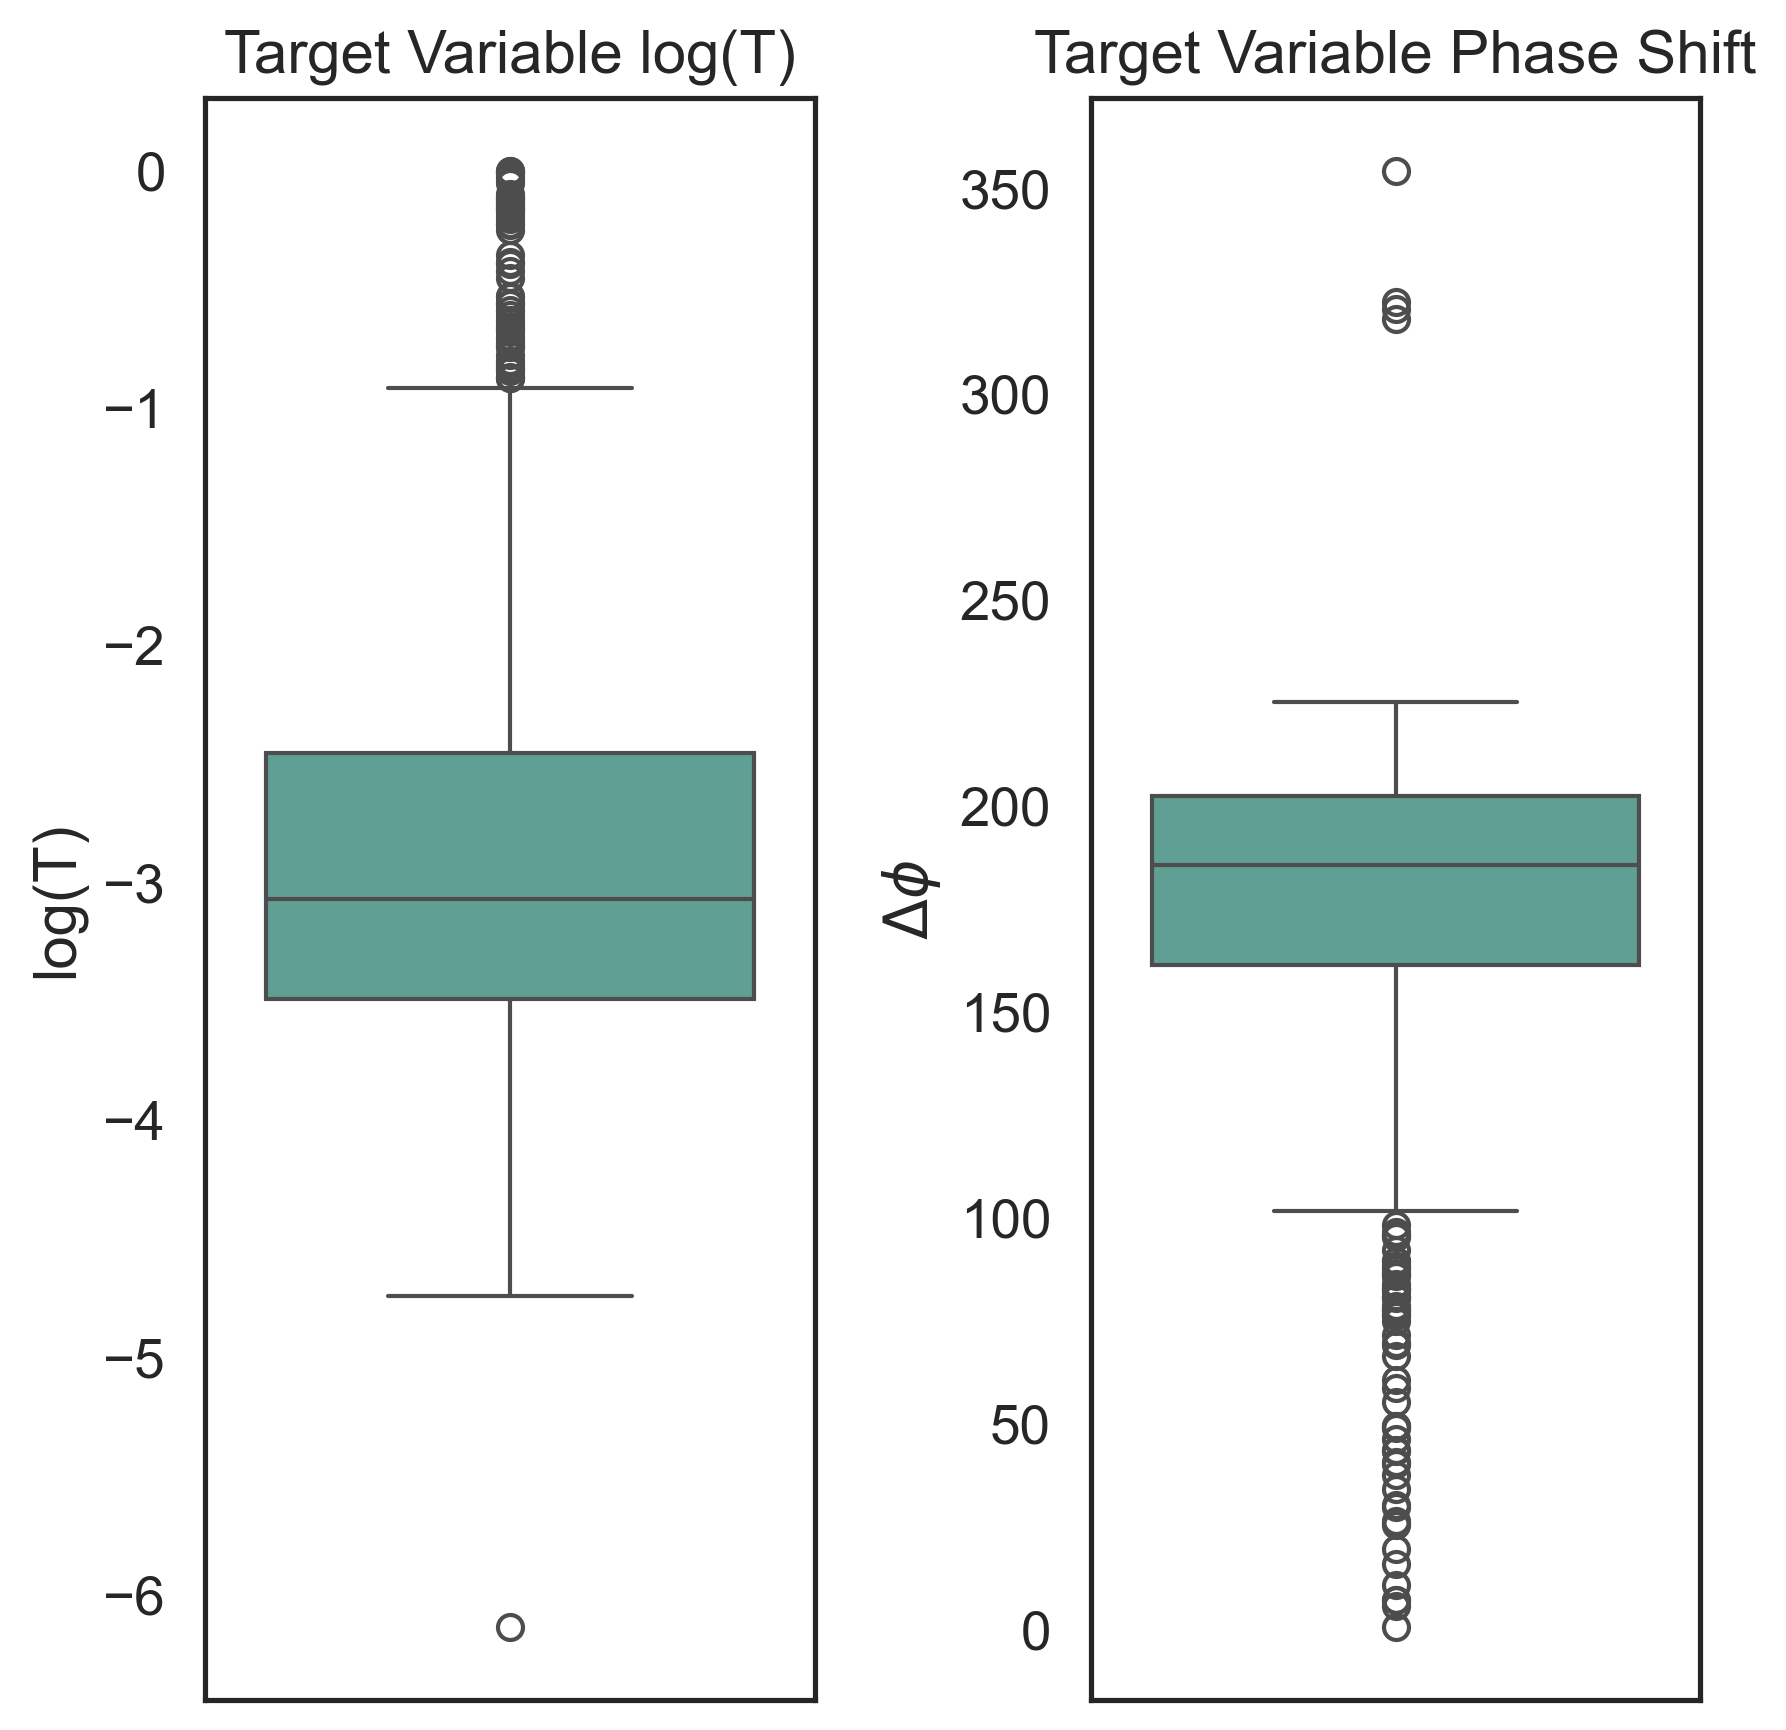

In [5]:
# Example data (replace with your own y1 and y2)
# y1 and y2 can be NumPy arrays or pandas Series
dff = pd.DataFrame({
    'Target': ['log(T)'] * len(df["log(T)"]) + [r"$\Delta \phi$"] * len(df[r"$\Delta \phi$"]),
    'Value':  list(df["log(T)"]) + list(df[r"$\Delta \phi$"])
})

# Plot

fig, axes = plt.subplots(1, 2, figsize=(6, 6))

sns.boxplot(y=df["log(T)"], ax=axes[0])
axes[0].set_title('Target Variable log(T)')

sns.boxplot(y=df[r"$\Delta \phi$"], ax=axes[1])
axes[1].set_title('Target Variable Phase Shift')

plt.tight_layout()
plt.savefig("Boxplots.pdf", format='pdf')
plt.show()


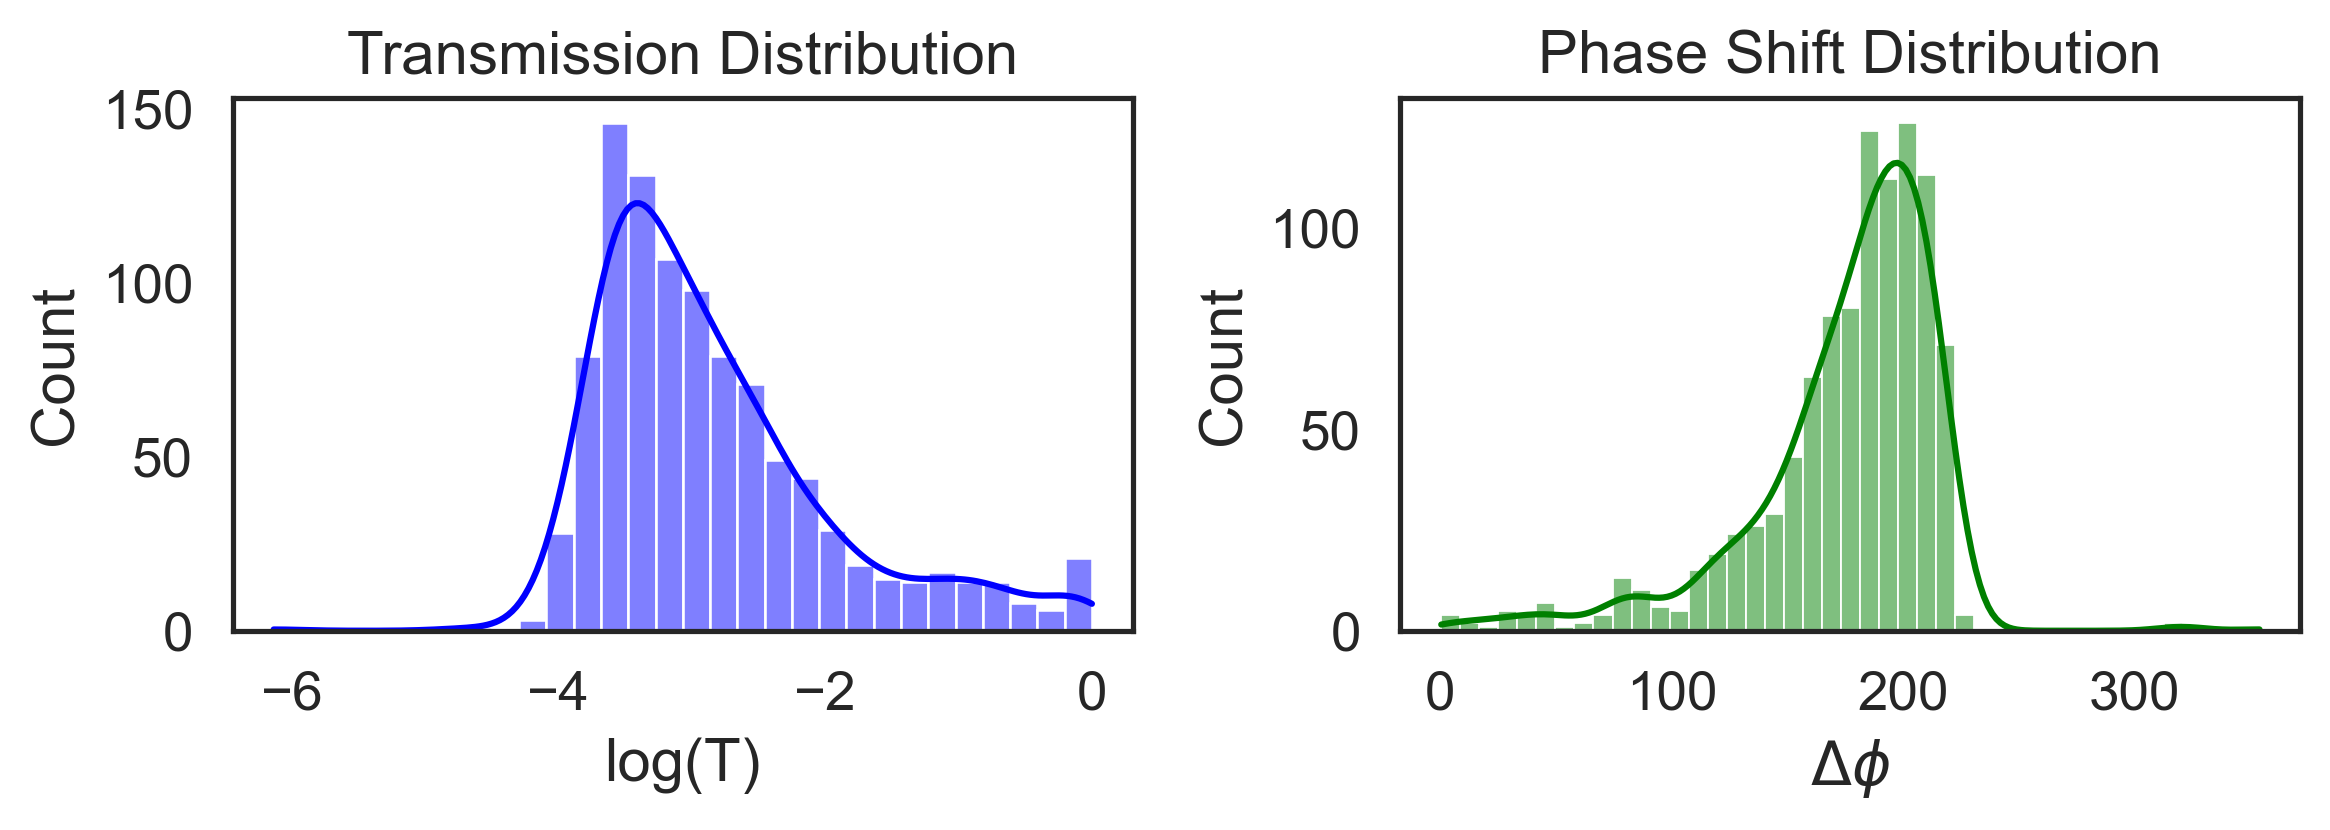

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

sns.histplot(df['log(T)'], kde=True, ax=axes[0], color="blue")
axes[0].set_title("Transmission Distribution")
axes[0].set_xlabel("log(T)")

sns.histplot(df[r"$\Delta \phi$"], kde=True, ax=axes[1], color="green")
axes[1].set_title("Phase Shift Distribution")
axes[1].set_xlabel(r"$\Delta \phi$")

plt.tight_layout()
plt.show()

fig.savefig("Histograms.pdf", format='pdf')

In [7]:
# Calculate Fisher's skewness (default is bias-corrected Fisher version)
trans_skew = skew(df['log(T)'], bias=False)
phase_skew = skew(df[r"$\Delta \phi$"], bias=False)

print(f"Skewness (Transmission): {trans_skew:.4f}")
print(f"Skewness (Phase Shift): {phase_skew:.4f}")

Skewness (Transmission): 1.1766
Skewness (Phase Shift): -1.3826


In [8]:
dataT = df['log(T)']
dataP = df[r"$\Delta \phi$"]

In [9]:

# Hipótesis: ¿Se ajusta a un distribución X? (Nula = Sí, se ajusta. Si p > 0.05: no hay evidencia para rechazarla, por lo que sí, se ajusta a X)

# Ajustar varias distribuciones y guardar los resultados
distributions = {
    #"chi2": stats.chi2,
    "norm": stats.norm,
    "skewnorm": stats.gamma,
    "lognorm": stats.lognorm,
    "weibull_min": stats.weibull_min,
    #"beta": stats.beta
}

fit_results = {}

# Probar cada distribución y calcular p-valor de la prueba KS
for name, dist in distributions.items():
    try:
        params = dist.fit(dataT)
        D, p = stats.kstest(dataT, name, args=params)
        fit_results[name] = {
            "params": params,
            "ks_stat": D,
            "p_value": p
        }
    except Exception as e:
        fit_results[name] = {"error": str(e)}

fit_results




C:\Users\david.osuna\AppData\Local\anaconda3\envs\ubermag\lib\site-packages\scipy\stats\_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


{'norm': {'params': (-2.838028458429563, 0.9009039818459083),
  'ks_stat': 0.11418462674174412,
  'p_value': 9.318467855873618e-12},
 'skewnorm': {'params': (19.241005983341303,
   -6.6070494191163665,
   0.19588477869945894),
  'ks_stat': 0.9989949748743718,
  'p_value': 0.0},
 'lognorm': {'params': (0.20196496253912,
   -7.042305856953561,
   4.117034980667732),
  'ks_stat': 0.07465180938660632,
  'p_value': 2.8716174648678668e-05},
 'weibull_min': {'params': (1.686439650434545,
   -4.24036370410202,
   1.5852024951085855),
  'ks_stat': 0.05849223631764211,
  'p_value': 0.002116444076580403}}

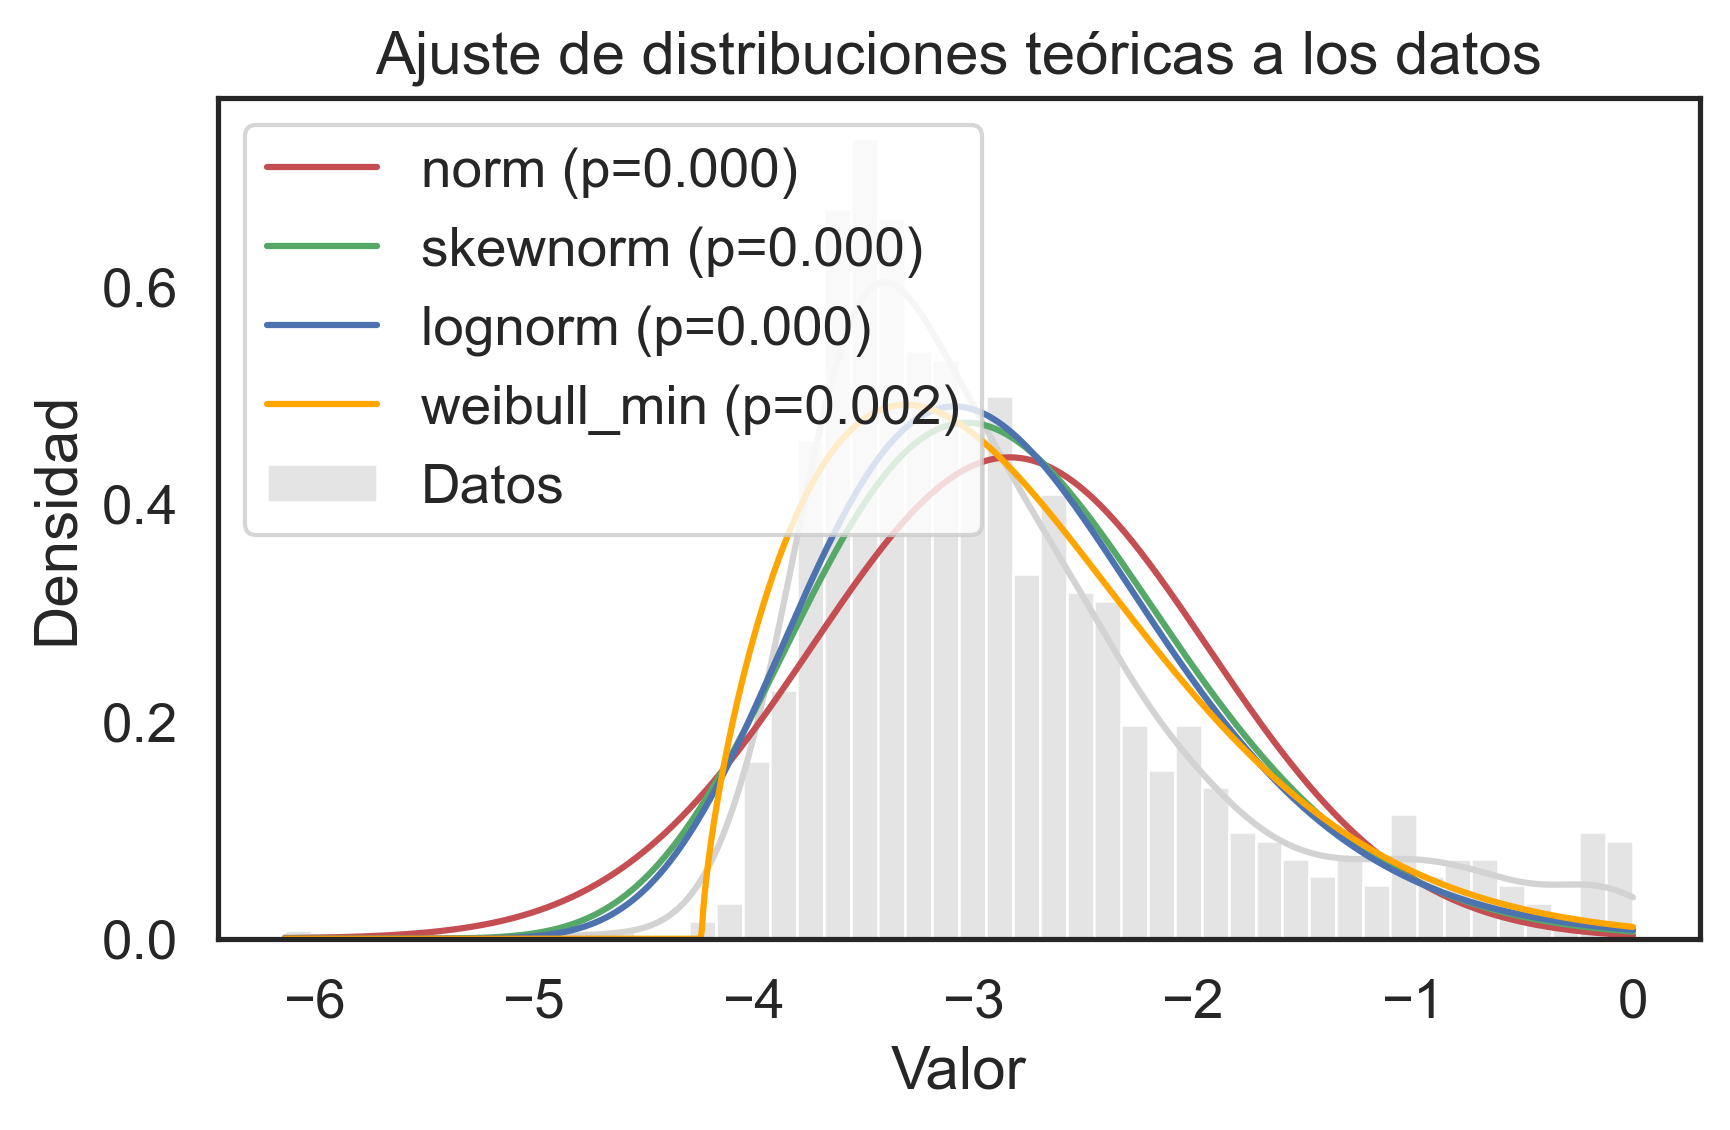

In [10]:
# Histograma de los datos
sns.histplot(dataT, bins=50, kde=True, stat='density', color='lightgray', label='Datos', alpha=0.6)

# Colores para distinguir cada distribución
colors = ['r', 'g', 'b', 'orange', 'purple', 'teal']

# Espacio de valores sobre el que graficar las distribuciones teóricas
x = np.linspace(min(dataT), max(dataT), 1000)

# Graficar cada distribución ajustada
for i, (name, result) in enumerate(fit_results.items()):
    if 'error' in result:
        continue  # Saltar distribuciones que fallaron
    dist = distributions[name]
    params = result['params']
    
    # Obtener pdf de la distribución ajustada
    pdf = dist.pdf(x, *params)
    plt.plot(x, pdf, color=colors[i % len(colors)], label=f"{name} (p={result['p_value']:.3f})")

plt.title("Ajuste de distribuciones teóricas a los datos")
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\david.osuna\AppData\Local\anaconda3\envs\ubermag\lib\site-packages\scipy\stats\_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


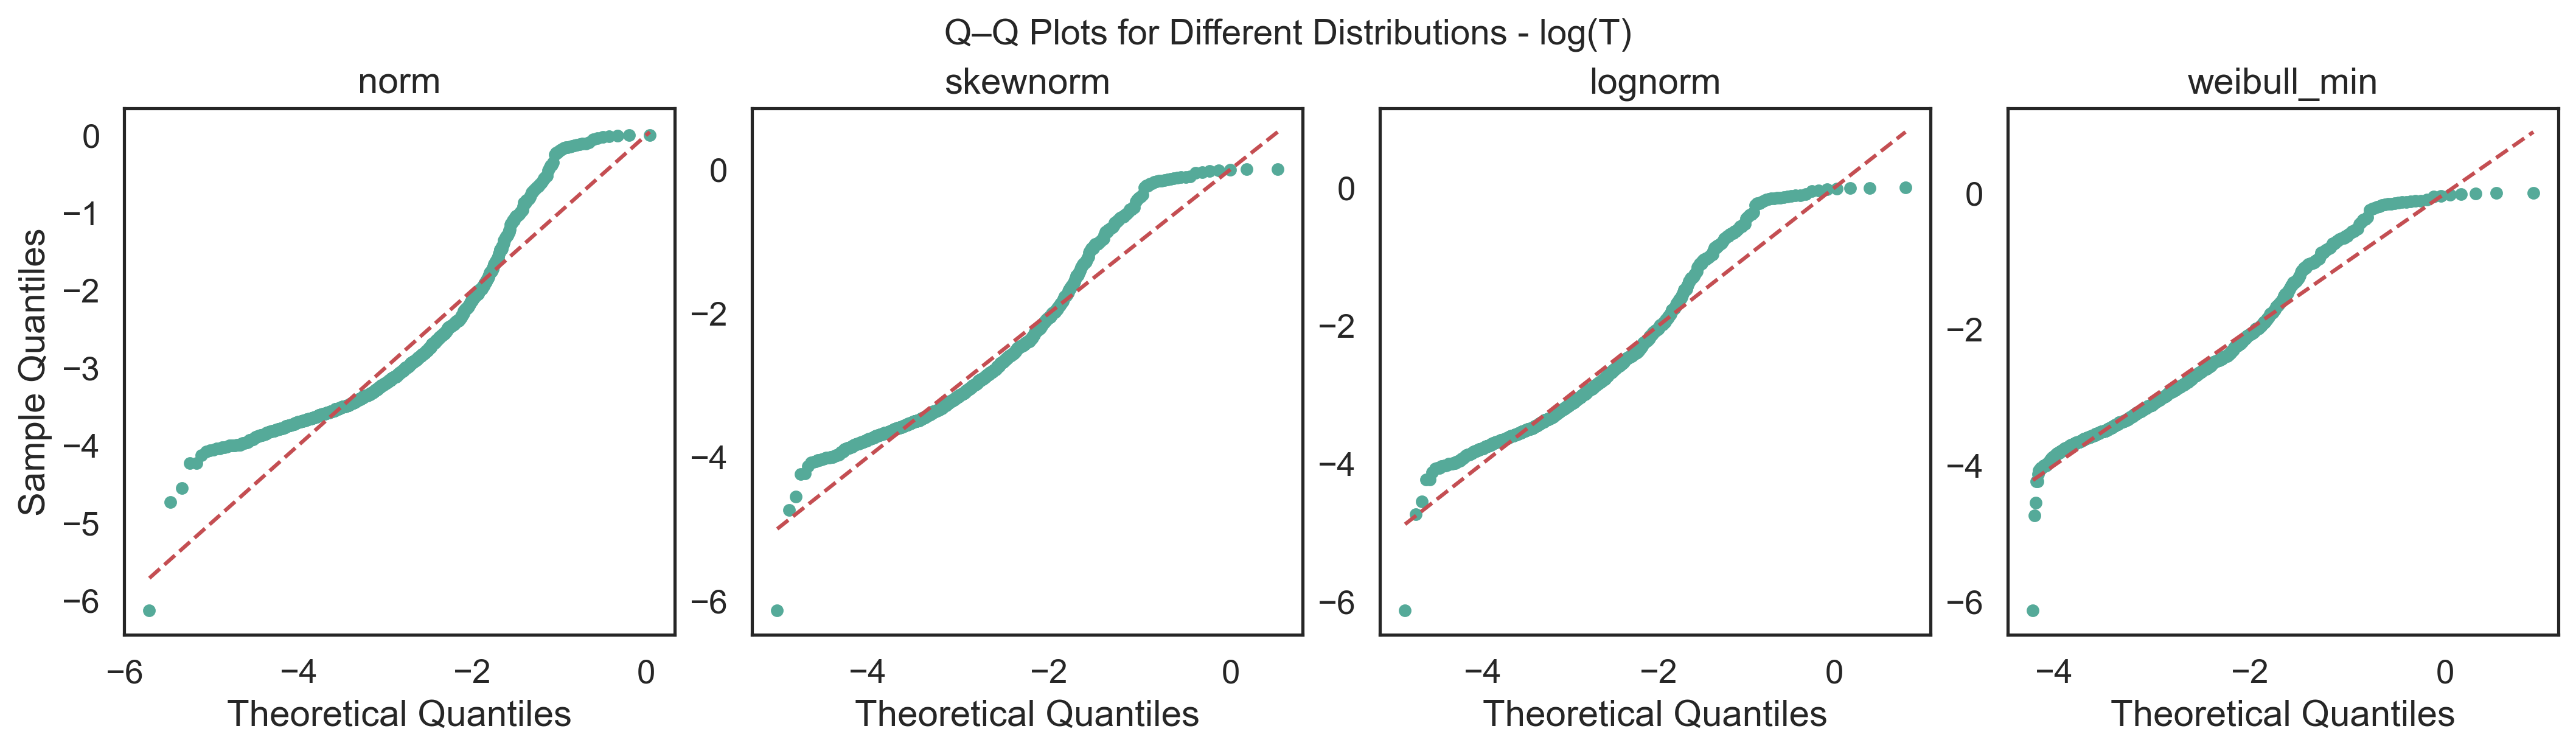

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4), constrained_layout=True, sharey=False)
fig.suptitle("Q–Q Plots for Different Distributions - log(T)", fontsize=14)

for ax, (name, dist) in zip(axs, distributions.items()):
    try:
        params = dist.fit(dataT)
        # Generate theoretical quantiles and sample quantiles
        (osm, osr), _ = stats.probplot(dataT, dist=dist, sparams=params)

        ax.plot(osm, osr, 'o', markersize=4, label='Data')
        ax.plot(osm, osm, 'r--', label='Reference Line')
        ax.set_title(name)
        ax.set_xlabel("Theoretical Quantiles")
        if ax==axs[0]:
            ax.set_ylabel("Sample Quantiles")
        ax.grid(False)
    except Exception as e:
        ax.text(0.5, 0.5, f"Error:\n{name}\n{str(e)}", ha='center', va='center')
        ax.set_title(name)
        ax.axis('off')
fig.savefig("QQ_plots_T.pdf", format='pdf')
plt.show()

In [12]:


# Ajustar varias distribuciones y guardar los resultados
distributions = {
    #"chi2": stats.chi2,
    "norm": stats.norm,
    "skewnorm": stats.gamma,
    "lognorm": stats.lognorm,
    "weibull_min": stats.weibull_min
    #"beta": stats.beta
}

fit_results = {}

# Probar cada distribución y calcular p-valor de la prueba KS
for name, dist in distributions.items():
    try:
        params = dist.fit(dataP)
        D, p = stats.kstest(dataP, name, args=params)
        fit_results[name] = {
            "params": params,
            "ks_stat": D,
            "p_value": p
        }
    except Exception as e:
        fit_results[name] = {"error": str(e)}

fit_results

{'norm': {'params': (175.60021131363266, 40.541647424856095),
  'ks_stat': 0.12411438218406362,
  'p_value': 8.105829070780637e-14},
 'skewnorm': {'params': (215.70968521477187,
   -465.4460082671558,
   2.9686380208620147),
  'ks_stat': 1.0,
  'p_value': 0.0},
 'lognorm': {'params': (5.120436719551911e-06,
   -7917467.548949908,
   7917643.149057426),
  'ks_stat': 0.12411535579853866,
  'p_value': 8.101900103380174e-14},
 'weibull_min': {'params': (0.2047541666254305,
   0.5206114790912578,
   3.188350449943368),
  'ks_stat': 0.8211953843879234,
  'p_value': 0.0}}

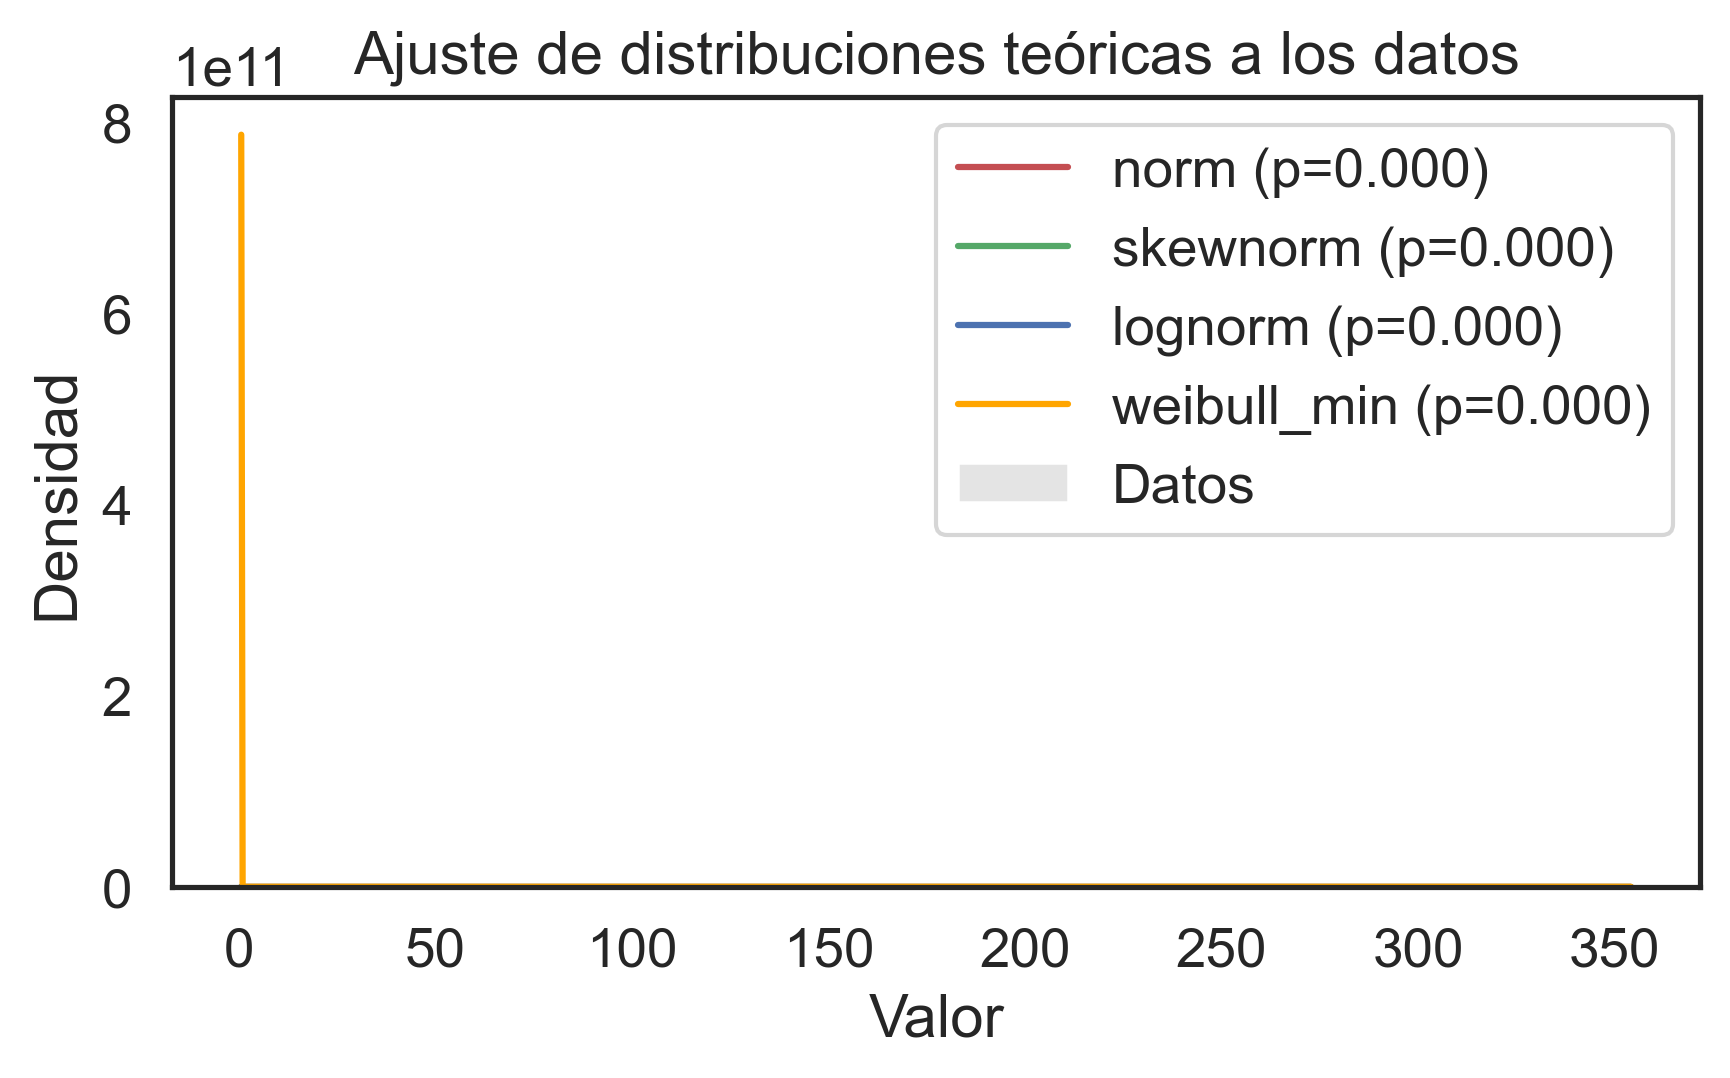

In [13]:
# Histograma de los datos
sns.histplot(dataP, bins=50, kde=False, stat='density', color='lightgray', label='Datos', alpha=0.6)

# Colores para distinguir cada distribución
colors = ['r', 'g', 'b', 'orange', 'purple', 'teal']

# Espacio de valores sobre el que graficar las distribuciones teóricas
x = np.linspace(min(dataP), max(dataP), 1000)

# Graficar cada distribución ajustada
for i, (name, result) in enumerate(fit_results.items()):
    if 'error' in result:
        continue  # Saltar distribuciones que fallaron
    dist = distributions[name]
    params = result['params']
    
    # Obtener pdf de la distribución ajustada
    pdf = dist.pdf(x, *params)
    plt.plot(x, pdf, color=colors[i % len(colors)], label=f"{name} (p={result['p_value']:.3f})")

plt.title("Ajuste de distribuciones teóricas a los datos")
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()

Keep log(Transmission) as your target for regression. It's more likely to follow linear relationships and have homoscedastic residuals.

Consider using log-likelihood-based metrics or distribution-aware loss functions if modeling probabilistically (e.g. using a probabilistic neural network or Bayesian regression).

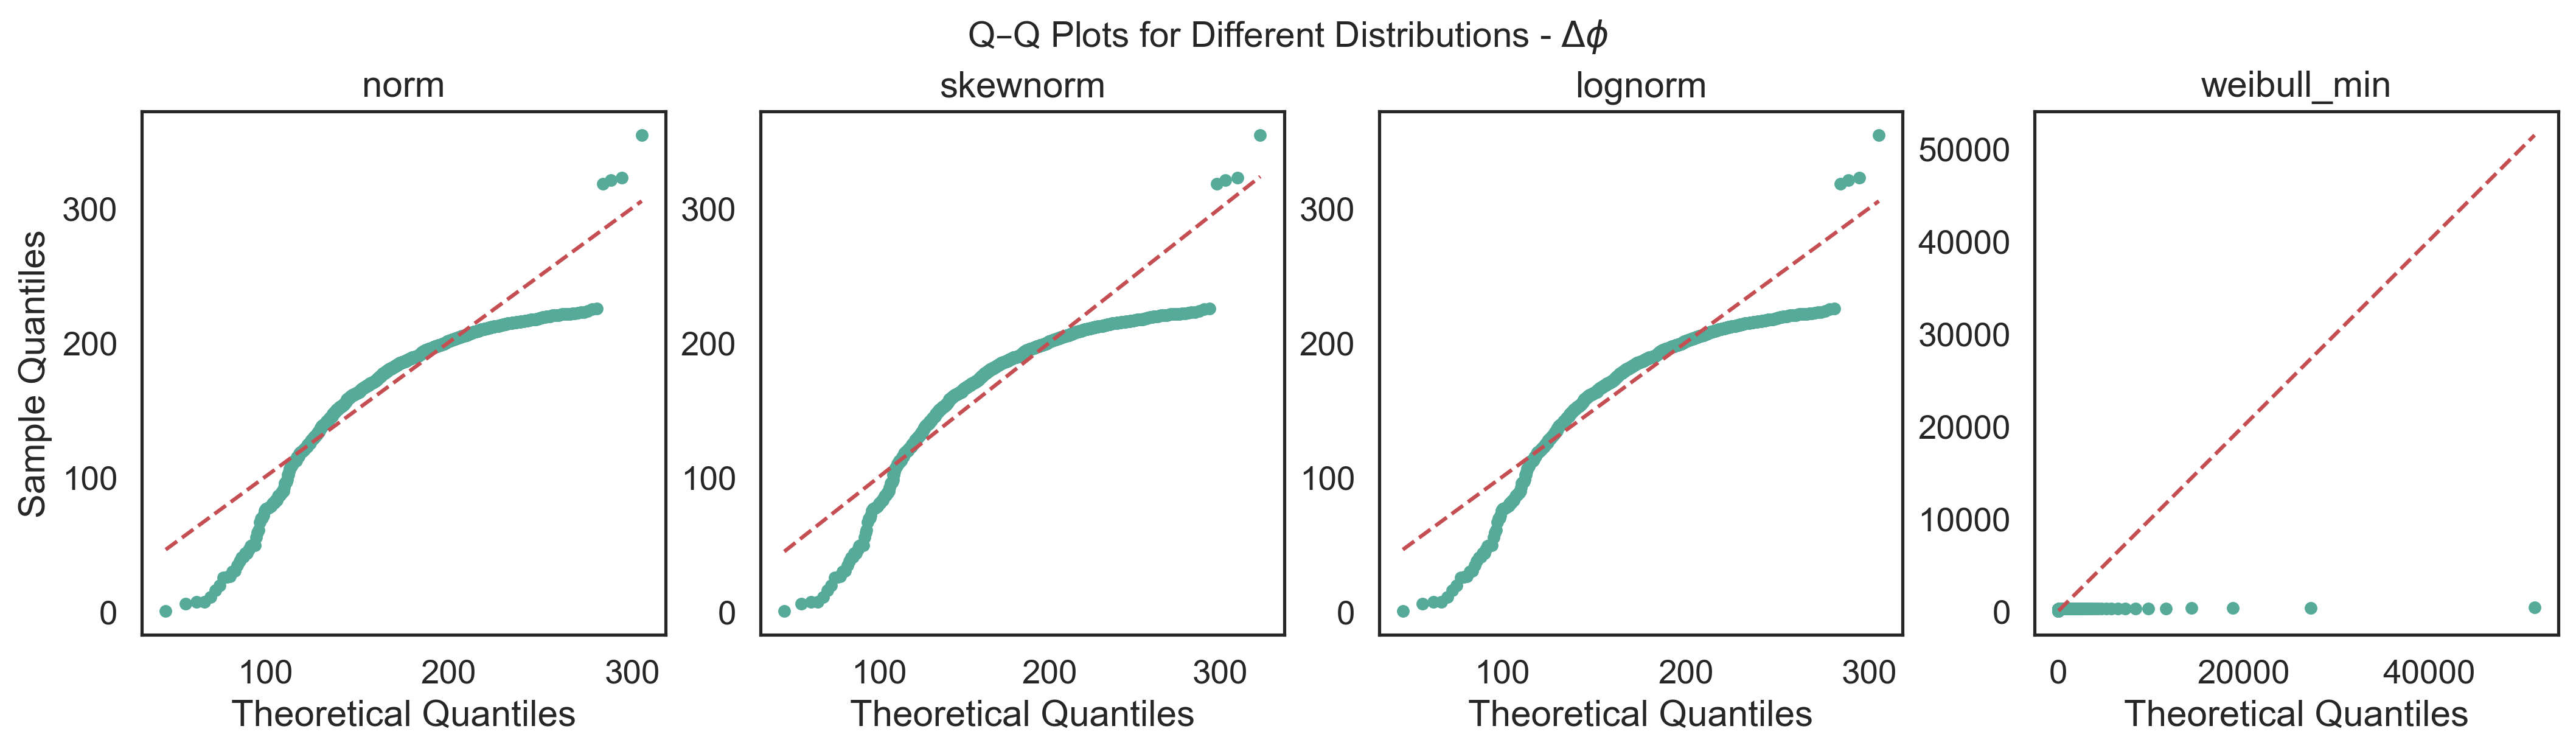

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4), constrained_layout=True, sharey=False)
fig.suptitle(r"Q–Q Plots for Different Distributions - $\Delta\phi$", fontsize=14)

for ax, (name, dist) in zip(axs, distributions.items()):
    try:
        params = dist.fit(dataP)
        # Generate theoretical quantiles and sample quantiles
        (osm, osr), _ = stats.probplot(dataP, dist=dist, sparams=params)

        ax.plot(osm, osr, 'o', markersize=4, label='Data')
        ax.plot(osm, osm, 'r--', label='Reference Line')
        ax.set_title(name)
        ax.set_xlabel("Theoretical Quantiles")
        if ax==axs[0]:
            ax.set_ylabel("Sample Quantiles")
        ax.grid(False)
    except Exception as e:
        ax.text(0.5, 0.5, f"Error:\n{name}\n{str(e)}", ha='center', va='center')
        ax.set_title(name)
        ax.axis('off')
fig.savefig("QQ_plots_P.pdf", format='pdf')
plt.show()

In [16]:
seed = 33

# =============================
# 🧹 PREPARACIÓN DE VARIABLES
# =============================
X = df.drop(columns=["log(T)", r"$\Delta \phi$"])
y_T = df["log(T)"]
y_P = df[r"$\Delta \phi$"]

# Scale the target variable using MinMaxScaler
scaler_y = StandardScaler() # MinMaxScaler()
# y_T_scaled = scaler_y.fit_transform(y_T.values.reshape(-1, 1)).flatten()
# y_P_scaled = scaler_y.fit_transform(y_P.values.reshape(-1, 1)).flatten()

y_T_scaled = y_T
y_P_scaled = y_P

# ========================
# ✂️ DIVISIÓN EN CONJUNTOS
# ========================
X_train, X_test, y_T_train, y_T_test, y_P_train, y_P_test = train_test_split(
    X, y_T_scaled, y_P_scaled, test_size=0.2, random_state=seed
)

'''
# Crear una nueva variable de interacción entre Transmission y Phase Shift
X_train['Transmission_x_PhaseShift'] = y_T_train * y_P_train
X_test['Transmission_x_PhaseShift'] = y_T_test * y_P_test
'''


"\n# Crear una nueva variable de interacción entre Transmission y Phase Shift\nX_train['Transmission_x_PhaseShift'] = y_T_train * y_P_train\nX_test['Transmission_x_PhaseShift'] = y_T_test * y_P_test\n"

In [17]:

# Define the parameter grid
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None] + list(np.arange(5, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.8],
    'bootstrap': [True, False]
}

# Set up the randomized search
random_search_T = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=seed),
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',  # or 'r2' if you prefer
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=seed
)

# Fit to Transmission target
random_search_T.fit(X_train, y_T_train)
best_rf_T = random_search_T.best_estimator_

# Repeat for Phase Shift model
random_search_P = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=seed),
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=seed
)

random_search_P.fit(X_train, y_P_train)
best_rf_P = random_search_P.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [18]:
print(best_rf_T)
print(best_rf_P)

RandomForestRegressor(max_depth=10, max_features=0.8, min_samples_leaf=3,
                      min_samples_split=3, n_estimators=619, random_state=33)
RandomForestRegressor(max_depth=10, max_features=0.8, min_samples_leaf=3,
                      min_samples_split=3, n_estimators=619, random_state=33)


C:\Users\david.osuna\AppData\Local\Temp\ipykernel_12696\1550757792.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(top5_T["Model"], rotation=45)
C:\Users\david.osuna\AppData\Local\Temp\ipykernel_12696\1550757792.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(top5_P["Model"], rotation=45)


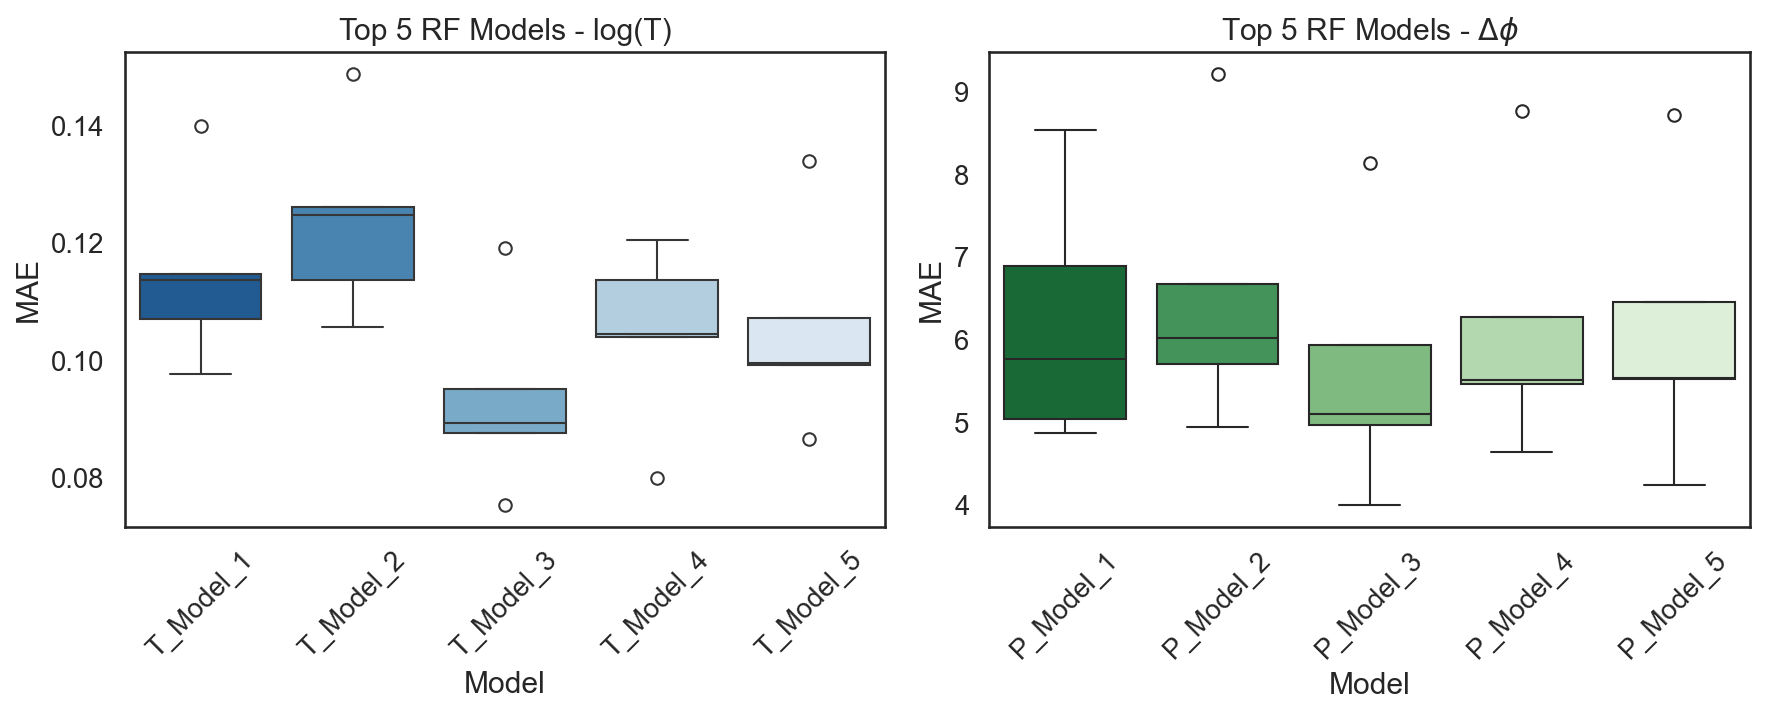

In [19]:

# Extract results
results_rf_T = pd.DataFrame(random_search_T.cv_results_)
results_rf_P = pd.DataFrame(random_search_P.cv_results_)

# Sort by mean_test_score
top5_T = results_rf_T.sort_values(by="rank_test_score").head(5)
top5_P = results_rf_P.sort_values(by="rank_test_score").head(5)

# Add model rank for plotting
top5_T["Model"] = ["T_Model_" + str(i+1) for i in range(5)]
top5_P["Model"] = ["P_Model_" + str(i+1) for i in range(5)]

# === Plot boxplots of split test scores for top 5 models ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# Transmission
sns.boxplot(data=top5_T[[f"split{i}_test_score" for i in range(5)]].T * -1, ax=axs[0], palette="Blues_r")
axs[0].set_xticklabels(top5_T["Model"], rotation=45)
axs[0].set_title("Top 5 RF Models - log(T)")
axs[0].set_ylabel("MAE")
axs[0].set_xlabel("Model")

# Phase Shift
sns.boxplot(data=top5_P[[f"split{i}_test_score" for i in range(5)]].T * -1, ax=axs[1], palette="Greens_r")
axs[1].set_xticklabels(top5_P["Model"], rotation=45)
axs[1].set_title(r"Top 5 RF Models - $\Delta\phi$")
axs[1].set_ylabel("MAE")
axs[1].set_xlabel("Model")

plt.tight_layout()
plt.savefig("rf_top5_model_boxplots.pdf", format="pdf")
plt.show()


Los boxplots muestran información sobre la robustez de los modelos contruidos a través de todos los folds (5). Por eso si hay consistencia, es que el modelo en estable y robusto frente a otros conjuntos de datos... con estos resultados, los modelos P parecen más robustos que los T. El modelo T 3 parece el de menor varianza y menor mediana de MAE, al igual que el modelo P 3, luego se opta por estos como los óptimos.

In [20]:
# For the top 5 models from random_search_T
top5_params_T = top5_T['params'].tolist()

# For the top 5 models from random_search_P
top5_params_P = top5_P['params'].tolist()

# Display the parameters nicely
for i, params in enumerate(top5_params_T, 1):
    print(f"Top {i} model parameters (T): {params}")

for i, params in enumerate(top5_params_P, 1):
    print(f"Top {i} model parameters (P): {params}")


Top 1 model parameters (T): {'bootstrap': True, 'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 619}
Top 2 model parameters (T): {'bootstrap': False, 'max_depth': 45, 'max_features': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 563}
Top 3 model parameters (T): {'bootstrap': True, 'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 724}
Top 4 model parameters (T): {'bootstrap': True, 'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 327}
Top 5 model parameters (T): {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 348}
Top 1 model parameters (P): {'bootstrap': True, 'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 619}
Top 2 model parameters (P): {'bootstrap': True, 'max_depth': None, 

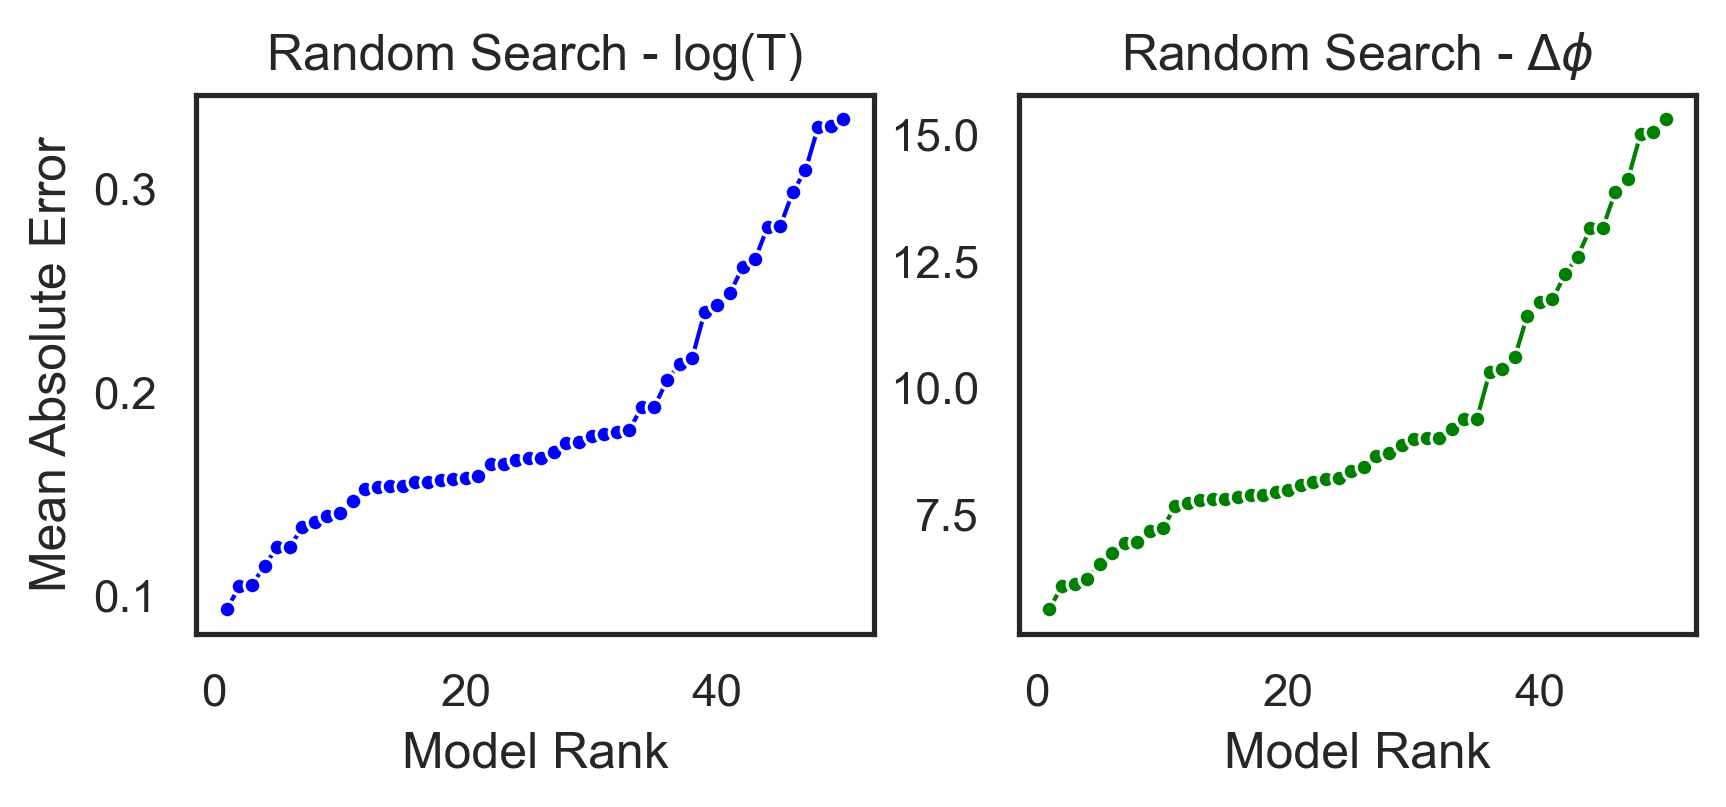

In [24]:

# Extract results
results_T = pd.DataFrame(random_search_T.cv_results_)
results_P = pd.DataFrame(random_search_P.cv_results_)

# Sort by model performance rank
results_T_sorted = results_T.sort_values("rank_test_score")
results_P_sorted = results_P.sort_values("rank_test_score")

# Set style
sns.set(style="white", font_scale=1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(6,3), sharey=False)

# Transmission model
sns.lineplot(
    ax=axes[0],
    x=range(1, len(results_T_sorted) + 1),
    y=-results_T_sorted["mean_test_score"],
    marker="o",
    markersize=4,    
    linewidth=1,
    color="blue"
)
axes[0].set_title("Random Search - log(T)")
axes[0].set_xlabel("Model Rank")
axes[0].set_ylabel("Mean Absolute Error")

# Phase Shift model
sns.lineplot(
    ax=axes[1],
    x=range(1, len(results_P_sorted) + 1),
    y=-results_P_sorted["mean_test_score"],
    marker="o",
    markersize=4,
    linewidth=1,
    color="green"
)
axes[1].set_title(r"Random Search - $\Delta\phi$")
axes[1].set_xlabel("Model Rank")
axes[1].set_ylabel("")

# Final formatting
#plt.suptitle("Hyperparameter Tuning Results (MAE vs. Rank)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("Tuning_RF_ranked_models.pdf", format='pdf')
plt.show()


In [25]:
fig.savefig("Tuning_RF_ranked_models.pdf", format='pdf')

In [27]:

# ==========================
# 🌲 ENTRENAR RANDOM FORESTS
# ==========================

# Modelo para log(Transmission)
rf_T = RandomForestRegressor(bootstrap=True, max_depth=None, max_features=0.8, min_samples_leaf=5,
                      min_samples_split=4, n_estimators=724, random_state=seed)
rf_T.fit(X_train, y_T_train)

# Modelo para Phase Shift
rf_P = RandomForestRegressor(bootstrap=False, max_depth=45, max_features=0.8, min_samples_leaf=3,
                      min_samples_split=9, n_estimators=563, random_state=seed)
rf_P.fit(X_train, y_P_train)

RandomForestRegressor(bootstrap=False, max_depth=45, max_features=0.8,
                      min_samples_leaf=3, min_samples_split=9, n_estimators=563,
                      random_state=33)

In [28]:
# Obtener las características más importantes del Random Forest
importances_T = rf_T.feature_importances_
importances_P = rf_P.feature_importances_

# Ordenar e imprimir las características más importantes para Transmission
indices_T = np.argsort(importances_T)[::-1]
print("Características más importantes para log(Transmission):")
for i in range(len(X_train.columns)):
    print(f"{X_train.columns[indices_T[i]]}: {importances_T[indices_T[i]]:.4f}")

# Ordenar e imprimir las características más importantes para Phase Shift
indices_P = np.argsort(importances_P)[::-1]
print("\nCaracterísticas más importantes para Phase Shift (deg):")
for i in range(len(X_train.columns)):
    print(f"{X_train.columns[indices_P[i]]}: {importances_P[indices_P[i]]:.4f}")



Características más importantes para log(Transmission):
$sin(U_\theta)$: 0.7432
$M_s$: 0.1517
$sin(U_\phi)$: 0.1001
$\alpha$: 0.0050

Características más importantes para Phase Shift (deg):
$sin(U_\theta)$: 0.6758
$M_s$: 0.2881
$sin(U_\phi)$: 0.0257
$\alpha$: 0.0103


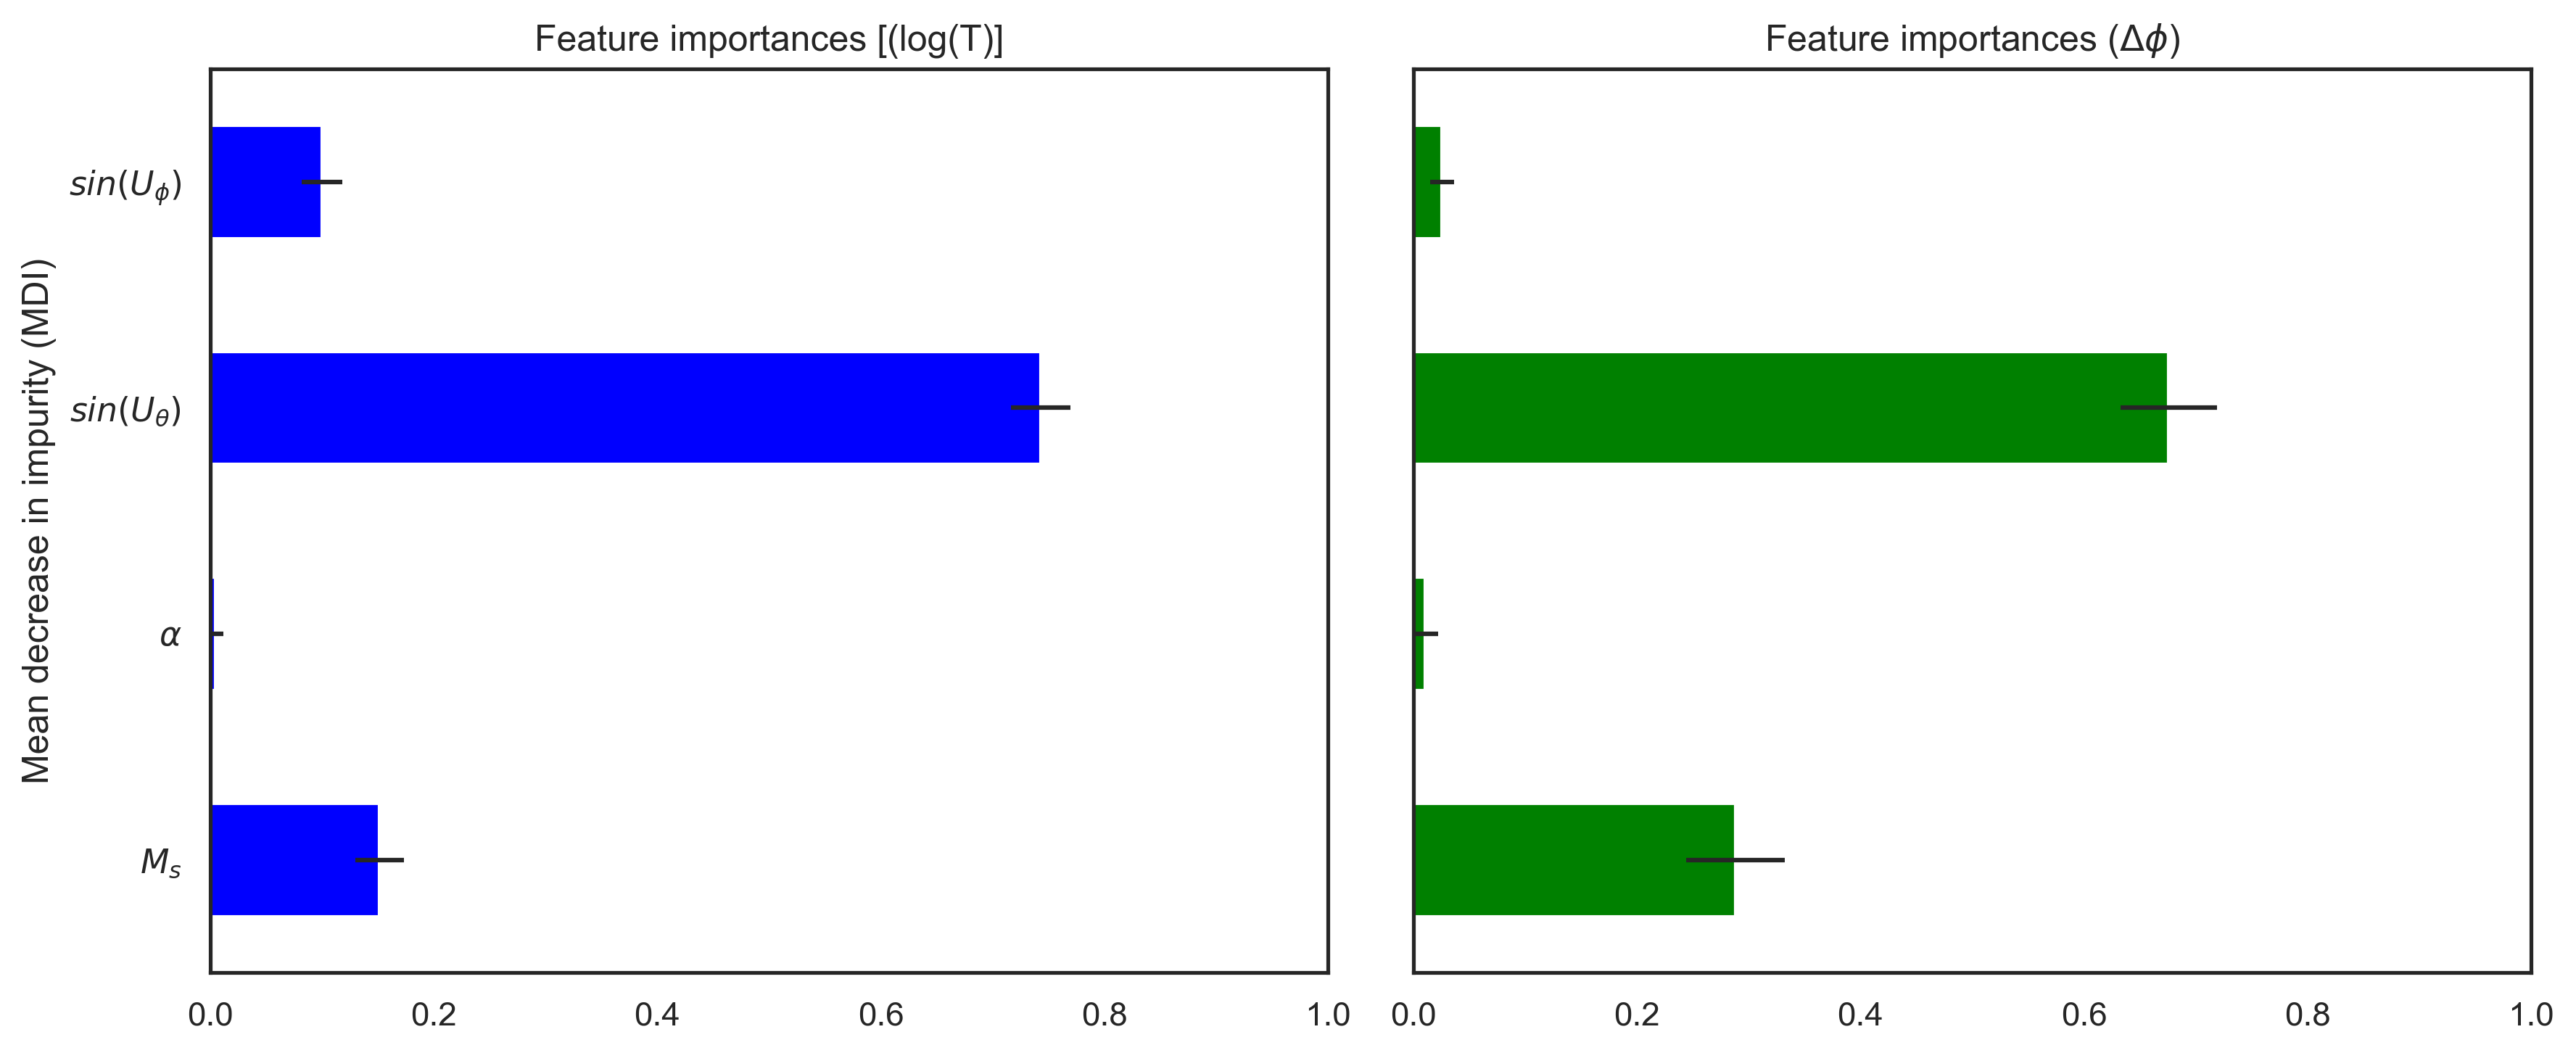

In [29]:
features = [r'$M_s$', r'$\alpha$', r'$sin(U_\theta)$', r'$sin(U_\phi)$']  # ← replace with your actual feature names


forest_importances_T = pd.Series(importances_T, index=features)
forest_importances_P = pd.Series(importances_P, index=features)

std_T = np.std([tree.feature_importances_ for tree in rf_T.estimators_], axis=0)
std_P = np.std([tree.feature_importances_ for tree in rf_P.estimators_], axis=0)


fig, axes = plt.subplots(1,2, sharey=True, figsize=(12,5))
forest_importances_T.plot.barh(xerr=std_T, ax=axes[0], color='blue')
axes[0].set_title("Feature importances [(log(T)]")
axes[0].set_ylabel("Mean decrease in impurity (MDI)")
axes[0].set_xlim(0,1.0)
forest_importances_P.plot.barh(xerr=std_P, ax=axes[1], color='green')
axes[1].set_title(r"Feature importances ($\Delta\phi$)")
axes[1].set_ylabel("Mean decrease in impurity (MDI)")
axes[1].set_xlim(0,1.0)
fig.tight_layout()
fig.savefig("FIs_RF.pdf", format='pdf')
plt.show()

In [30]:
# =====================================
# 📊 EVALUACIÓN DE PREDICCIONES (Random Forest)
# =====================================

# --- Predicciones sobre el set de test ---
y_pred_T_test = rf_T.predict(X_test)
y_pred_P_test = rf_P.predict(X_test)

# --- Métricas R² para el set de test ---
r2_test_T = r2_score(y_T_test, y_pred_T_test)
r2_test_P = r2_score(y_P_test, y_pred_P_test)

print(f"R² log(Transmission) [test]: {r2_test_T:.3f}")
print(f"R² Phase Shift [test]: {r2_test_P:.3f}")

# --- Predicciones sobre el set de entrenamiento ---
y_pred_T_train = rf_T.predict(X_train)
y_pred_P_train = rf_P.predict(X_train)

# --- Métricas R² para el set de entrenamiento ---
r2_train_T = r2_score(y_T_train, y_pred_T_train)
r2_train_P = r2_score(y_P_train, y_pred_P_train)

print(f"R² log(Transmission) [train]: {r2_train_T:.3f}")
print(f"R² Phase Shift [train]: {r2_train_P:.3f}")

# --- Varianzas de las variables objetivo ---
print("------------")
print(f"Varianza log(Transmission): {y_T.var():.3f}")
print(f"Varianza Phase Shift: {y_P.var():.3f}")

# --- Validación cruzada (Cross-validation) ---
cv_scores_T = cross_val_score(rf_T, X, y_T, cv=5, scoring='neg_mean_absolute_error')
cv_scores_P = cross_val_score(rf_P, X, y_P, cv=5, scoring='neg_mean_absolute_error')

print("------------")
print(f"CV R² log(Transmission): {cv_scores_T.mean():.3f}")
print(f"CV R² Phase Shift: {cv_scores_P.mean():.3f}")

# --- MAE para entrenamiento y test ---
print("------------")
print(f"MAE log(Transmission) [train]: {mean_absolute_error(y_T_train, y_pred_T_train):.3f}")
print(f"MAE Phase Shift [train]: {mean_absolute_error(y_P_train, y_pred_P_train):.3f}")
print("------------")
print(f"MAE log(Transmission) [test]: {mean_absolute_error(y_T_test, y_pred_T_test):.3f}")
print(f"MAE Phase Shift [test]: {mean_absolute_error(y_P_test, y_pred_P_test):.3f}")
print("------------")
print("------------")
print(f"MedAE log(Transmission) [test]: {median_absolute_error(y_T_test, y_pred_T_test):.3f}")
print(f"MedAE Phase Shift [test]: {median_absolute_error(y_P_test, y_pred_P_test):.3f}")

'''
# =======================
# 🎯 VISUALIZACIÓN R² PLOT
# =======================
def plot_prediction(y_true, y_pred, title):
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_prediction(y_T_test, y_pred_T_test, f"Prediction vs Actual - Transmission ($R^2$ = {r2_T:.2f})")
plot_prediction(y_P_test, y_pred_P_test, f"Prediction vs Actual - Phase Shift ($R^2$ = {r2_P:.2f})")
'''

R² log(Transmission) [test]: 0.885
R² Phase Shift [test]: 0.936
R² log(Transmission) [train]: 0.984
R² Phase Shift [train]: 0.941
------------
Varianza log(Transmission): 0.812
Varianza Phase Shift: 1645.279
------------
CV R² log(Transmission): -0.089
CV R² Phase Shift: -5.088
------------
MAE log(Transmission) [train]: 0.060
MAE Phase Shift [train]: 2.423
------------
MAE log(Transmission) [test]: 0.109
MAE Phase Shift [test]: 4.378
------------
------------
MedAE log(Transmission) [test]: 0.046
MedAE Phase Shift [test]: 1.781


'\n# =======================\n# 🎯 VISUALIZACIÓN R² PLOT\n# =======================\ndef plot_prediction(y_true, y_pred, title):\n    plt.figure(figsize=(7, 6))\n    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)\n    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], \'r--\')\n    plt.xlabel("Actual")\n    plt.ylabel("Predicted")\n    plt.title(title)\n    plt.grid(True)\n    plt.tight_layout()\n    plt.show()\n\nplot_prediction(y_T_test, y_pred_T_test, f"Prediction vs Actual - Transmission ($R^2$ = {r2_T:.2f})")\nplot_prediction(y_P_test, y_pred_P_test, f"Prediction vs Actual - Phase Shift ($R^2$ = {r2_P:.2f})")\n'

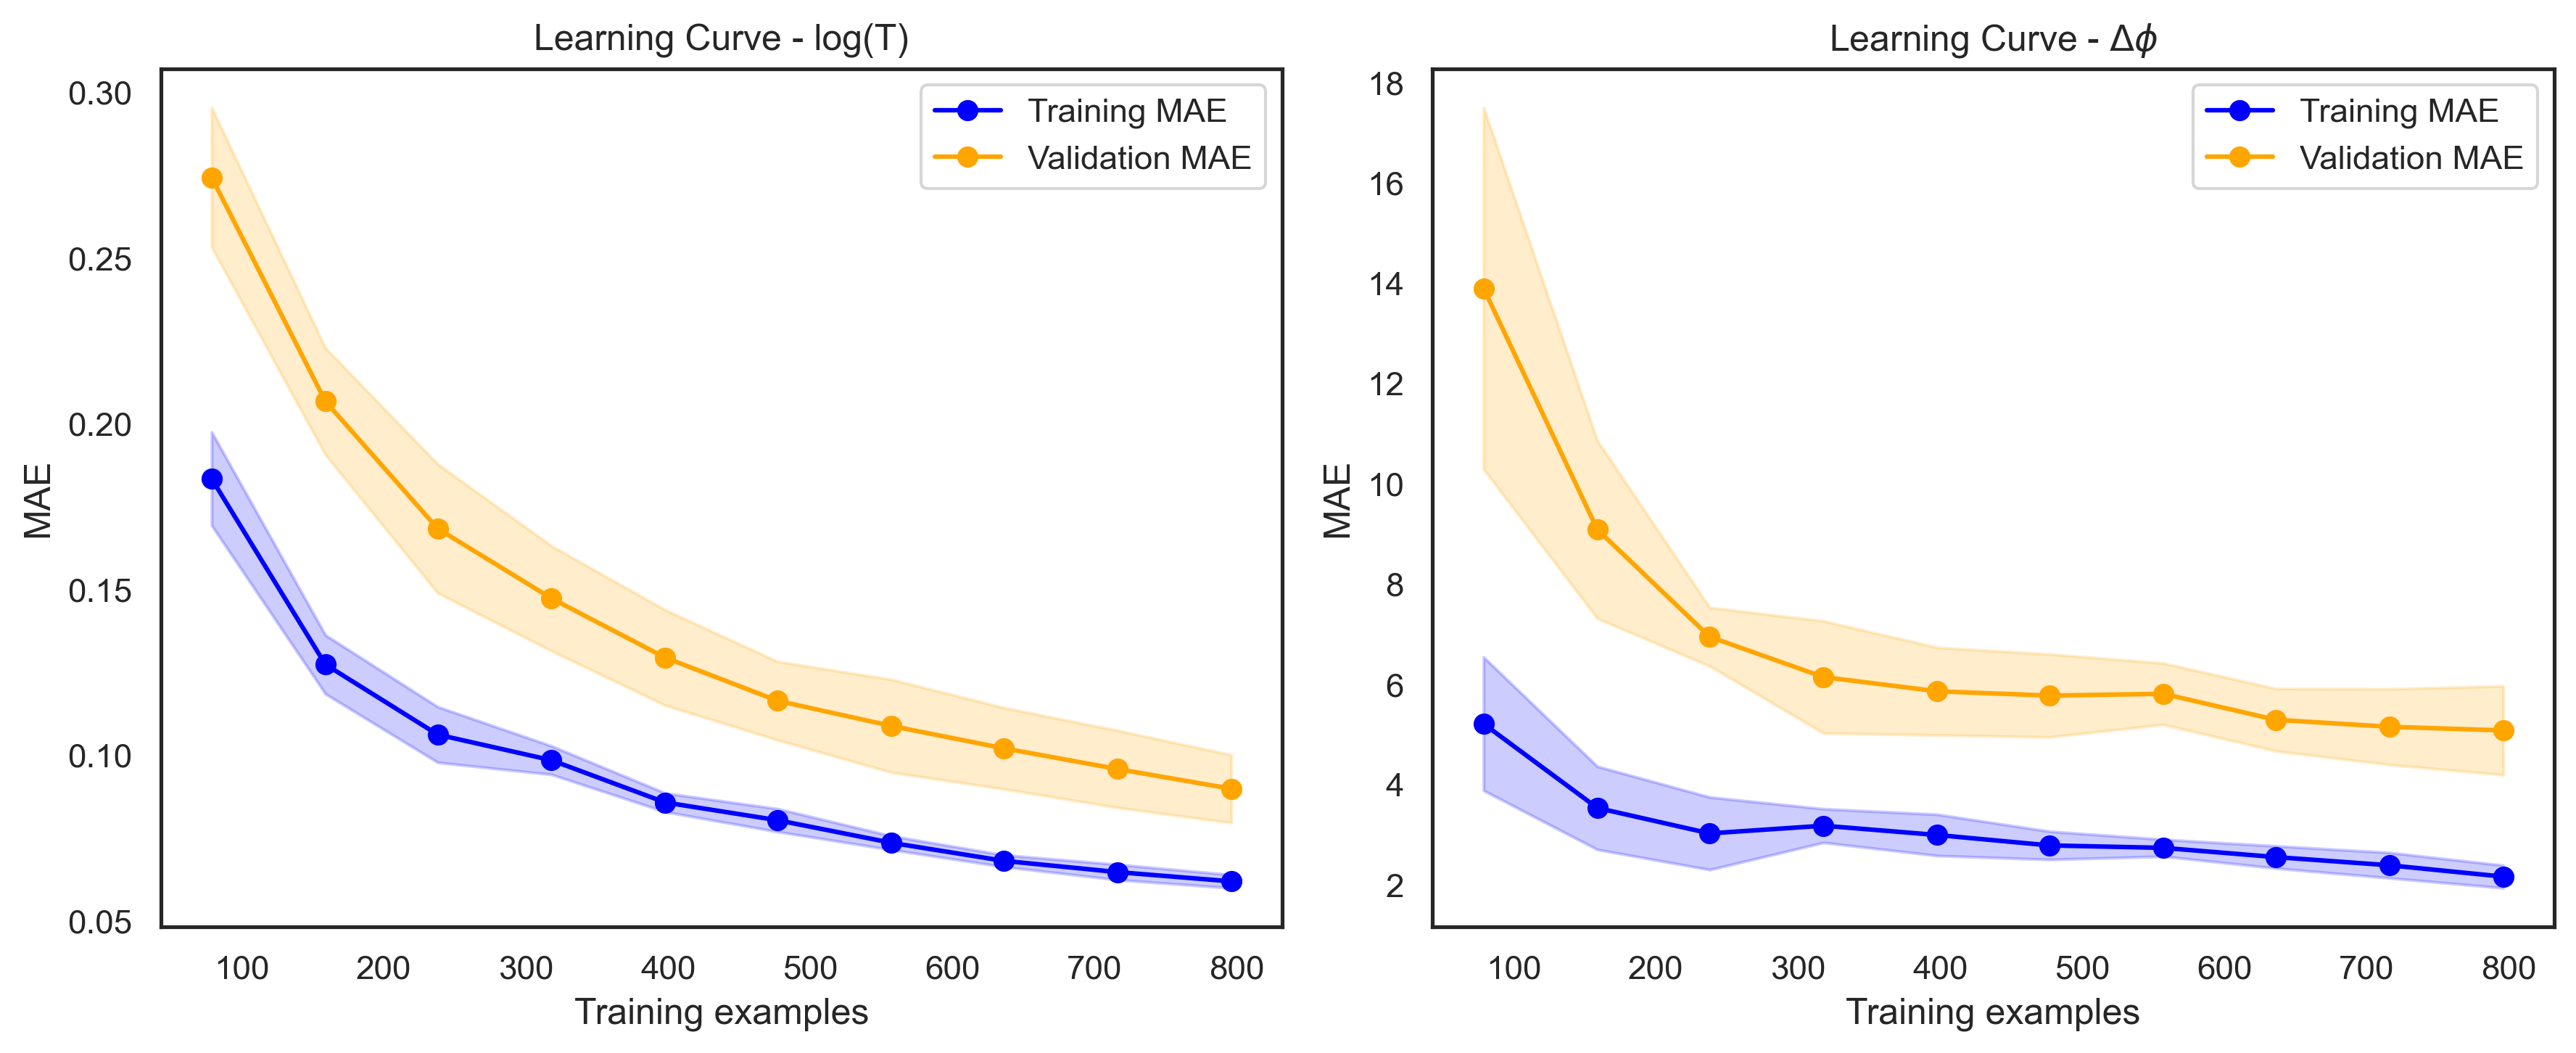

In [31]:

# === Helper function ===
def plot_learning_curve(estimator, X, y, ax, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='neg_mean_absolute_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, shuffle=True, random_state=42
    )

    # Convert negative MAE to positive
    train_scores = -train_scores
    val_scores = -val_scores

    # Mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    ax.plot(train_sizes, train_mean, 'o-', label="Training MAE", color='blue')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

    ax.plot(train_sizes, val_mean, 'o-', label="Validation MAE", color='orange')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("MAE")
    ax.grid(False)
    ax.legend()

# === Create plots side by side ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_learning_curve(rf_T, X, y_T, axs[0], "Learning Curve - log(T)")
plot_learning_curve(rf_P, X, y_P, axs[1], r"Learning Curve - $\Delta \phi$")

plt.tight_layout()
plt.savefig("learning_curves_RF.pdf", format='pdf')
plt.show()


In [32]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_P,
    X=X,
    y=y_P,
    scoring='neg_mean_absolute_error',
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=seed
)

print("Train sizes:", train_sizes)
print("MAE from learning curve (last value):", -np.mean(test_scores[-1]))
print("MAE from test set (direct):", mean_absolute_error(y_P_test, rf_P.predict(X_test)))

Train sizes: [ 79 258 437 616 796]
MAE from learning curve (last value): 5.08772859682763
MAE from test set (direct): 4.377736143730452


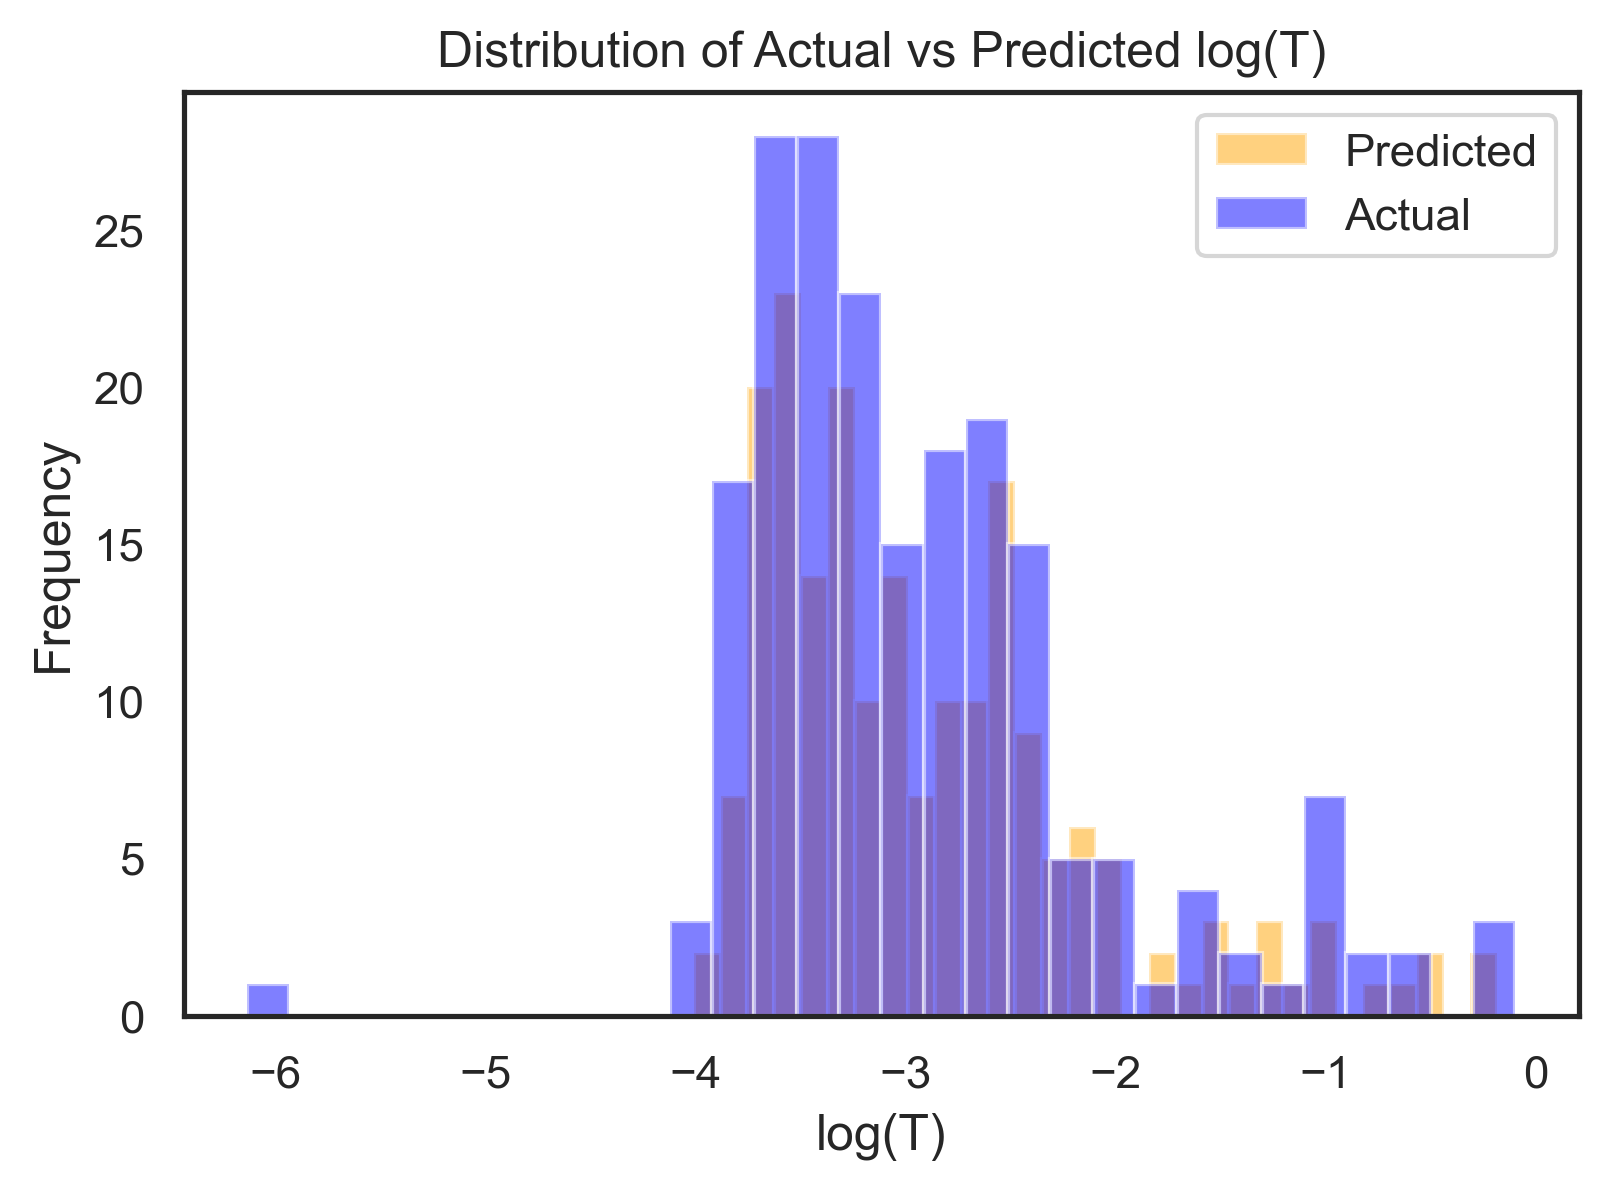

In [33]:
plt.hist(y_pred_T_test, bins=30, color='orange', alpha=0.5, label='Predicted')
plt.hist(y_T_test, bins=30, color='blue', alpha=0.5, label='Actual')
plt.legend()
plt.title("Distribution of Actual vs Predicted log(T)")
plt.xlabel("log(T)")
plt.ylabel("Frequency")
plt.show()


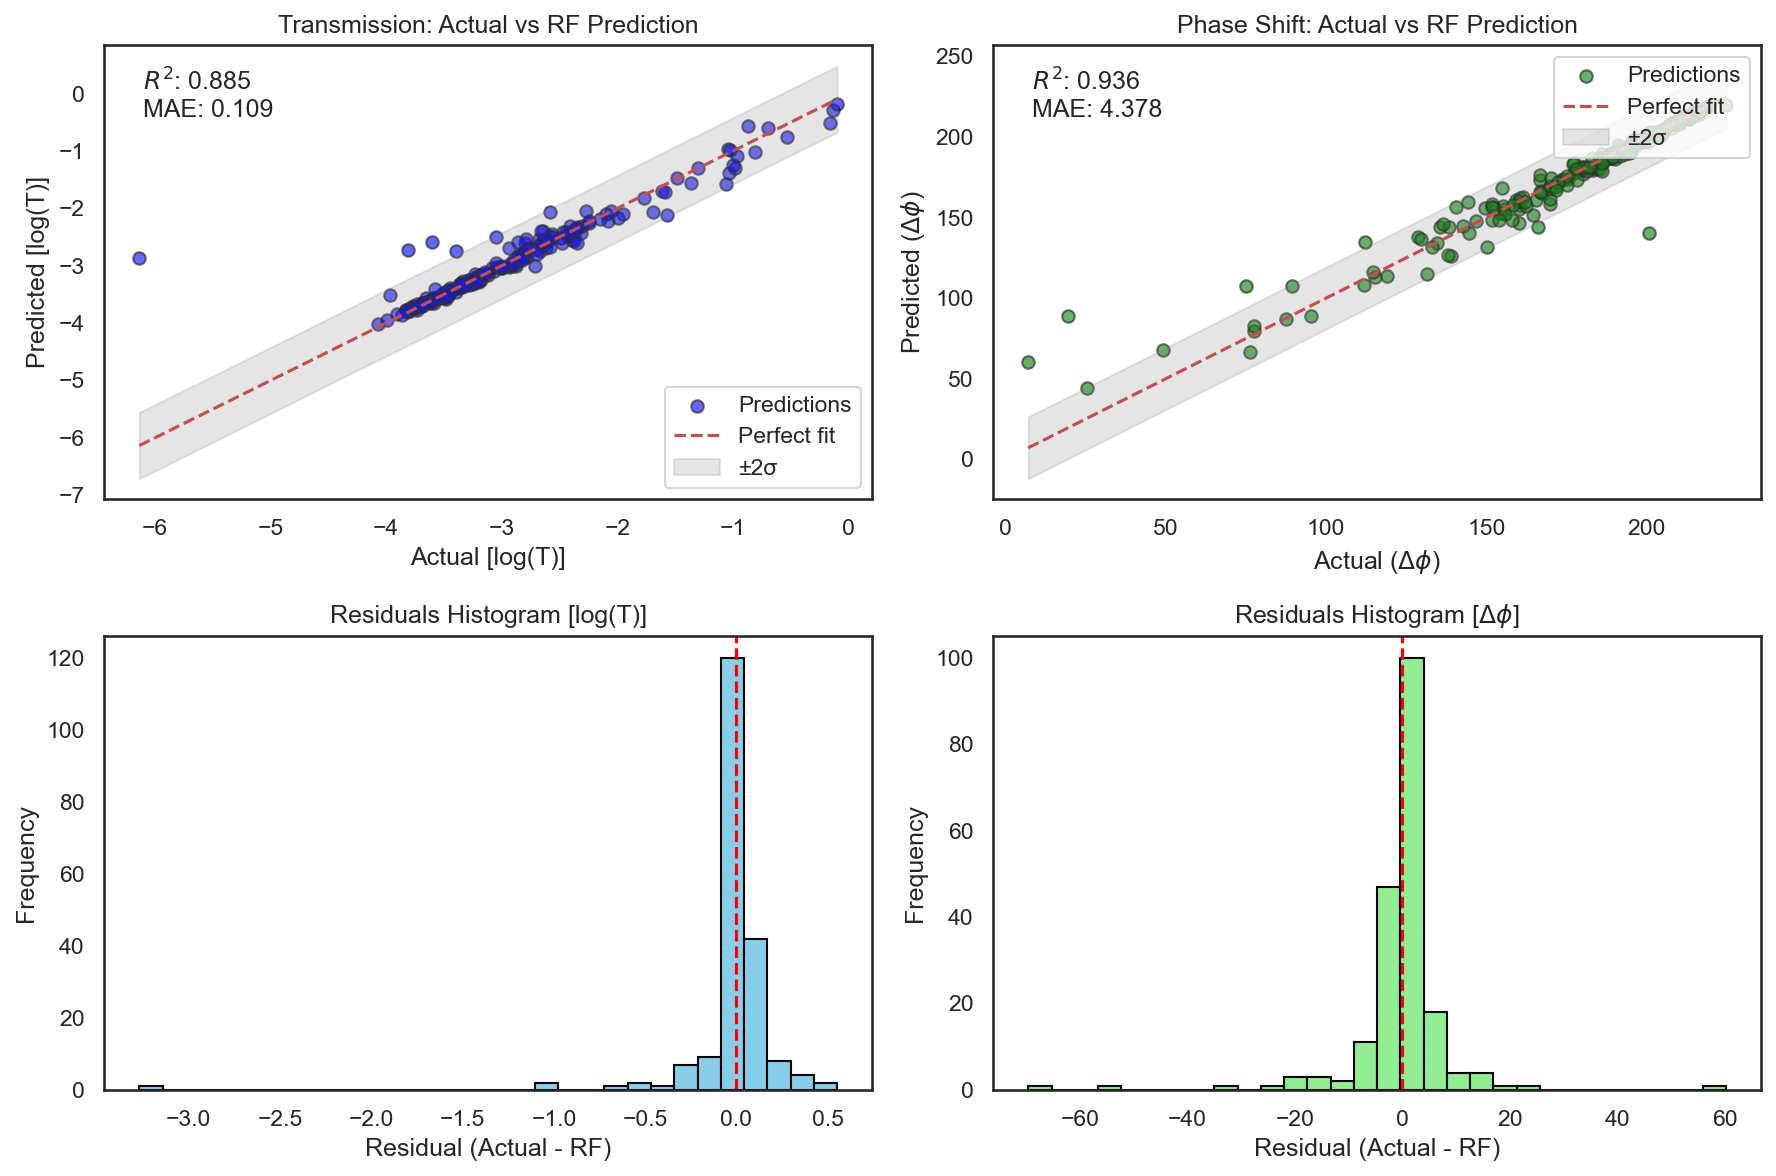

In [34]:

mae_T = mean_absolute_error(y_T_test, y_pred_T_test)
mae_P = mean_absolute_error(y_P_test, y_pred_P_test)


# === Calculate Residuals ===
residuals_T = y_T_test - y_pred_T_test
residuals_P = y_P_test - y_pred_P_test

std_T = np.std(residuals_T)
std_P = np.std(residuals_P)

# === Metrics ===
r2_T = r2_score(y_T_test, y_pred_T_test)
mae_T = mean_absolute_error(y_T_test, y_pred_T_test)

r2_P = r2_score(y_P_test, y_pred_P_test)
mae_P = mean_absolute_error(y_P_test, y_pred_P_test)

# === Create Figure ===
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=150)

# === Plot 1a: Scatter + PI for Transmission ===
axs[0, 0].scatter(y_T_test, y_pred_T_test, alpha=0.6, edgecolor='k', color='blue', label="Predictions")
line_T = np.linspace(y_T_test.min(), y_T_test.max(), 100)
axs[0, 0].plot(line_T, line_T, 'r--', label="Perfect fit")
axs[0, 0].fill_between(line_T, line_T - 2*std_T, line_T + 2*std_T, color='gray', alpha=0.2, label="±2σ")

axs[0, 0].set_title("Transmission: Actual vs RF Prediction")
axs[0, 0].set_xlabel("Actual [log(T)]")
axs[0, 0].set_ylabel("Predicted [log(T)]")
axs[0, 0].legend()
axs[0, 0].text(
    0.05, 0.95,
    f"$R^2$: {r2_T:.3f}\nMAE: {mae_T:.3f}",
    transform=axs[0, 0].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# === Plot 1b: Residuals Histogram for Transmission ===
axs[1, 0].hist(residuals_T, bins=30, color='skyblue', edgecolor='black')
axs[1, 0].axvline(0, color='red', linestyle='--')
axs[1, 0].set_title("Residuals Histogram [log(T)]")
axs[1, 0].set_xlabel("Residual (Actual - RF)")
axs[1, 0].set_ylabel("Frequency")

# === Plot 2a: Scatter + PI for Phase Shift ===
axs[0, 1].scatter(y_P_test, y_pred_P_test, alpha=0.6, edgecolor='k', color='green', label="Predictions")
line_P = np.linspace(y_P_test.min(), y_P_test.max(), 100)
axs[0, 1].plot(line_P, line_P, 'r--', label="Perfect fit")
axs[0, 1].fill_between(line_P, line_P - 2*std_P, line_P + 2*std_P, color='gray', alpha=0.2, label="±2σ")

axs[0, 1].set_title("Phase Shift: Actual vs RF Prediction")
axs[0, 1].set_xlabel(r"Actual ($\Delta\phi$)")
axs[0, 1].set_ylabel(r"Predicted ($\Delta\phi$)")
axs[0, 1].legend(loc='upper right')
axs[0, 1].text(
    0.05, 0.95,
    f"$R^2$: {r2_P:.3f}\nMAE: {mae_P:.3f}",
    transform=axs[0, 1].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# === Plot 2b: Residuals Histogram for Phase Shift ===
axs[1, 1].hist(residuals_P, bins=30, color='lightgreen', edgecolor='black')
axs[1, 1].axvline(0, color='red', linestyle='--')
axs[1, 1].set_title(r"Residuals Histogram [$\Delta\phi$]")
axs[1, 1].set_xlabel("Residual (Actual - RF)")
axs[1, 1].set_ylabel("Frequency")

# === Final Layout ===
plt.tight_layout()
plt.savefig("rf_actual_vs_pred_with_residuals.pdf", format='pdf')
plt.show()

In [35]:
# Baseline model
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_T_train)

# Predictions
y_pred_dummy = dummy.predict(X_test)

# Compare
baseline_mae = mean_absolute_error(y_T_test, y_pred_dummy)
baseline_medae = median_absolute_error(y_T_test, y_pred_dummy)
print(f"Baseline MAE (T): {baseline_mae:.3f}")
print(f"Baseline MedAE (T): {baseline_medae:.3f}")

Baseline MAE (T): 0.660
Baseline MedAE (T): 0.552


In [36]:
# Baseline model
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_P_train)

# Predictions
y_pred_dummy = dummy.predict(X_test)

# Compare
baseline_mae = mean_absolute_error(y_P_test, y_pred_dummy)
baseline_medae = median_absolute_error(y_T_test, y_pred_dummy)
print(f"Baseline MAE (P): {baseline_mae:.3f}")
print(f"Baseline MedAE (P): {baseline_medae:.3f}")

Baseline MAE (P): 27.698
Baseline MedAE (P): 178.596


 99%|===================| 785/796 [00:40<00:00]        

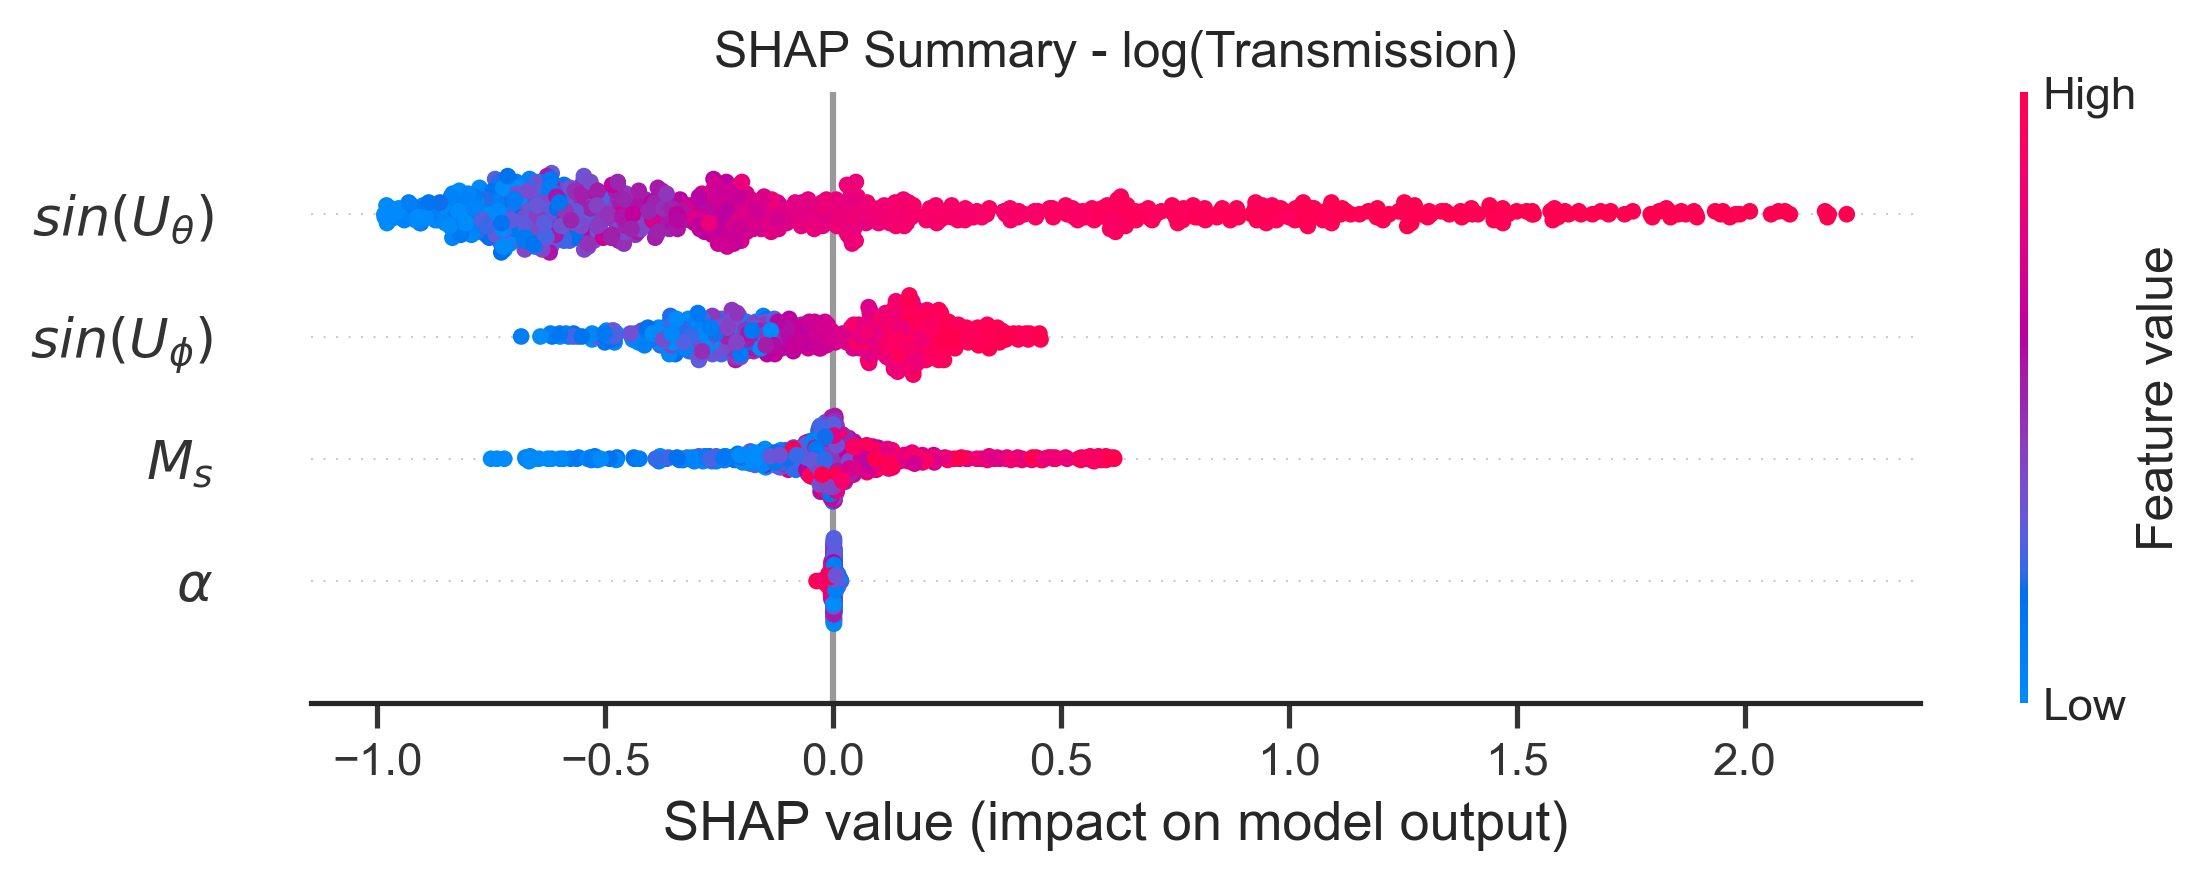

In [37]:

# =======================
# 🧠 EXPLICABILIDAD - SHAP
# =======================
'''
## OLD API:
# Transmission
explainer_T = shap.TreeExplainer(rf_T, X_train)
shap_values_T = explainer_T.shap_values(X_train)

# Phase Shift
explainer_P = shap.TreeExplainer(rf_P, X_train)
shap_values_P = explainer_P.shap_values(X_train)
'''
## NEW API:
# Transmission
explainer_T = shap.Explainer(rf_T, X_train)
shap_values_T = explainer_T(X_train)

# Phase Shift
explainer_P = shap.Explainer(rf_P, X_train)
shap_values_P = explainer_P(X_train)

# =========================
# 📈 SHAP - PLOTS GLOBALES
# =========================

# Summary Plot Transmission
shap.summary_plot(shap_values_T, X_train, show=False)
plt.title("SHAP Summary - log(Transmission)")
plt.tight_layout()
plt.savefig("SHAP_summary_logT.pdf", format='pdf')
plt.show()


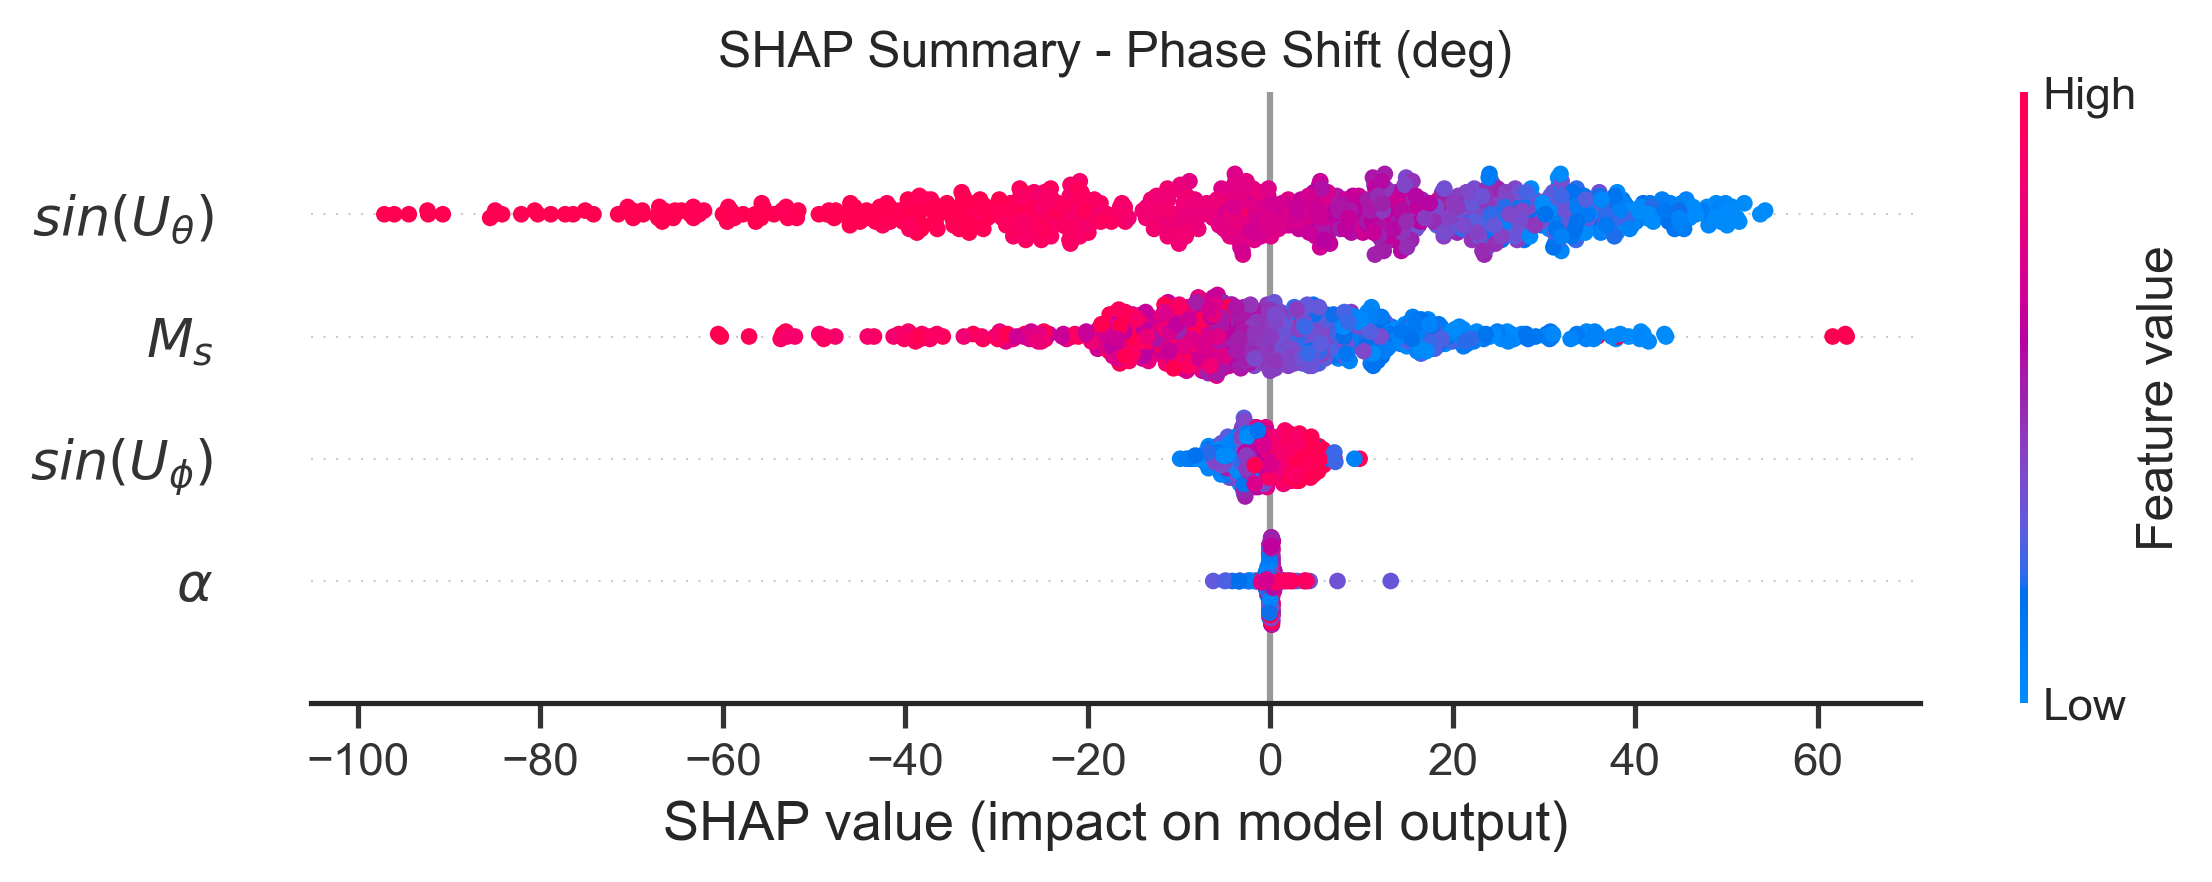

In [38]:
# Summary Plot Phase Shift
shap.summary_plot(shap_values_P, X_train, show=False)
plt.title("SHAP Summary - Phase Shift (deg)")
plt.tight_layout()
plt.savefig("SHAP_summary_PS.pdf", format='pdf')
plt.show()


In [39]:

# ======================================
# 🔍 SHAP DEPENDENCE PLOTS (VARIABLES CLAVE)
# ======================================

# Ajusta los nombres a tus variables físicas reales
shap.dependence_plot(r"$M_s$", shap_values_T, X_train)
shap.dependence_plot(r"$\alpha$", shap_values_P, X_train)


TypeError: loop of ufunc does not support argument 0 of type Explanation which has no callable conjugate method

In [40]:
type(shap_values_T)

shap._explanation.Explanation

C:\Users\david.osuna\AppData\Local\anaconda3\envs\ubermag\lib\site-packages\shap\utils\_clustering.py:273: UserWarning: Ignoring the y argument passed to shap.utils.hclust since the given clustering metric is not based on label fitting!
  warnings.warn(


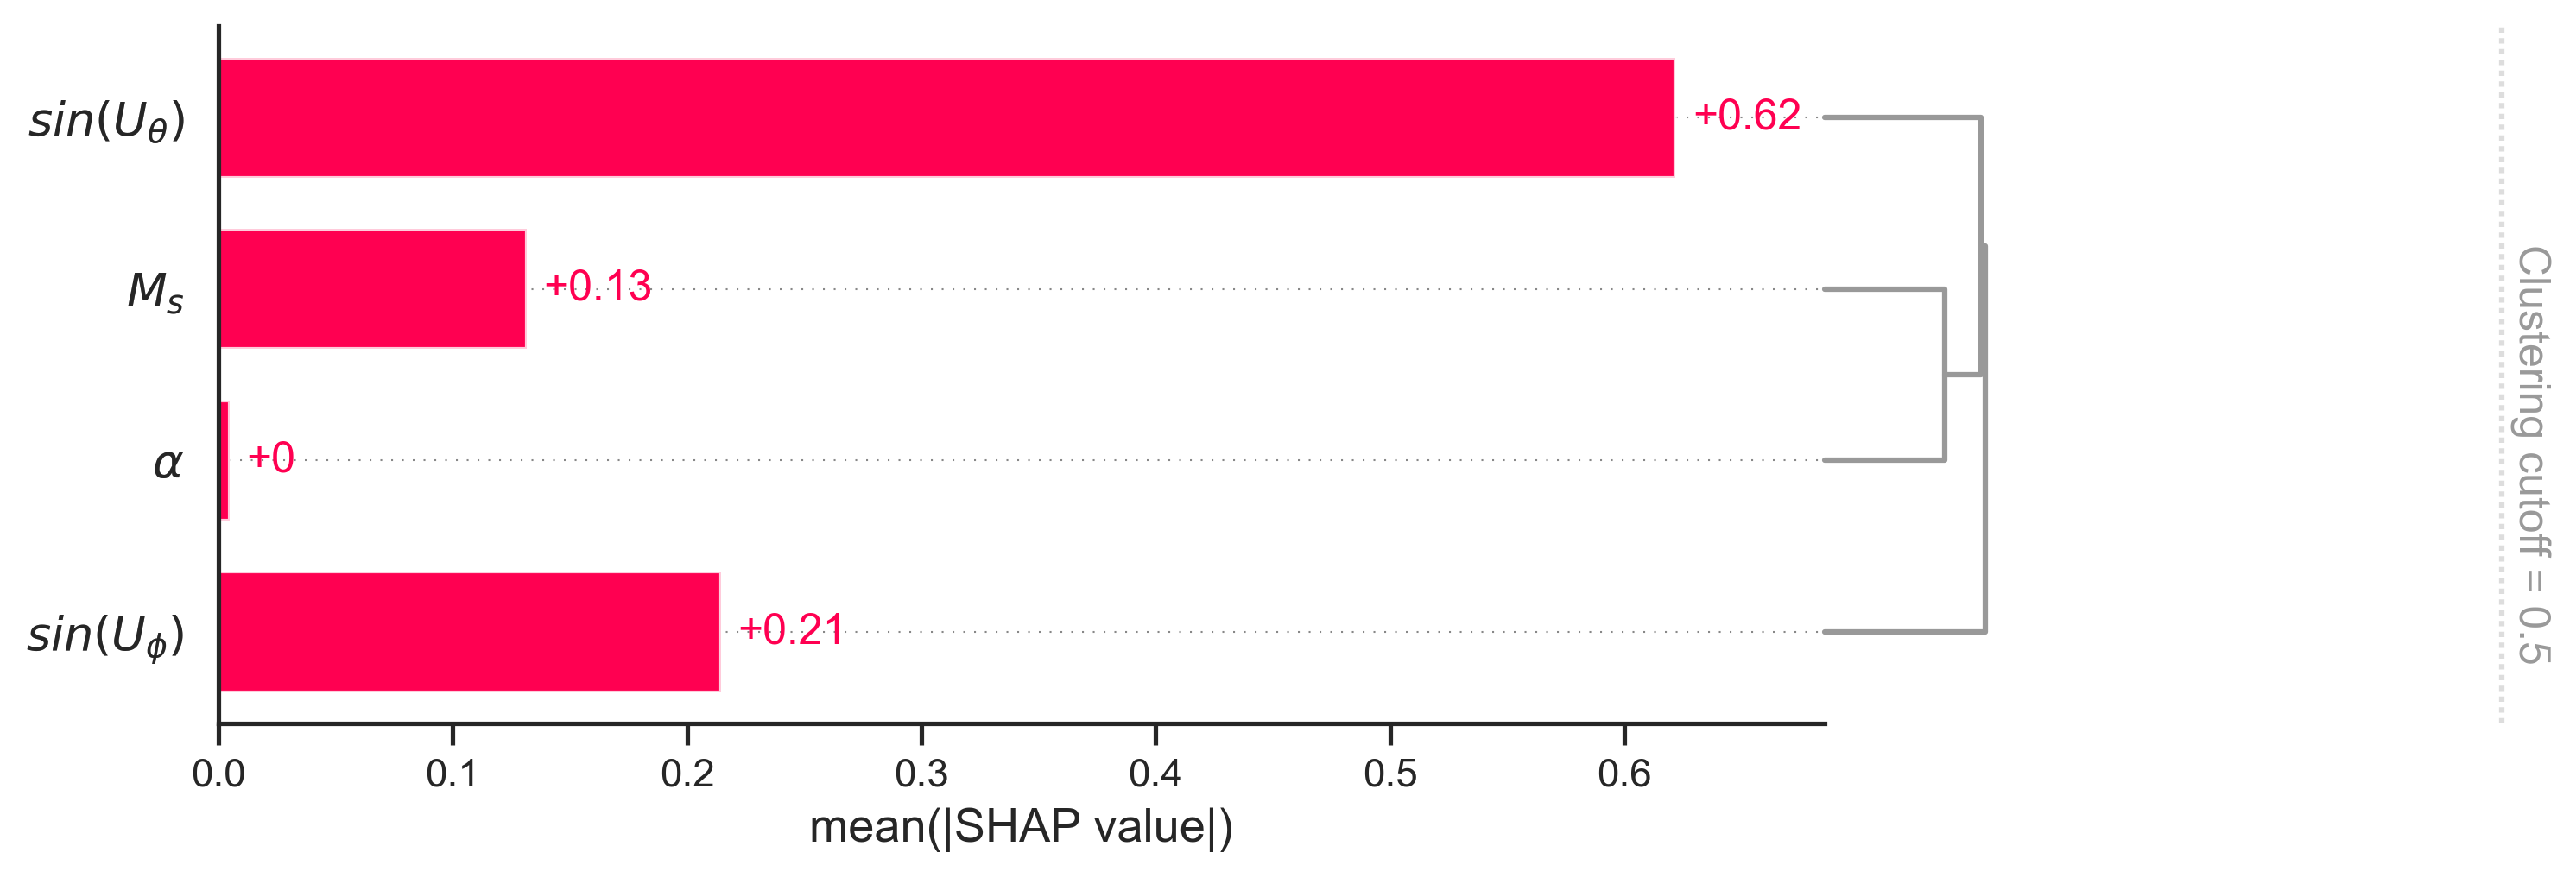

<Figure size 1800x1200 with 0 Axes>

In [41]:
clust_T = shap.utils.hclust(X_train, y_T_scaled, linkage="single", metric="cosine")  # agrupados por correlación, que es válida métrica para cualquier cmodelo
plt.figure(figsize=(10, 6))  # Wider figure to fit the dendrogram
shap.plots.bar(shap_values_T, clustering=clust_T, clustering_cutoff=0.5)
plt.tight_layout()
fig.savefig("SHAP_cluster_logT.pdf", format='pdf')
plt.show()


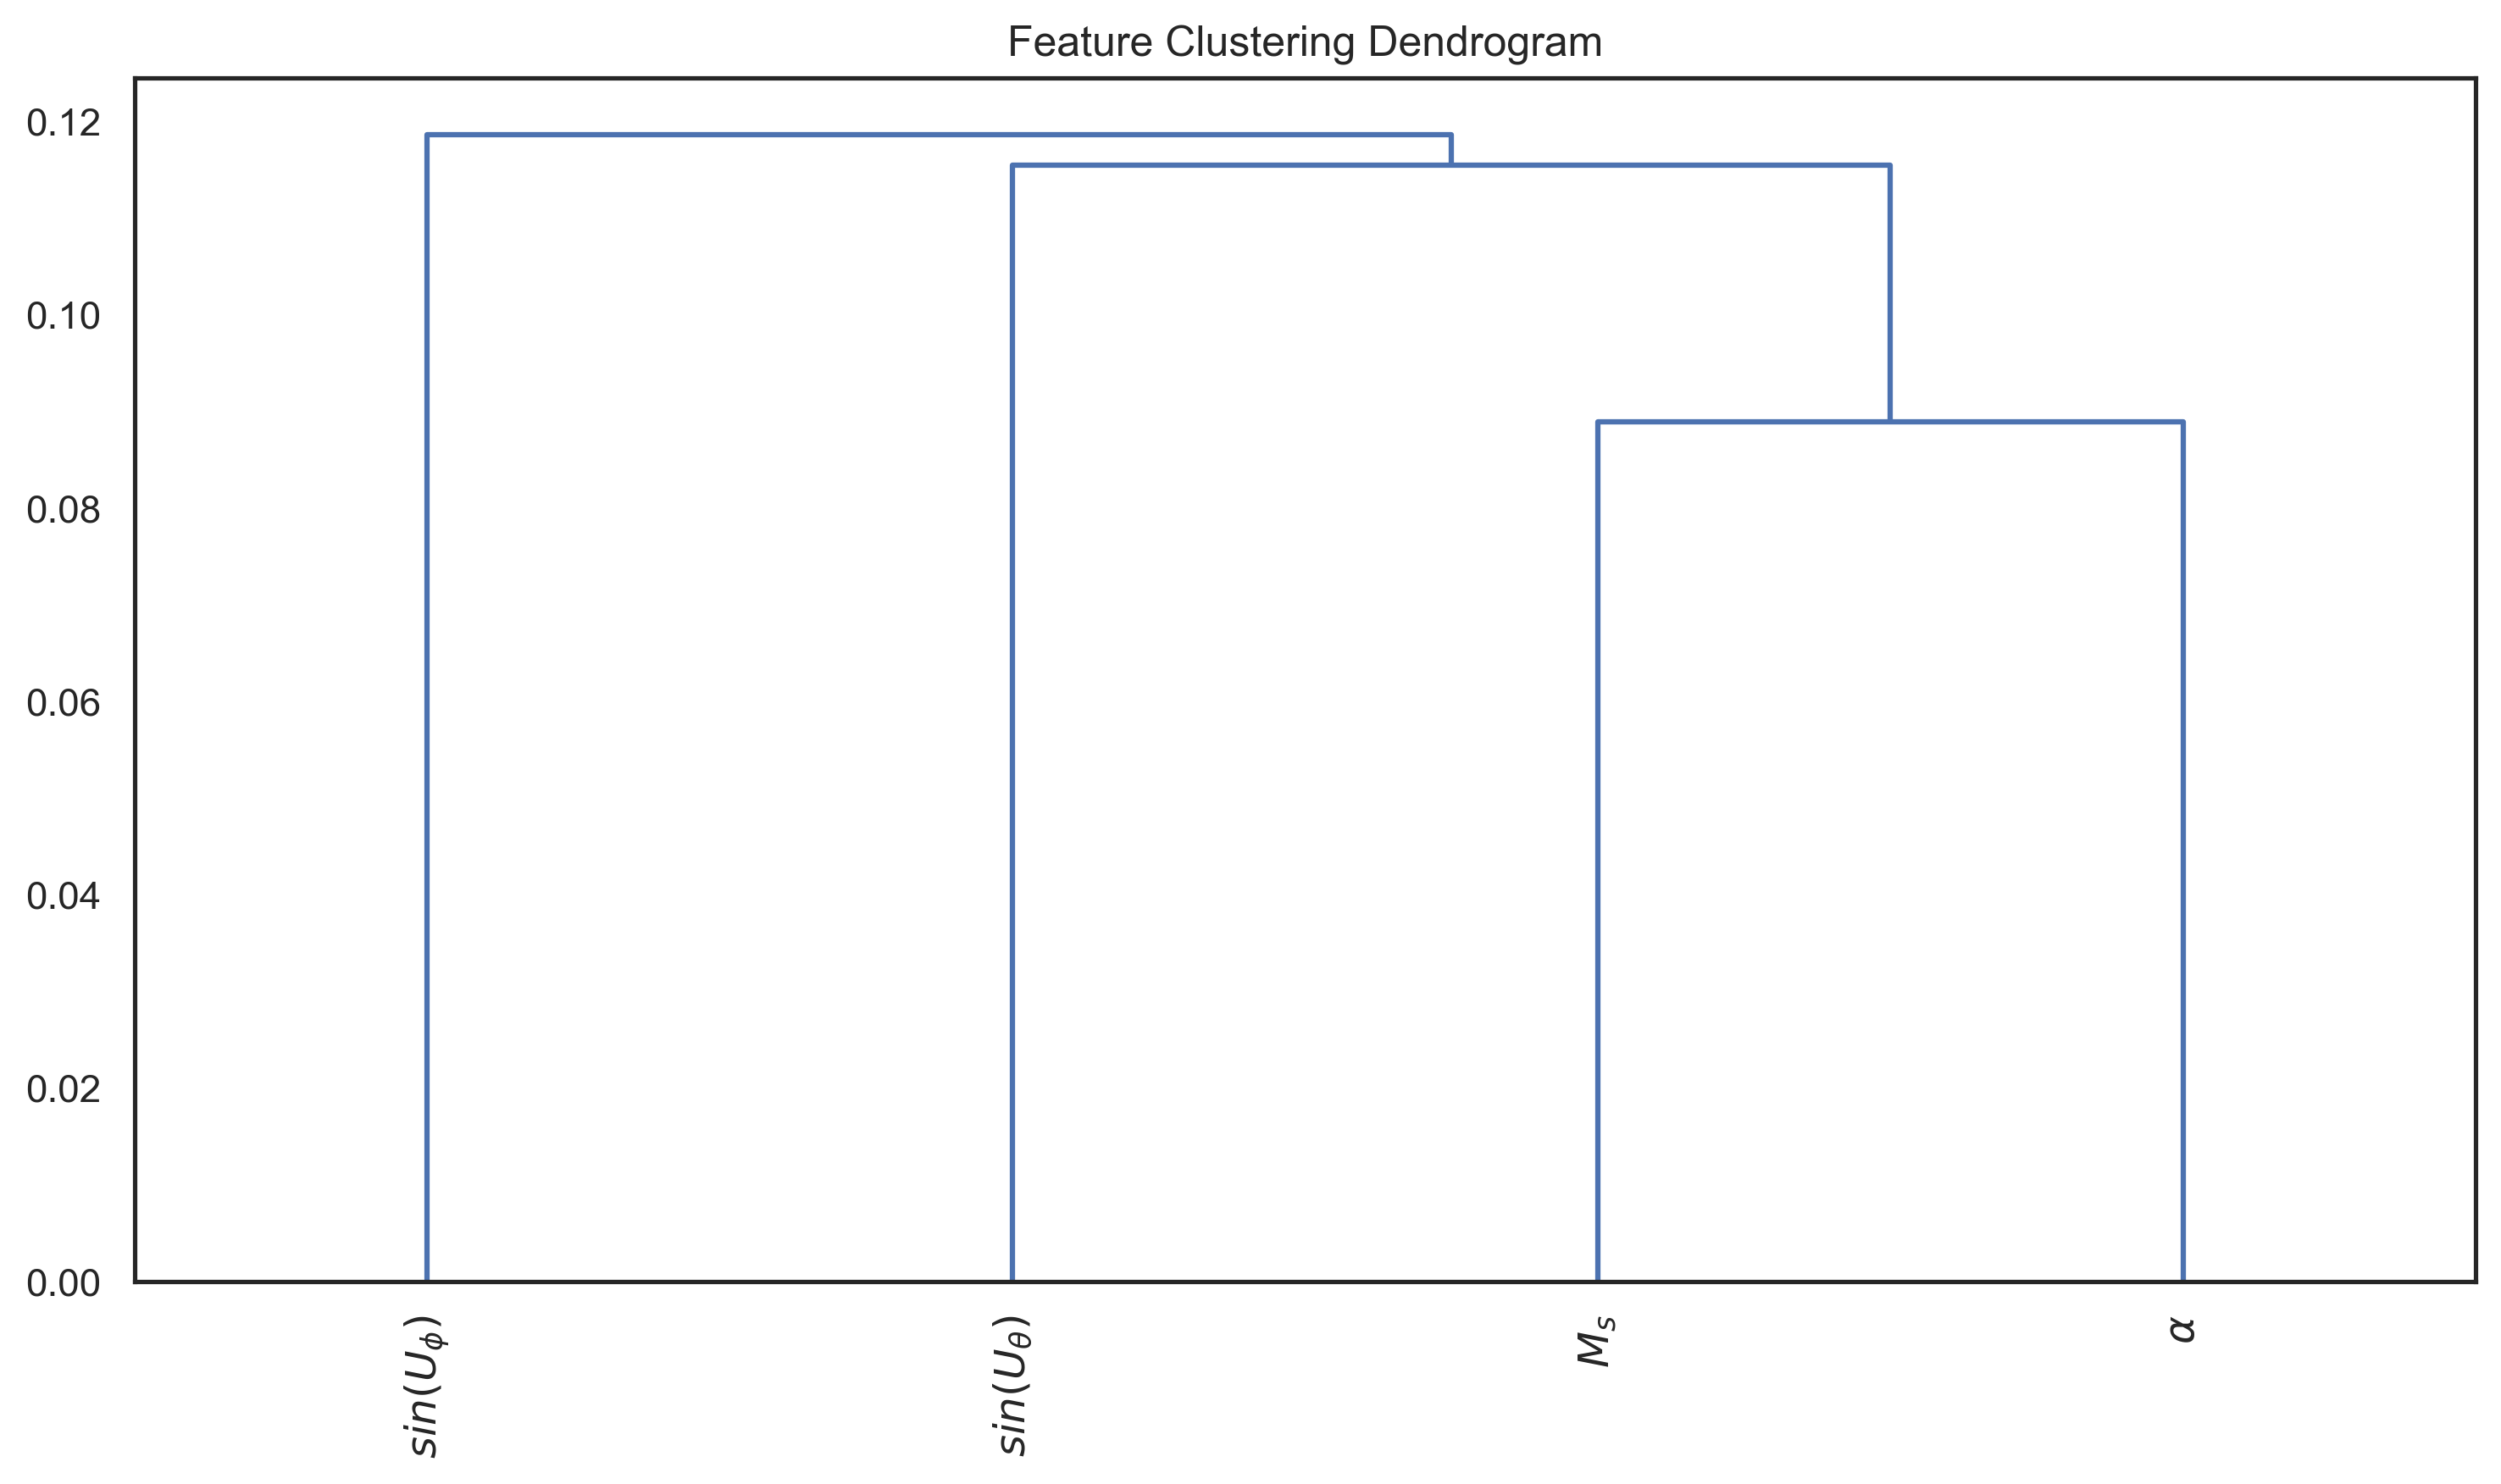

In [42]:
# clust is a tuple: (linkage_matrix, feature_order)
linkage_matrix_T = clust_T

# Create dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_T, labels=X_train.columns.to_list(), leaf_rotation=90)

plt.title("Feature Clustering Dendrogram")
plt.tight_layout()
plt.savefig("dendrogram_features_T.pdf")
plt.show()

C:\Users\david.osuna\AppData\Local\anaconda3\envs\ubermag\lib\site-packages\shap\utils\_clustering.py:273: UserWarning: Ignoring the y argument passed to shap.utils.hclust since the given clustering metric is not based on label fitting!
  warnings.warn(


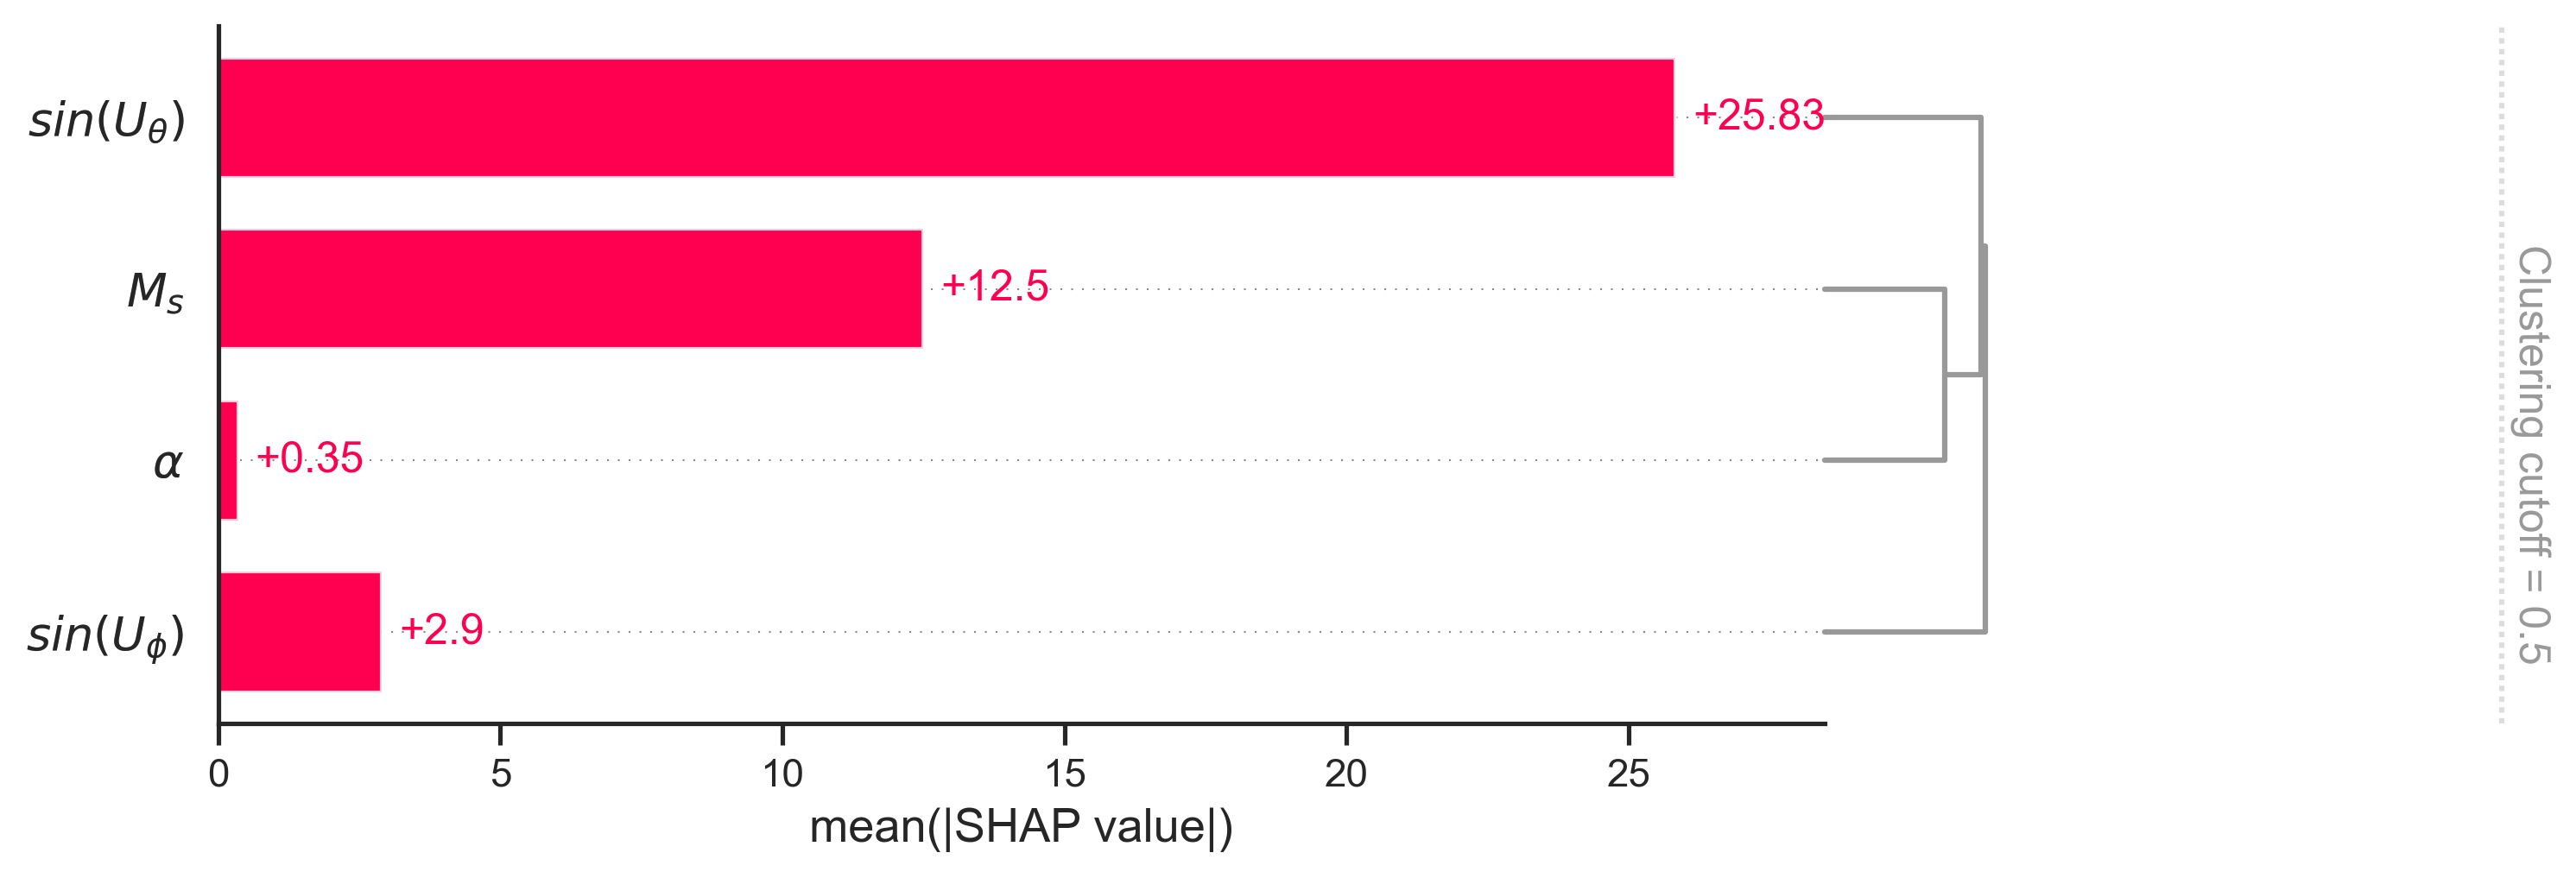

<Figure size 1800x1200 with 0 Axes>

In [43]:
clust_P = shap.utils.hclust(X_train, y_P_scaled, linkage="single", metric="cosine")
plt.figure(figsize=(8, 6), dpi=300)
shap.plots.bar(shap_values_P, clustering=clust_P, clustering_cutoff=0.5)
plt.tight_layout()
plt.savefig("SHAP_cluster_PS.pdf", format='pdf')
plt.show()

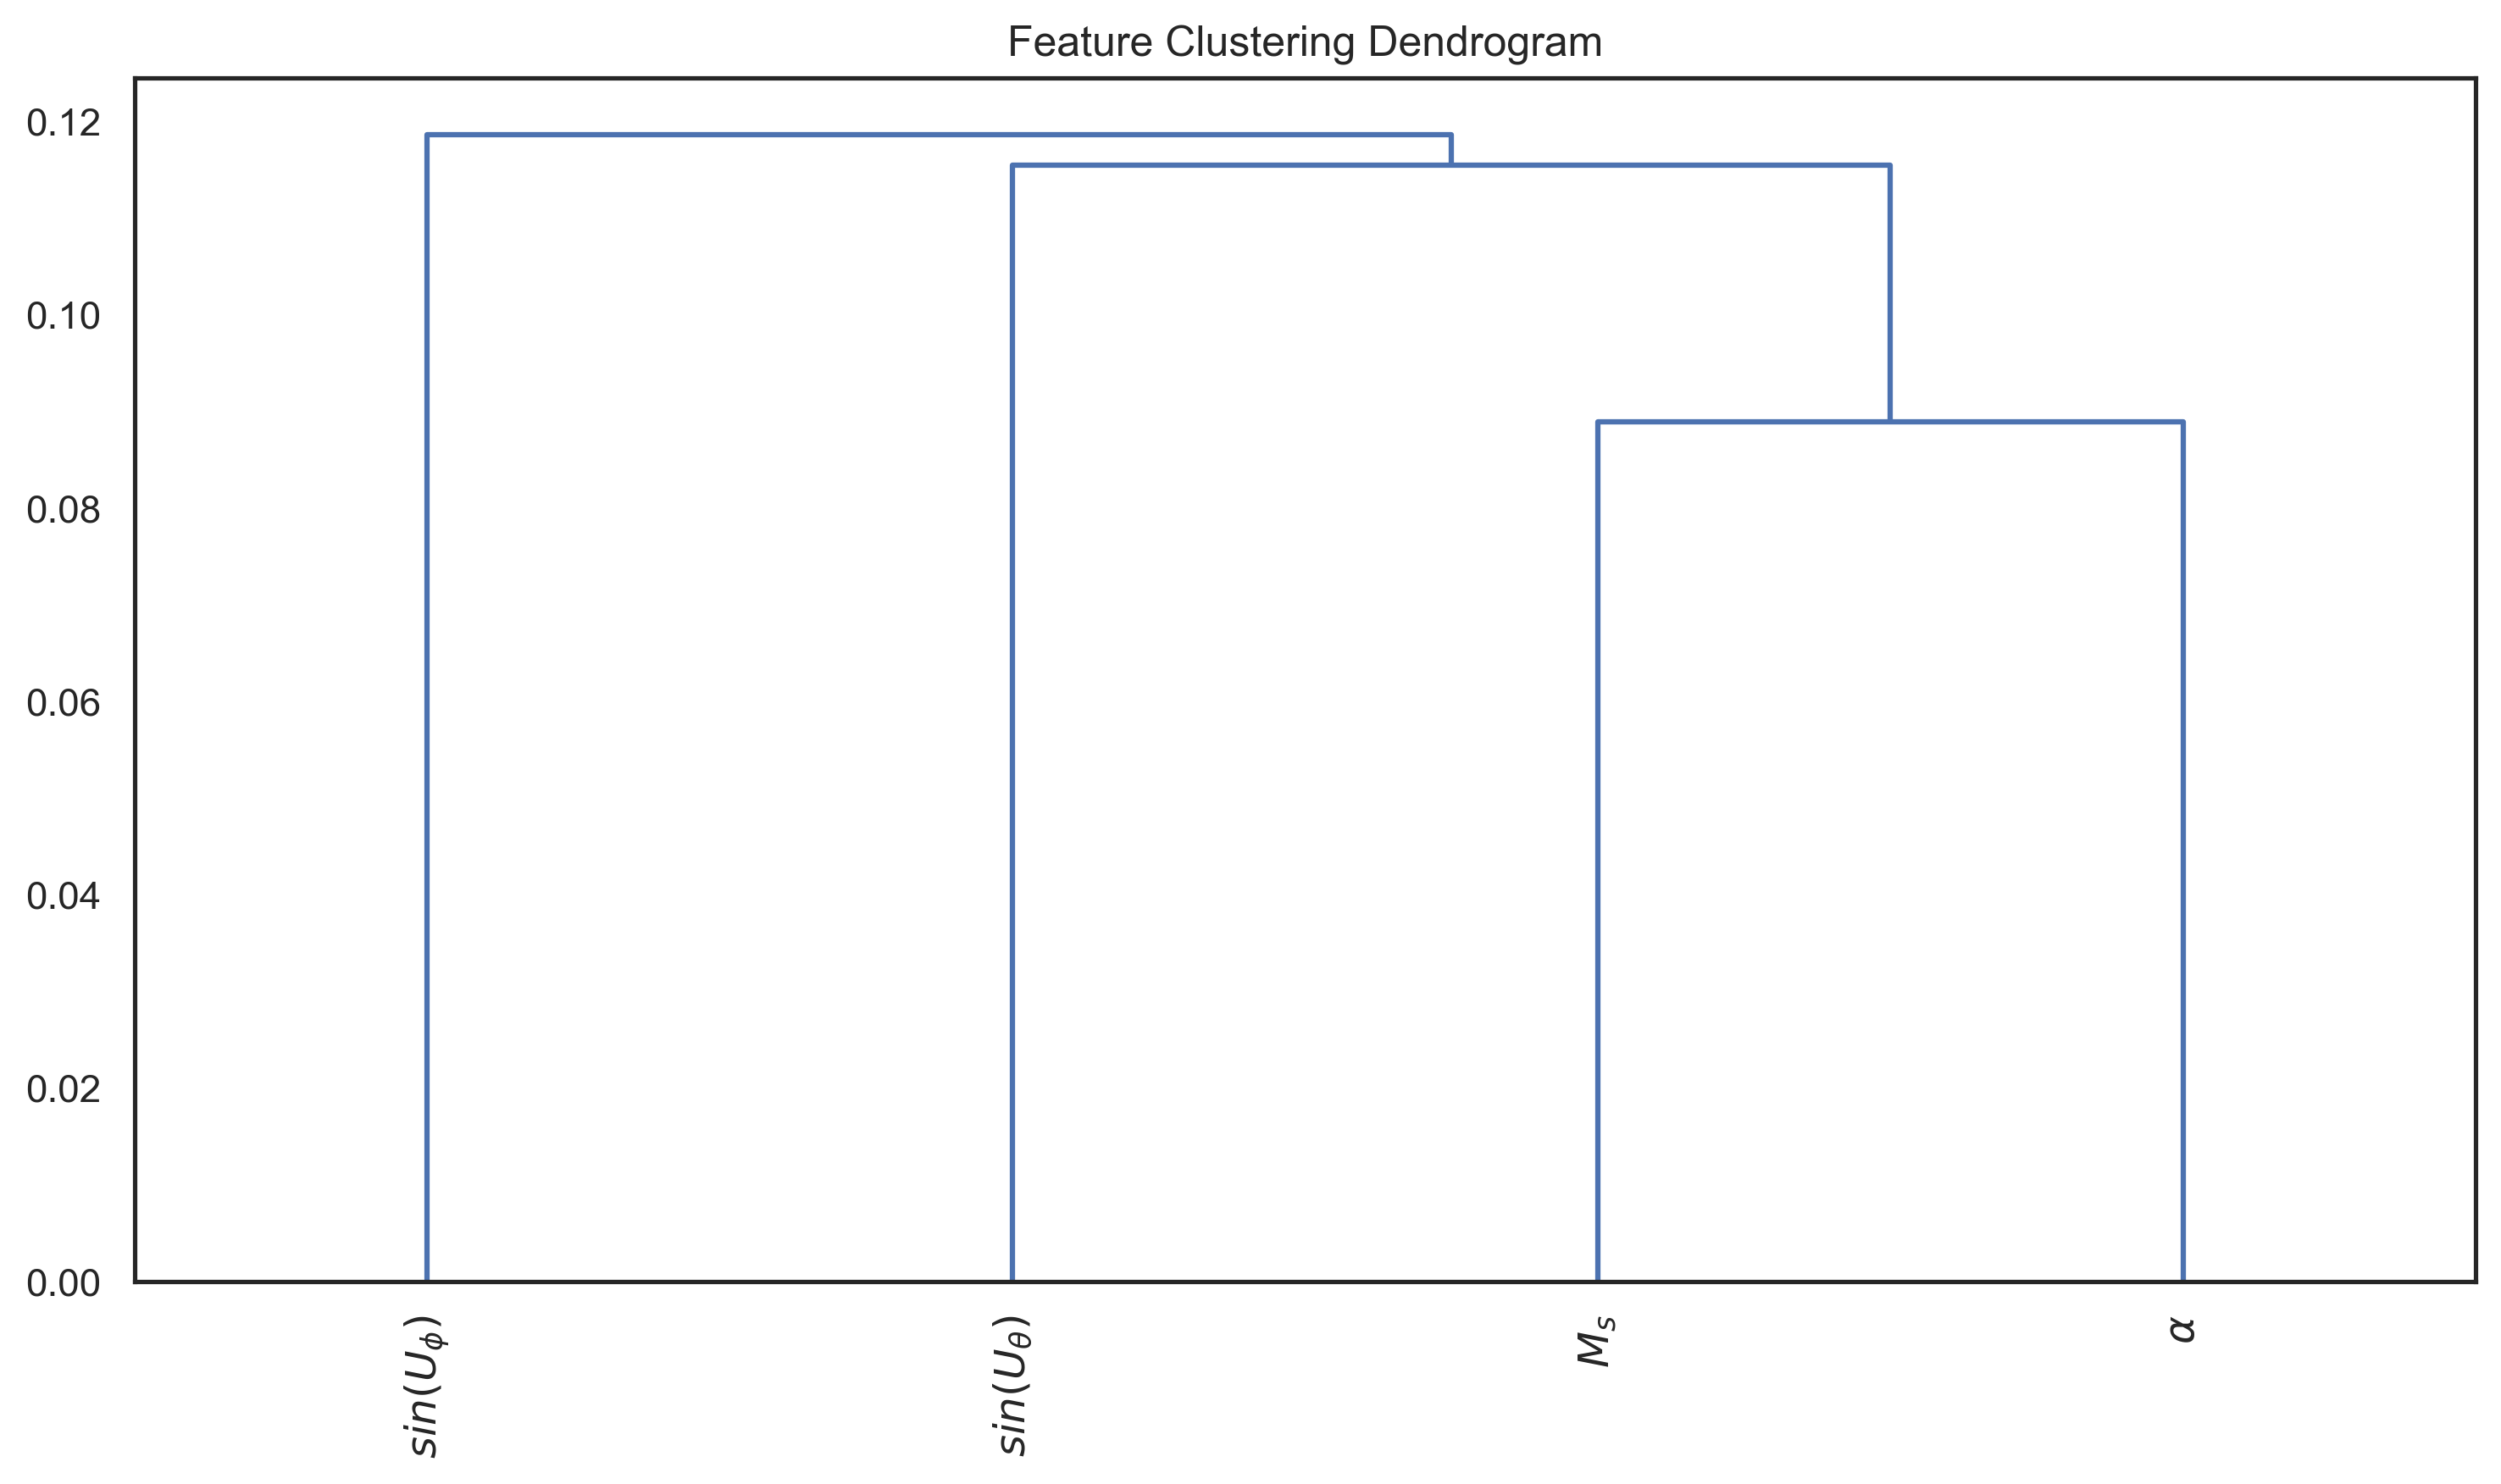

In [44]:
# clust is a tuple: (linkage_matrix, feature_order)
linkage_matrix_P = clust_P

# Create dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_P, labels=X_train.columns.to_list(), leaf_rotation=90)

plt.title("Feature Clustering Dendrogram")
plt.tight_layout()
plt.savefig("dendrogram_features_P.pdf")
plt.show()

In [45]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Generar las predicciones en el conjunto de entrenamiento
y_pred_T_train = rf_T.predict(X_train)
y_pred_P_train = rf_P.predict(X_train)

# Crear un modelo de regresión polinómica para ajustar las predicciones
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)

# Ajustar la regresión polinómica para Transmission (log(Transmission))
reg_T = LinearRegression()
reg_T.fit(X_poly, y_pred_T_train)  # Usar predicciones sobre el conjunto de entrenamiento

# Ajustar la regresión polinómica para Phase Shift
reg_P = LinearRegression()
reg_P.fit(X_poly, y_pred_P_train)  # Usar predicciones sobre el conjunto de entrenamiento

# Ver los coeficientes de la regresión polinómica
print("Coeficientes para log(Transmission):", reg_T.coef_)
print("Intercepto para log(Transmission):", reg_T.intercept_)

print("Coeficientes para Phase Shift:", reg_P.coef_)
print("Intercepto para Phase Shift:", reg_P.intercept_)

# Evaluar el modelo de regresión polinómica sobre el conjunto de prueba
y_pred_poly_T = reg_T.predict(poly.transform(X_test))
y_pred_poly_P = reg_P.predict(poly.transform(X_test))

r2_poly_T = r2_score(y_T_test, y_pred_poly_T)
r2_poly_P = r2_score(y_P_test, y_pred_poly_P)

print(f"R² para Transmission (con Regresión Polinómica): {r2_poly_T:.3f}")
print(f"R² para Phase Shift (con Regresión Polinómica): {r2_poly_P:.3f}")



Coeficientes para log(Transmission): [-2.50953370e-09 -1.73885272e-05  1.73449612e-09 -9.68836647e-10
 -3.64778588e-09  2.18148651e-10  5.92250560e-05 -2.47461276e-05
 -6.25925827e-06  1.37847062e-10  2.13181905e-09  1.70235543e-09
  2.47395684e-09 -5.60168671e-09 -2.69880019e-09 -5.88555325e-16
 -2.64263061e-09 -8.53576391e-11 -1.35823047e-11  1.89590101e-06
  8.60613559e-05  7.63239585e-05  5.24426208e-05  1.01542591e-06
  1.38827879e-05  1.31179372e-12  5.24544010e-11  4.73311548e-11
  1.54142877e-09  1.26188794e-09  1.34217174e-09  6.63174730e-09
 -2.21081186e-09 -3.69652496e-09 -1.67614348e-09]
Intercepto para log(Transmission): -3.105940565624344
Coeficientes para Phase Shift: [ 7.53122099e-08  1.41338920e-03 -5.29823526e-08  7.13549066e-09
  1.09561051e-07 -2.92787951e-08 -1.79580620e-03  5.90893478e-04
  7.06587589e-04 -3.14253969e-09 -6.14595974e-08 -5.20527358e-08
 -9.44310785e-08  1.55163038e-07  8.31069107e-08  1.60768439e-13
  8.35546500e-08  8.58428152e-10 -6.49676213e-09

In [46]:
# Evaluación del modelo de regresión polinómica
y_pred_poly_T = reg_T.predict(poly.transform(X_test))
y_pred_poly_P = reg_P.predict(poly.transform(X_test))

r2_poly_T = r2_score(y_T_test, y_pred_poly_T)
r2_poly_P = r2_score(y_P_test, y_pred_poly_P)

print(f"R² para Transmission (con Regresión Polinómica): {r2_poly_T:.3f}")
print(f"R² para Phase Shift (con Regresión Polinómica): {r2_poly_P:.3f}")


R² para Transmission (con Regresión Polinómica): 0.727
R² para Phase Shift (con Regresión Polinómica): 0.853


Index(['$M_s$', '$\alpha$', '$sin(U_\theta)$', '$sin(U_\phi)$'], dtype='object')


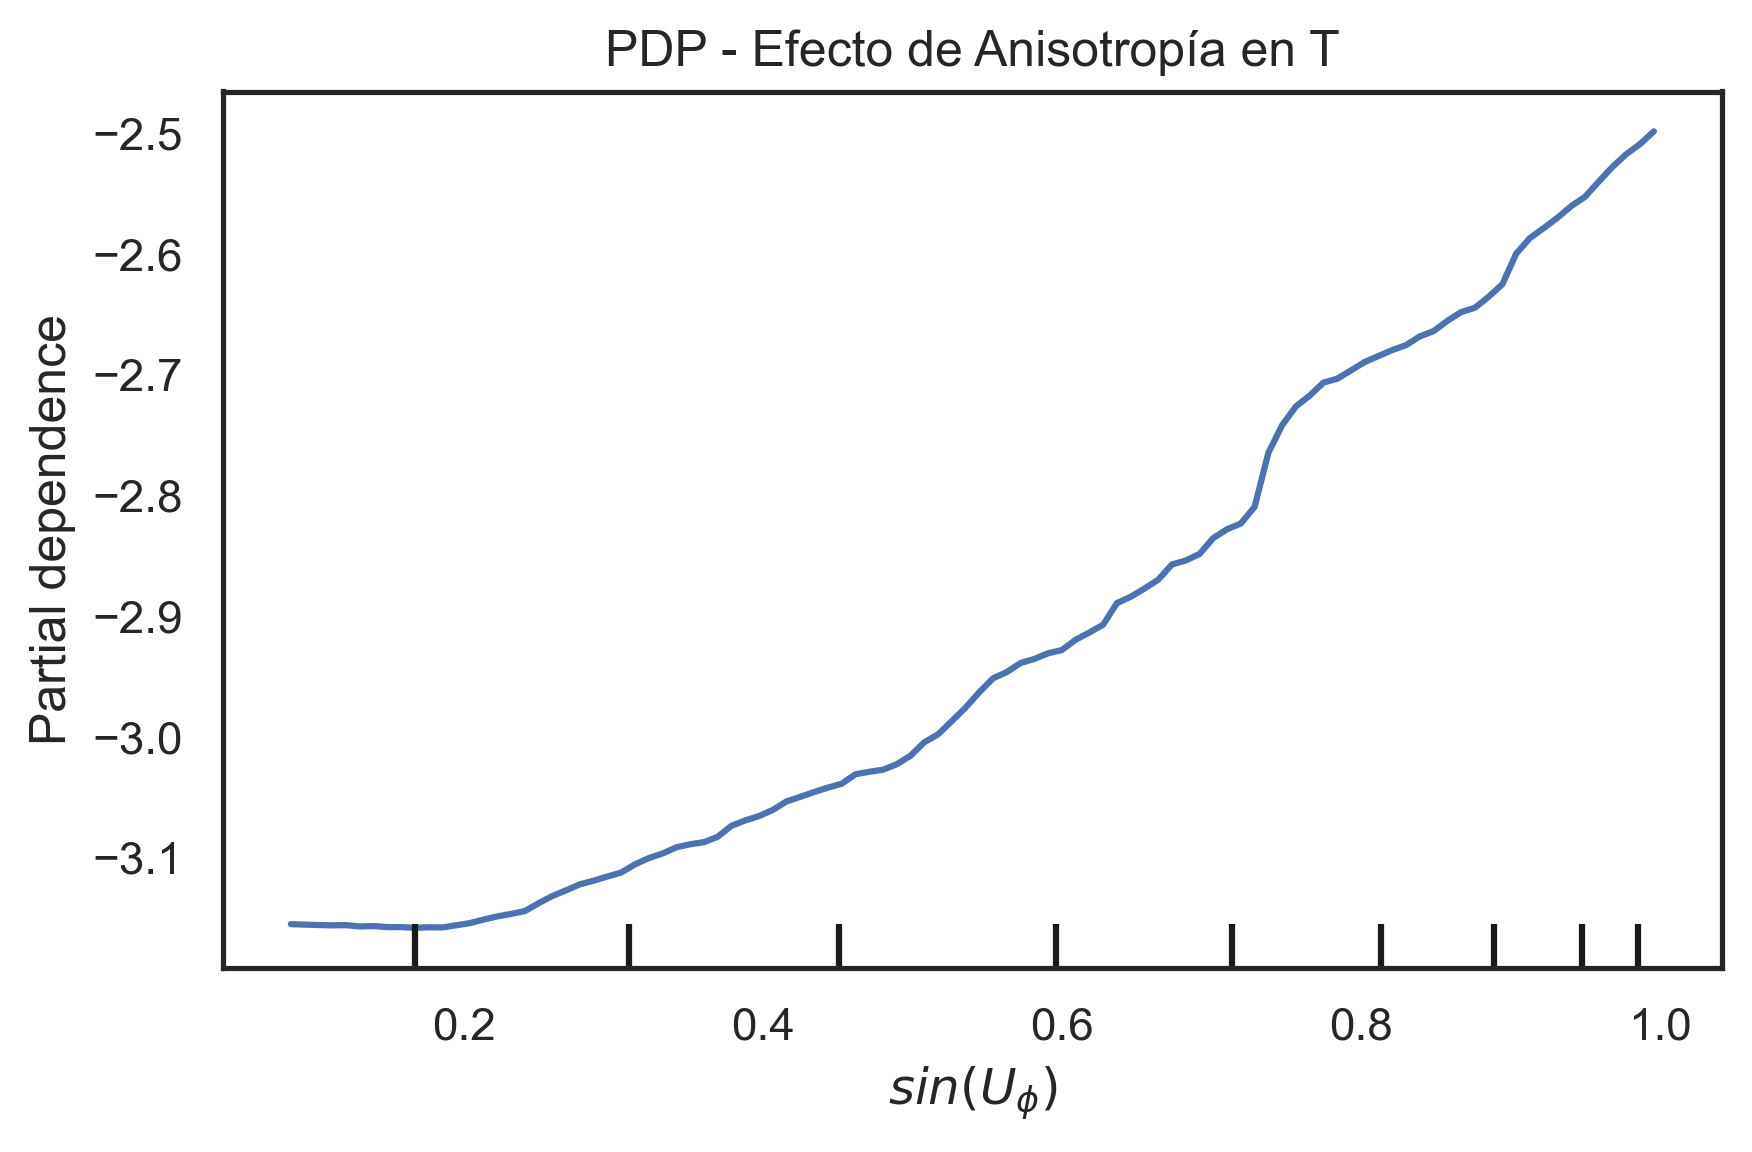

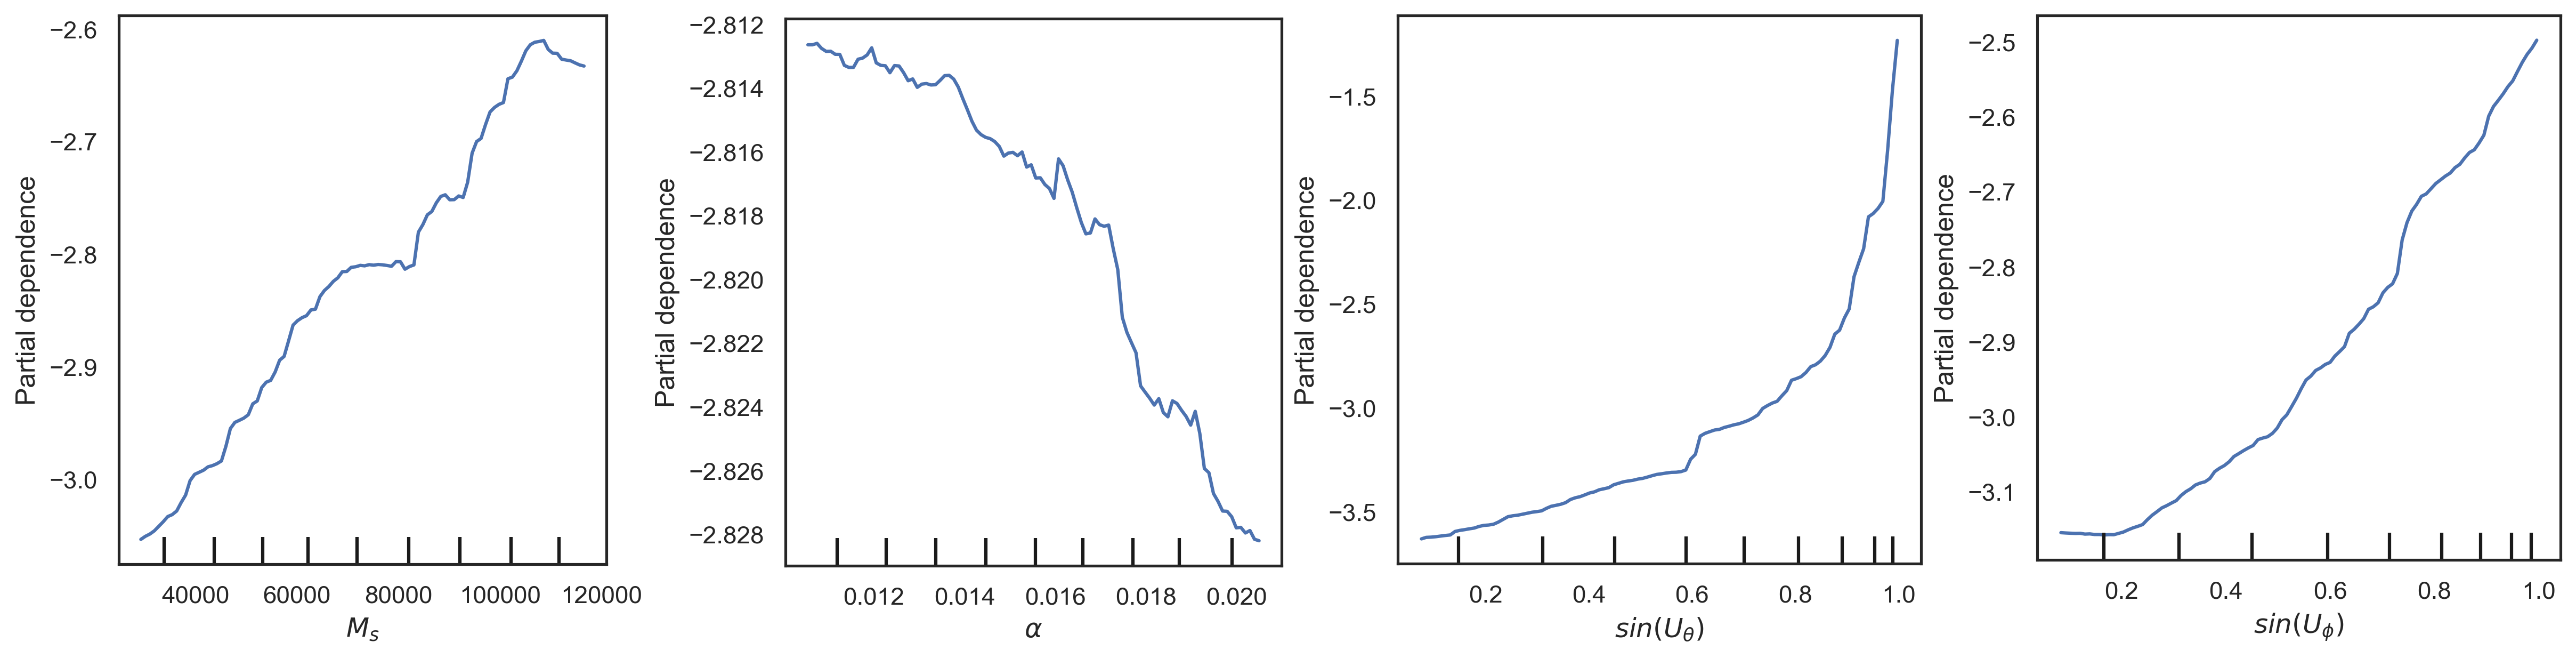

In [47]:

'''
# Gráfico SHAP para la variable T
plt.figure()
shap.summary_plot(shap_values[:, :, 0], X_train, show=False)
plt.title("SHAP values para T (Transmisión)")
plt.tight_layout()
'''
print(X_train.columns)

# PDP para 'Damping' sobre T
fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(rf_T, X_train, features=[r'$sin(U_\phi)$'], target=0, ax=ax)
plt.title("PDP - Efecto de Anisotropía en T")
plt.tight_layout()
plt.show()

# Other PDP for all variables.
# --- List of features to plot ---
features = [r'$M_s$', r'$\alpha$', r'$sin(U_\theta)$', r'$sin(U_\phi)$']  # ← replace with your actual feature names

# 1x4 subplots with square plots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300, sharey=True, constrained_layout=True)
axes = axes.flatten()

# Plot Partial Dependence for each feature
for i, (ax, feature) in enumerate(zip(axes, features)):
    PartialDependenceDisplay.from_estimator(rf_T, X_train, features=[feature], ax=ax)
    ax.set_title(f"PDP - {feature}", fontsize=11)
    ax.set_ylim(-1,1)
    if i != 0:
        ax.set_ylabel("")         # Remove y-axis label from other subplots
        ax.tick_params(labelleft=False)  # Hide y-axis tick labels on others

# Save before show (or after if not clearing the figure)
fig.savefig("PDPs.pdf", format='pdf')
plt.show()

In [48]:

# Ajustar una regresión polinómica (grado 2) sobre las predicciones de Random Forest para T
y_pred_rf_T = rf_T.predict(X_train)  # Solo T

poly_model_T = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model_T.fit(X_train, y_pred_rf_T)

# Obtener fórmula
linreg = poly_model_T.named_steps['linearregression']
poly = poly_model_T.named_steps['polynomialfeatures']
coefs = linreg.coef_
intercept = linreg.intercept_
feature_names = poly.get_feature_names_out(X_train.columns)

# Combinar en una fórmula tipo string
formula_terms = [f"{coef:.3f}*{name}" for coef, name in zip(coefs, feature_names)]
formula = " + ".join(formula_terms)
full_formula = f"T ≈ {intercept:.3f} + " + formula

full_formula[:600]  # Preview the formula (limited chars for clarity)


'T ≈ -2.417 + 0.000*1 + -0.000*$M_s$ + 0.639*$\\alpha$ + -3.958*$sin(U_\\theta)$ + -1.250*$sin(U_\\phi)$ + -0.000*$M_s$^2 + -0.000*$M_s$ $\\alpha$ + 0.000*$M_s$ $sin(U_\\theta)$ + 0.000*$M_s$ $sin(U_\\phi)$ + 0.021*$\\alpha$^2 + -1.565*$\\alpha$ $sin(U_\\theta)$ + 2.960*$\\alpha$ $sin(U_\\phi)$ + 3.856*$sin(U_\\theta)$^2 + 0.161*$sin(U_\\theta)$ $sin(U_\\phi)$ + 0.960*$sin(U_\\phi)$^2'

In [49]:
# Ajustar una regresión polinómica (grado 2) sobre las predicciones de Random Forest para P
y_pred_rf_P = rf_P.predict(X_train)  # Solo T

poly_model_P = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model_P.fit(X_train, y_pred_rf_P)

# Obtener fórmula
linreg = poly_model_P.named_steps['linearregression']
poly = poly_model_P.named_steps['polynomialfeatures']
coefs = linreg.coef_
intercept = linreg.intercept_
feature_names = poly.get_feature_names_out(X_train.columns)

# Combinar en una fórmula tipo string
formula_terms = [f"{coef:.3f}*{name}" for coef, name in zip(coefs, feature_names)]
formula = " + ".join(formula_terms)
full_formula = f"P ≈ {intercept:.3f} + " + formula

full_formula[:600]  # Preview the formula (limited chars for clarity)


'P ≈ 172.513 + 0.000*1 + 0.000*$M_s$ + 10.916*$\\alpha$ + 140.305*$sin(U_\\theta)$ + 21.775*$sin(U_\\phi)$ + 0.000*$M_s$^2 + 0.001*$M_s$ $\\alpha$ + -0.001*$M_s$ $sin(U_\\theta)$ + -0.000*$M_s$ $sin(U_\\phi)$ + 0.399*$\\alpha$^2 + -100.206*$\\alpha$ $sin(U_\\theta)$ + 138.956*$\\alpha$ $sin(U_\\phi)$ + -107.943*$sin(U_\\theta)$^2 + -17.903*$sin(U_\\theta)$ $sin(U_\\phi)$ + 12.136*$sin(U_\\phi)$^2'

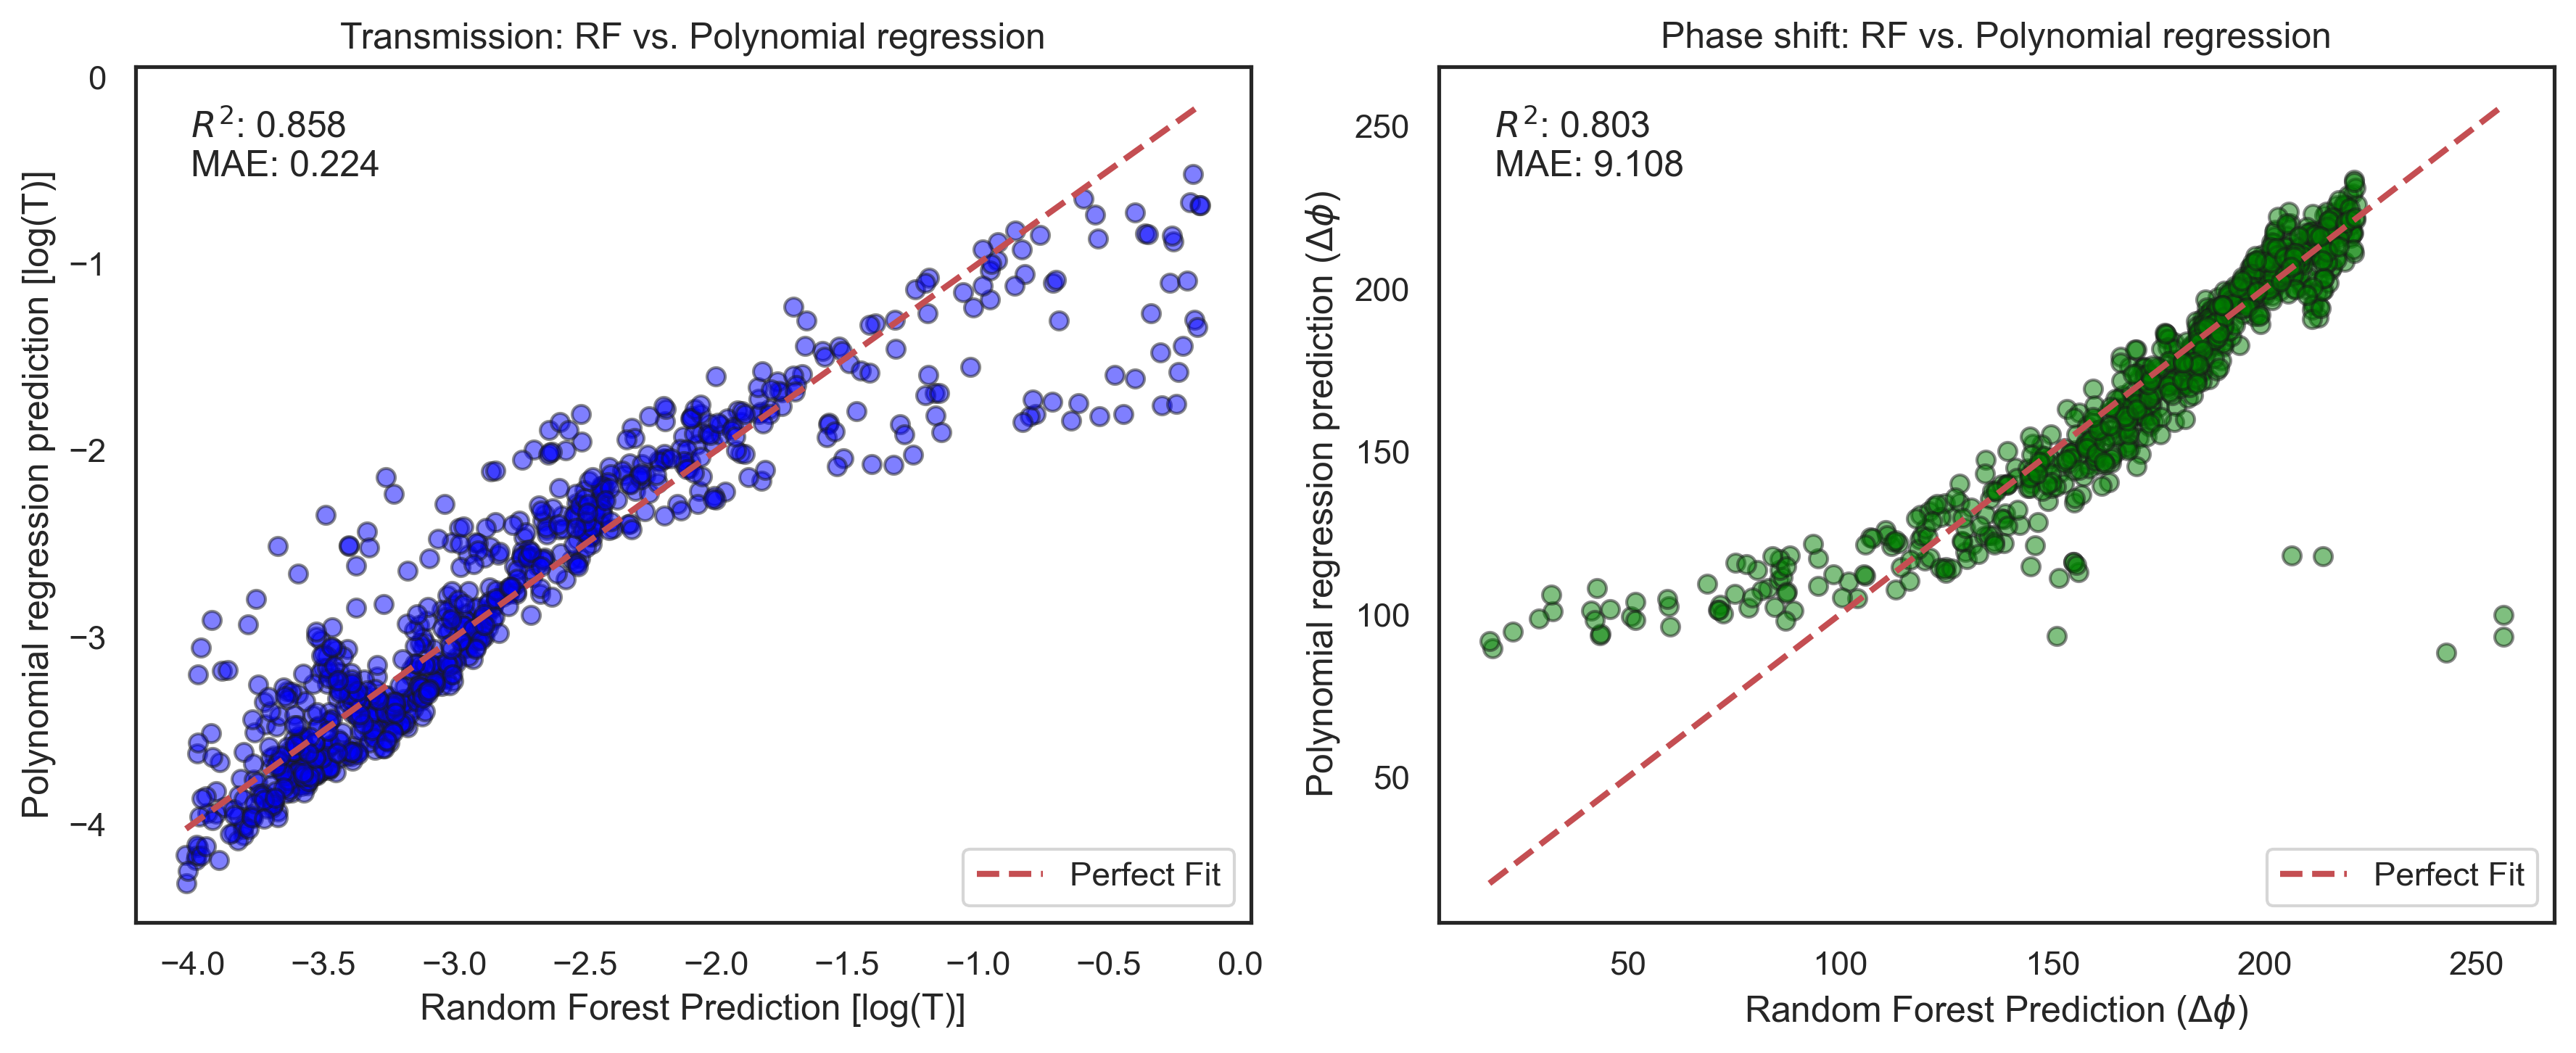

In [50]:
# Predecir con el modelo polinómico sobre los datos de entrenamiento
y_pred_poly_T = poly_model_T.predict(X_train)
y_pred_poly_P = poly_model_P.predict(X_train)

# --- Compute R^2 and MAE ---
r2_T = r2_score(y_pred_rf_T, y_pred_poly_T)
mae_T = mean_absolute_error(y_pred_rf_T, y_pred_poly_T)

r2_P = r2_score(y_pred_rf_P, y_pred_poly_P)
mae_P = mean_absolute_error(y_pred_rf_P, y_pred_poly_P)


# Crear figura con 1 fila y 2 columnas
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# === Plot 1: T ===
axs[0].scatter(y_pred_rf_T, y_pred_poly_T, alpha=0.5, edgecolor='k', color='blue')
axs[0].plot(
    [y_pred_rf_T.min(), y_pred_rf_T.max()],
    [y_pred_rf_T.min(), y_pred_rf_T.max()],
    'r--', lw=2, label="Perfect Fit"
)
axs[0].set_xlabel("Random Forest Prediction [log(T)]")
axs[0].set_ylabel("Polynomial regression prediction [log(T)]")
axs[0].set_title("Transmission: RF vs. Polynomial regression")
axs[0].text(
    0.05, 0.95,
    f"$R^2$: {r2_T:.3f}\nMAE: {mae_T:.3f}",
    transform=axs[0].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
)
axs[0].legend()
axs[0].grid(False)

# === Plot 2: P ===
axs[1].scatter(y_pred_rf_P, y_pred_poly_P, alpha=0.5, edgecolor='k', color='green')
axs[1].plot(
    [y_pred_rf_P.min(), y_pred_rf_P.max()],
    [y_pred_rf_P.min(), y_pred_rf_P.max()],
    'r--', lw=2, label="Perfect Fit"
)
axs[1].set_xlabel(r"Random Forest Prediction ($\Delta\phi$)")
axs[1].set_ylabel(r"Polynomial regression prediction ($\Delta\phi$)")
axs[1].set_title("Phase shift: RF vs. Polynomial regression")
axs[1].text(
    0.05, 0.95,
    f"$R^2$: {r2_P:.3f}\nMAE: {mae_P:.3f}",
    transform=axs[1].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
)
axs[1].legend()
axs[1].grid(False)

# Ajustar layout y mostrar
plt.tight_layout()
fig.savefig("polyfit_to_RF.pdf", format='pdf')
plt.show()

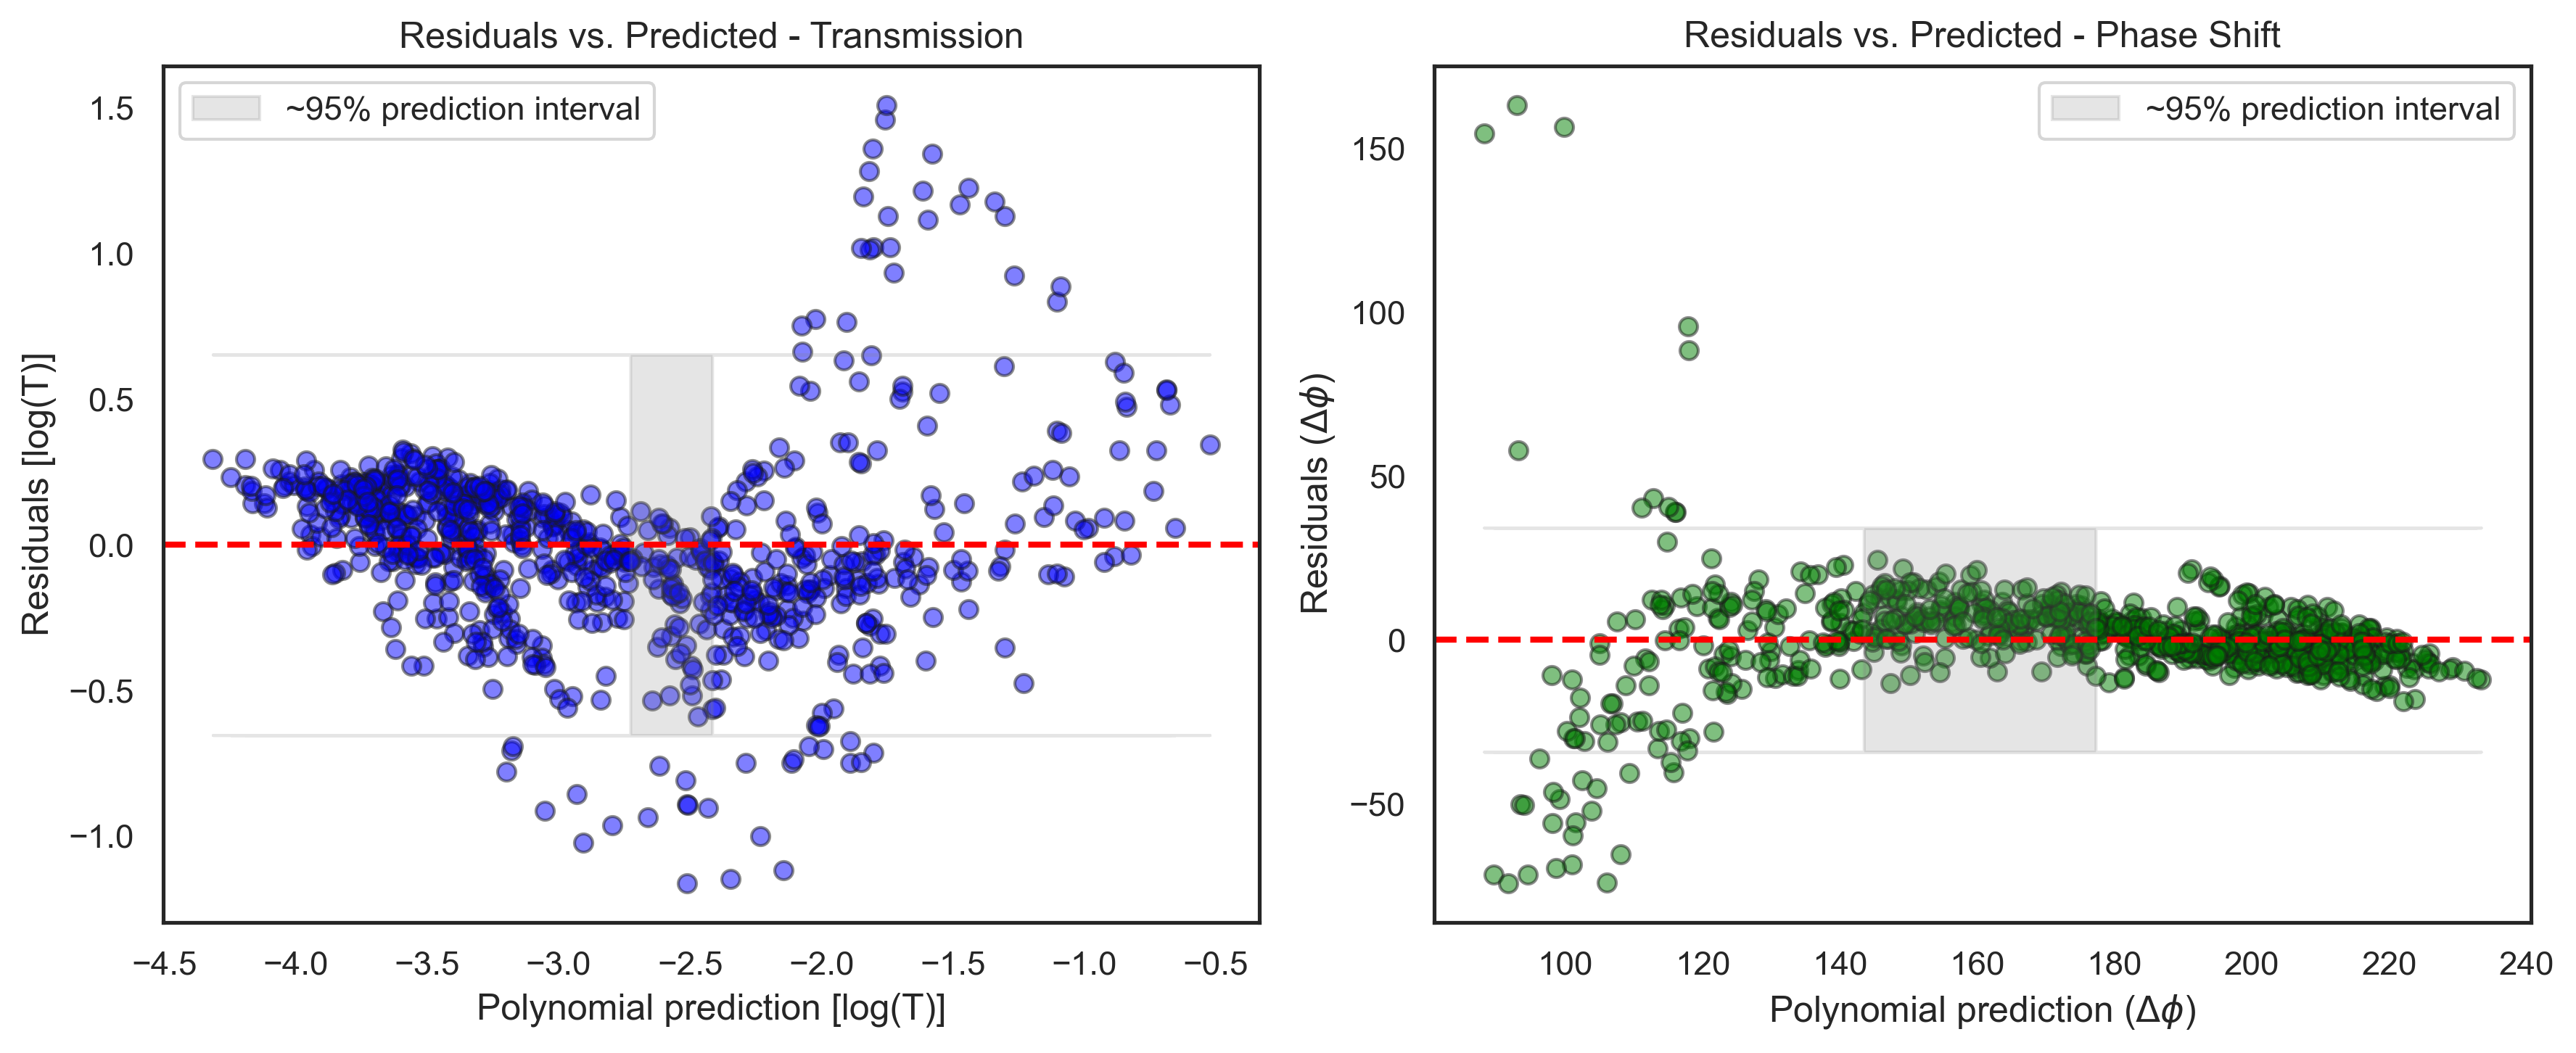

In [51]:
# Residuals
residuals_T = y_pred_rf_T - y_pred_poly_T
residuals_P = y_pred_rf_P - y_pred_poly_P

# Calculate standard deviation of residuals for prediction intervals
std_T = np.std(residuals_T)
std_P = np.std(residuals_P)

# Create new figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# === Plot 1: Residual plot for Transmission ===
axs[0].scatter(y_pred_poly_T, residuals_T, alpha=0.5, edgecolor='k', color='blue')
axs[0].axhline(0, color='red', linestyle='--', lw=2)
axs[0].fill_between(
    y_pred_poly_T, -2 * std_T, 2 * std_T, color='gray', alpha=0.2,
    label='~95% prediction interval'
)
axs[0].set_xlabel("Polynomial prediction [log(T)]")
axs[0].set_ylabel("Residuals [log(T)]")
axs[0].set_title("Residuals vs. Predicted - Transmission")
axs[0].legend()
axs[0].grid(False)

# === Plot 2: Residual plot for Phase Shift ===
axs[1].scatter(y_pred_poly_P, residuals_P, alpha=0.5, edgecolor='k', color='green')
axs[1].axhline(0, color='red', linestyle='--', lw=2)
axs[1].fill_between(
    y_pred_poly_P, -2 * std_P, 2 * std_P, color='gray', alpha=0.2,
    label='~95% prediction interval'
)
axs[1].set_xlabel(r"Polynomial prediction ($\Delta\phi$)")
axs[1].set_ylabel(r"Residuals ($\Delta\phi$)")
axs[1].set_title("Residuals vs. Predicted - Phase Shift")
axs[1].legend()
axs[1].grid(False)

plt.tight_layout()
plt.savefig("residuals_prediction_intervals.pdf", format='pdf')
plt.show()

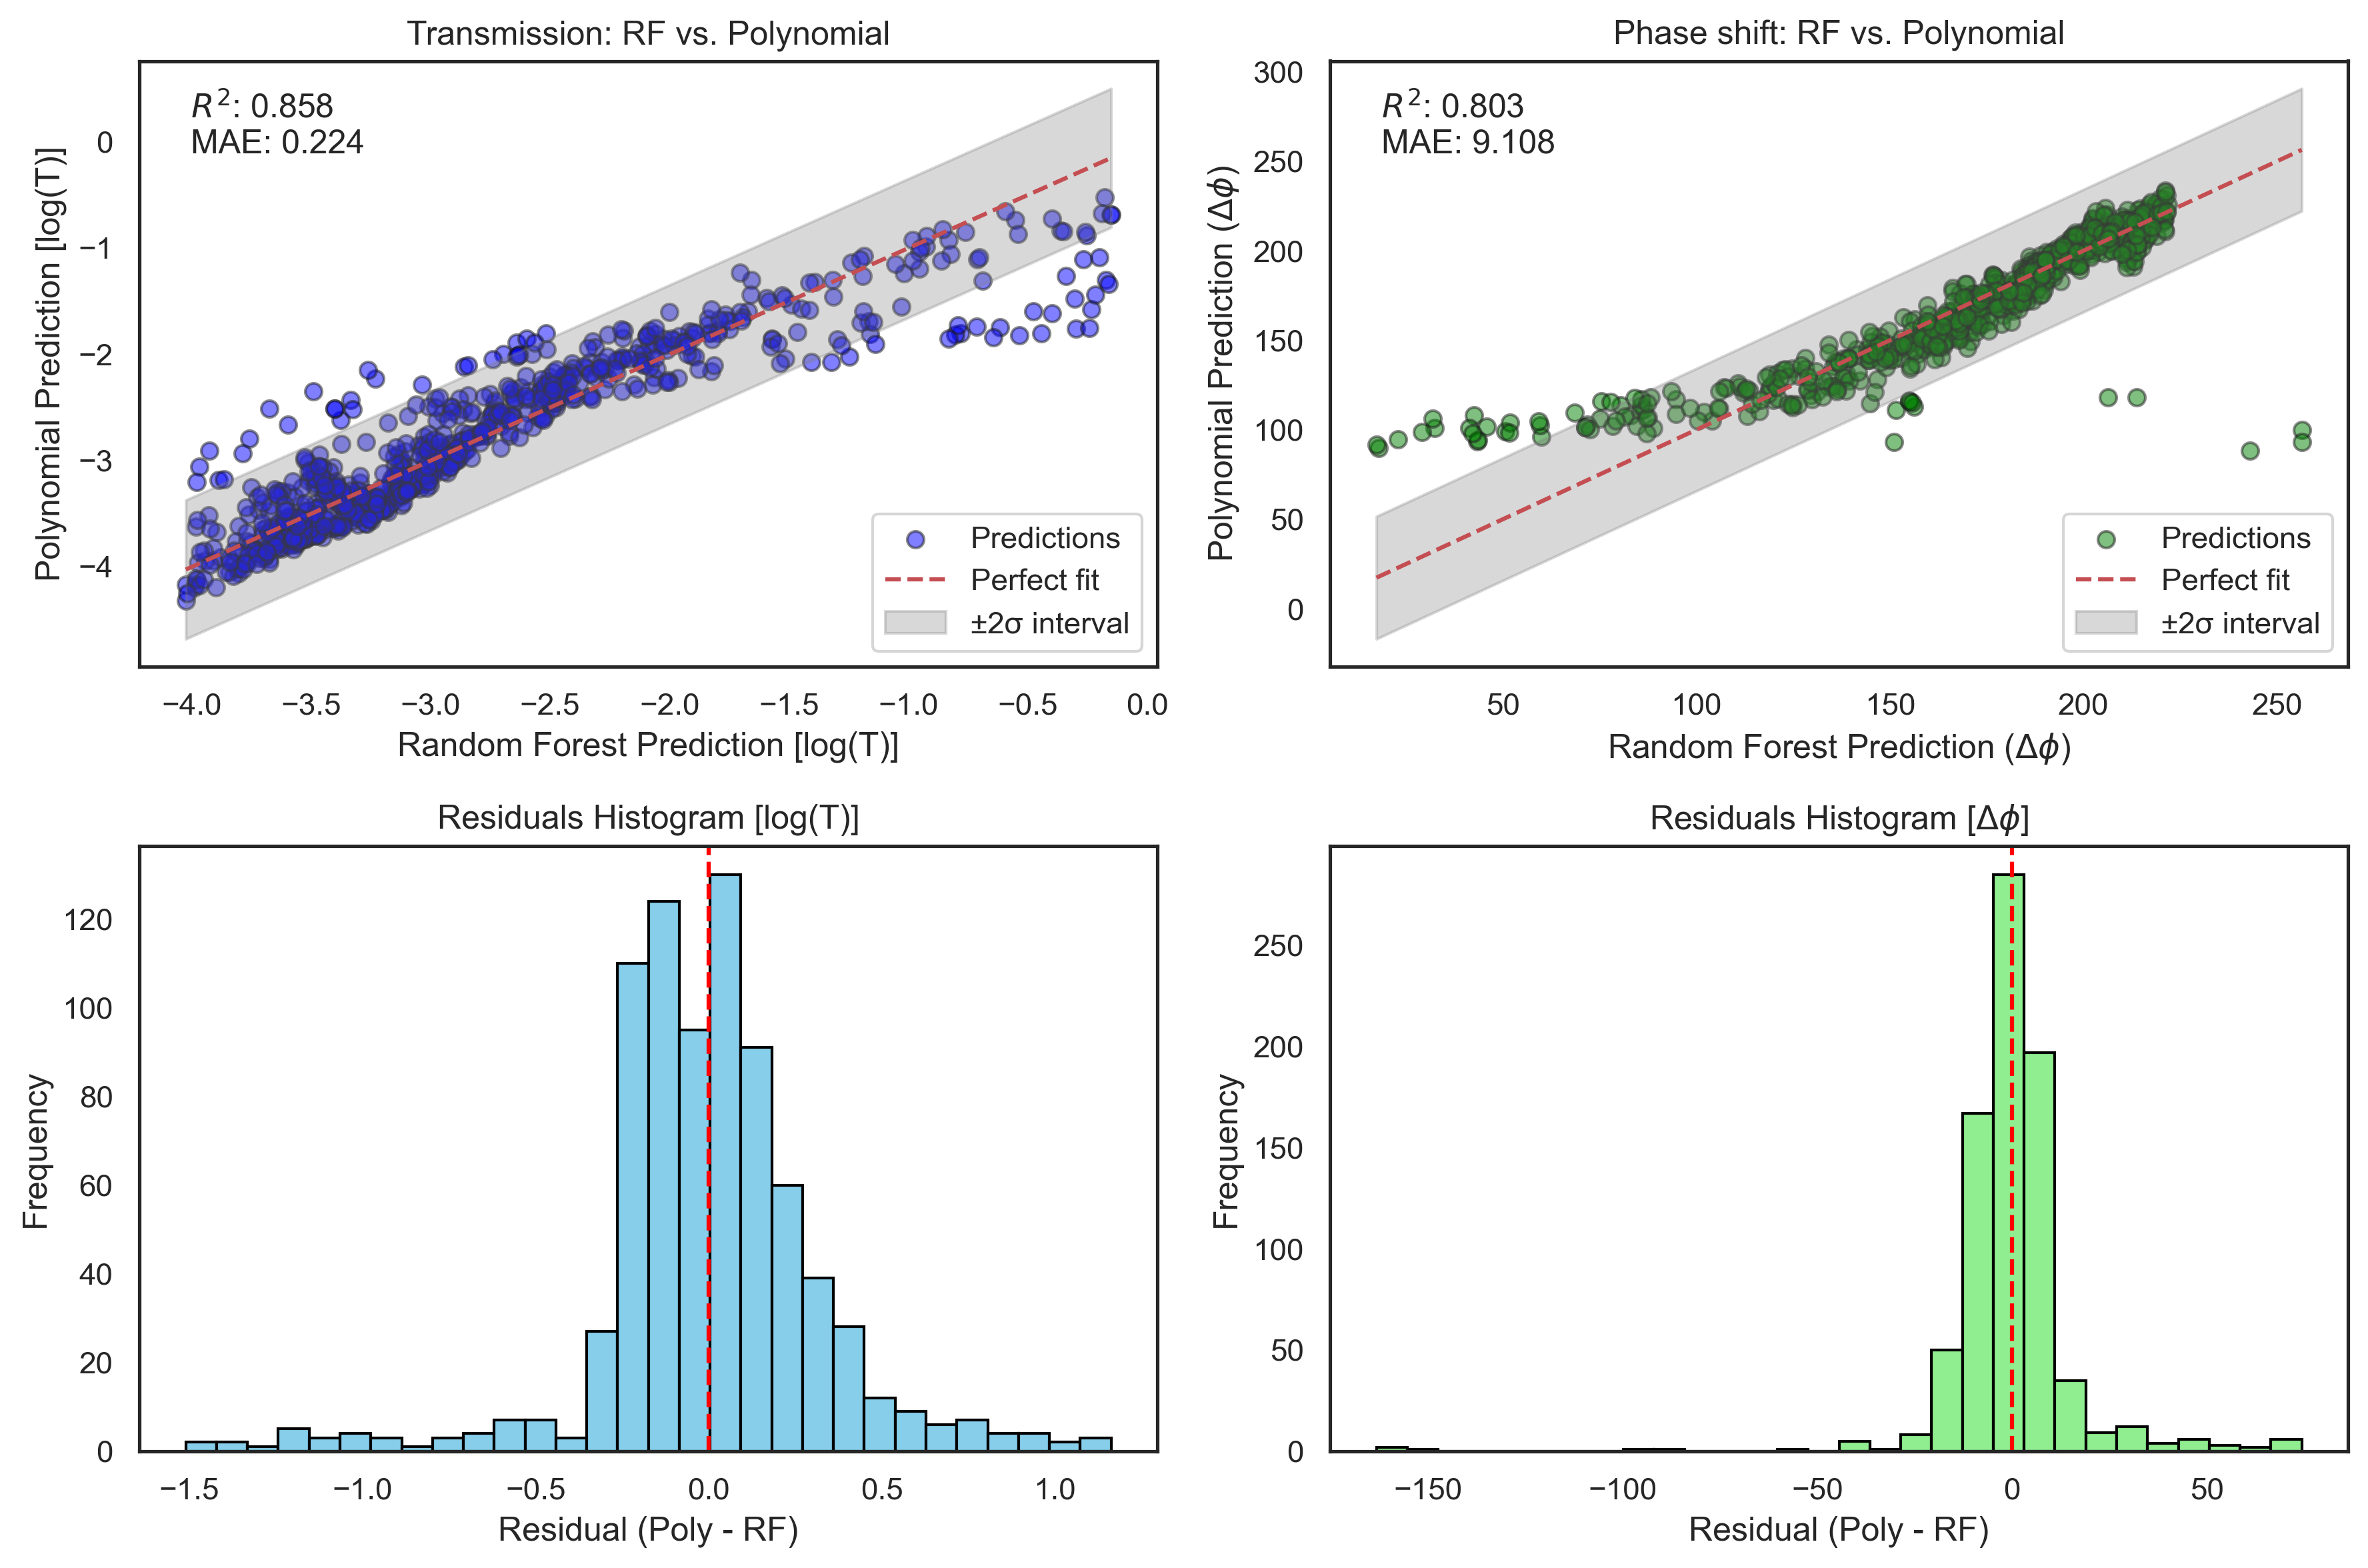

In [53]:


# --- Residuals ---
residuals_T = y_pred_poly_T - y_pred_rf_T
residuals_P = y_pred_poly_P - y_pred_rf_P

std_T = np.std(residuals_T)
std_P = np.std(residuals_P)

# --- Metrics ---
r2_T = r2_score(y_pred_rf_T, y_pred_poly_T)
mae_T = mean_absolute_error(y_pred_rf_T, y_pred_poly_T)

r2_P = r2_score(y_pred_rf_P, y_pred_poly_P)
mae_P = mean_absolute_error(y_pred_rf_P, y_pred_poly_P)

# --- Create figure ---
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# === Plot 1a: Scatter + PI for Transmission ===
axs[0, 0].scatter(y_pred_rf_T, y_pred_poly_T, alpha=0.5, edgecolor='k', color='blue', label="Predictions")
line = np.linspace(min(y_pred_rf_T), max(y_pred_rf_T), 100)
axs[0, 0].plot(line, line, 'r--', label="Perfect fit")
axs[0, 0].fill_between(line, line - 2*std_T, line + 2*std_T, color='gray', alpha=0.3, label="±2σ interval")

axs[0, 0].set_title("Transmission: RF vs. Polynomial")
axs[0, 0].set_xlabel("Random Forest Prediction [log(T)]")
axs[0, 0].set_ylabel("Polynomial Prediction [log(T)]")
axs[0, 0].legend()
axs[0, 0].text(
    0.05, 0.95,
    f"$R^2$: {r2_T:.3f}\nMAE: {mae_T:.3f}",
    transform=axs[0, 0].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# === Plot 1b: Residuals Histogram for Transmission ===
axs[1, 0].hist(residuals_T, bins=30, color='skyblue', edgecolor='black')
axs[1, 0].axvline(0, color='red', linestyle='--')
axs[1, 0].set_title("Residuals Histogram [log(T)]")
axs[1, 0].set_xlabel("Residual (Poly - RF)")
axs[1, 0].set_ylabel("Frequency")

# === Plot 2a: Scatter + PI for Phase Shift ===
axs[0, 1].scatter(y_pred_rf_P, y_pred_poly_P, alpha=0.5, edgecolor='k', color='green', label="Predictions")
line = np.linspace(min(y_pred_rf_P), max(y_pred_rf_P), 100)
axs[0, 1].plot(line, line, 'r--', label="Perfect fit")
axs[0, 1].fill_between(line, line - 2*std_P, line + 2*std_P, color='gray', alpha=0.3, label="±2σ interval")

axs[0, 1].set_title("Phase shift: RF vs. Polynomial")
axs[0, 1].set_xlabel(r"Random Forest Prediction ($\Delta\phi$)")
axs[0, 1].set_ylabel(r"Polynomial Prediction ($\Delta\phi$)")
axs[0, 1].legend()
axs[0, 1].text(
    0.05, 0.95,
    f"$R^2$: {r2_P:.3f}\nMAE: {mae_P:.3f}",
    transform=axs[0, 1].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# === Plot 2b: Residuals Histogram for Phase Shift ===
axs[1, 1].hist(residuals_P, bins=30, color='lightgreen', edgecolor='black')
axs[1, 1].axvline(0, color='red', linestyle='--')
axs[1, 1].set_title("Residuals Histogram [$\Delta\phi$]")
axs[1, 1].set_xlabel("Residual (Poly - RF)")
axs[1, 1].set_ylabel("Frequency")

# --- Layout and Save ---
plt.tight_layout()
plt.savefig("scatter_residuals_intervals.pdf", format='pdf')
plt.show()


QQ-PLOT FOR LINEAR REGRESSION VS RF

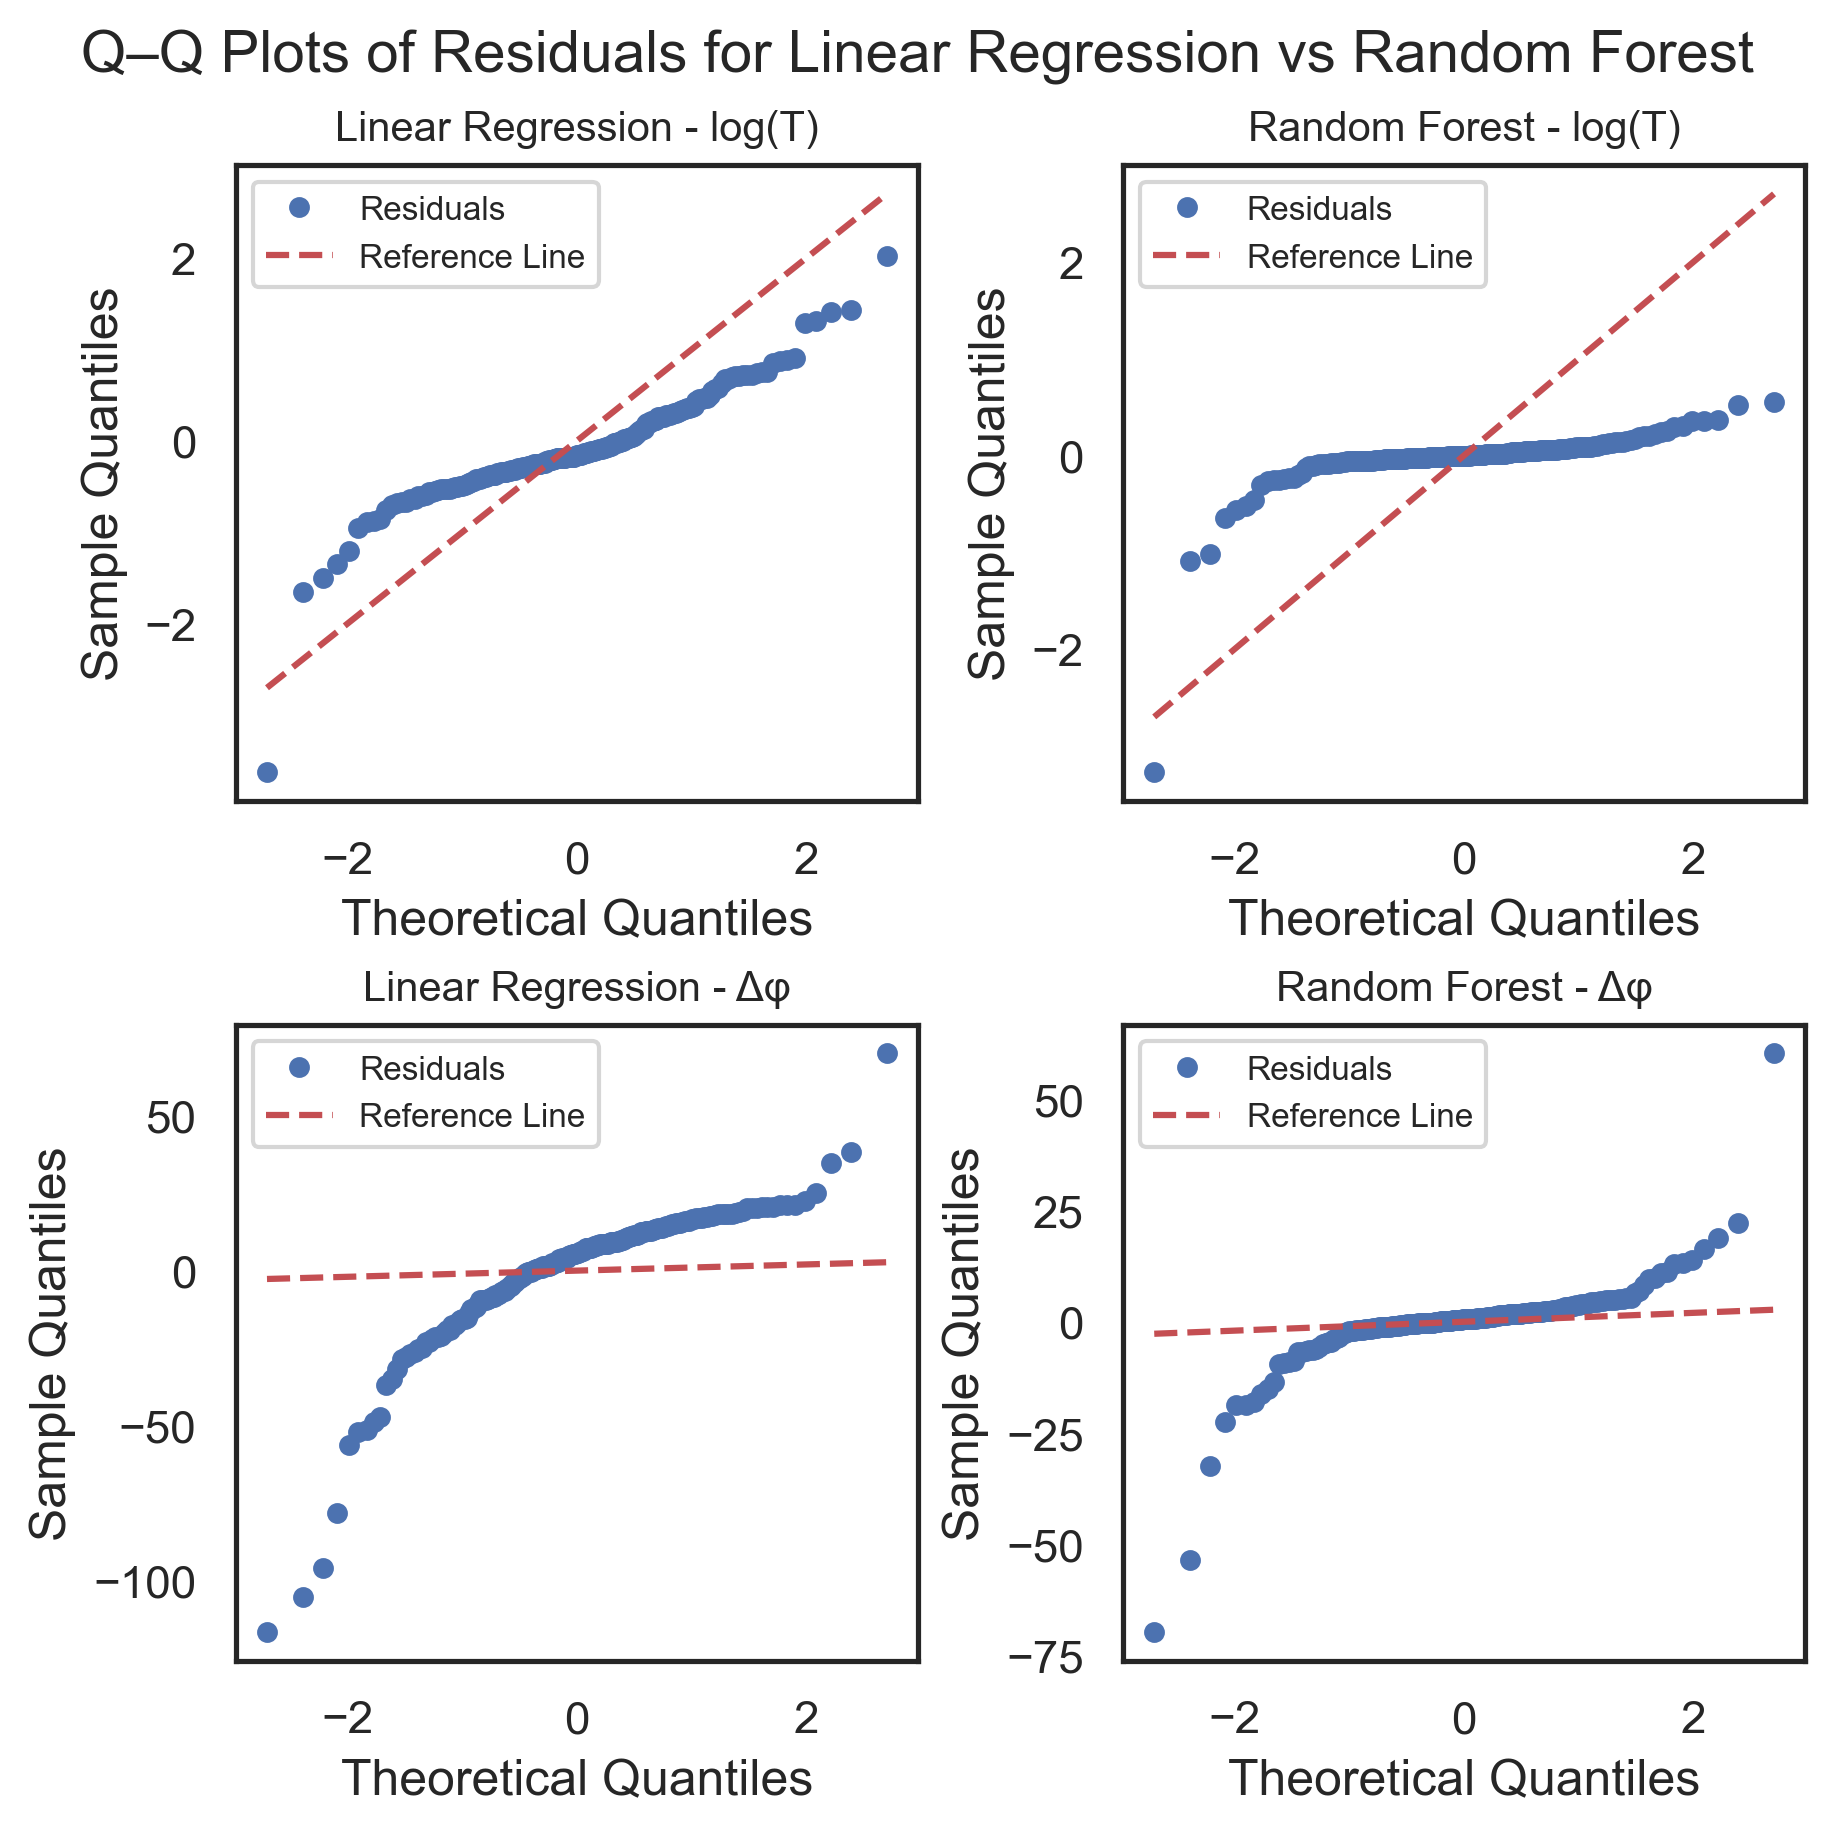

In [60]:
import statsmodels.api as sm
# === Fit linear regression models for comparison ===
lin_T = LinearRegression().fit(X_train, y_T_train)
lin_P = LinearRegression().fit(X_train, y_P_train)

# Predictions & residuals
y_pred_lin_T = lin_T.predict(X_test)
y_pred_lin_P = lin_P.predict(X_test)

residuals_lin_T = y_T_test - y_pred_lin_T
residuals_lin_P = y_P_test - y_pred_lin_P

y_pred_rf_T = rf_T.predict(X_test)
y_pred_rf_P = rf_P.predict(X_test)

residuals_rf_T = y_T_test - y_pred_rf_T
residuals_rf_P = y_P_test - y_pred_rf_P

# ============================================================
# Compute residuals for each model
# ============================================================
residuals = {
    "Linear Regression - log(T)": y_T_test - y_pred_lin_T,
    "Random Forest - log(T)": y_T_test - y_pred_rf_T,
    "Linear Regression - Δφ": y_P_test - y_pred_lin_P,
    "Random Forest - Δφ": y_P_test - y_pred_rf_P
}

# ============================================================
# Plot QQ plots in 2x2 grid
# ============================================================
fig, axs = plt.subplots(2, 2, figsize=(6, 6), constrained_layout=True, sharey=False)
fig.suptitle(r"Q–Q Plots of Residuals for Linear Regression vs Random Forest", fontsize=14)

for ax, (name, resid) in zip(axs.flatten(), residuals.items()):
    osm, osr = stats.probplot(resid, dist="norm")[:2]  # (theoretical, sample)
    ax.plot(osm[0], osm[1], 'o', markersize=4, label='Residuals')
    ax.plot(osm[0], osm[0], 'r--', label='Reference Line')
    ax.set_title(name, fontsize=10)
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")
    ax.grid(False)
    ax.legend(fontsize=8)

# Save and show
plt.savefig("QQ_plots_RF_vs_LR.pdf", format='pdf')
plt.show()

